In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "Datasets/VanilaDataset"
train_patterns = pd.read_csv(file_path + "/train_patterns_with_symbols.csv")
test_patterns = pd.read_csv(file_path + "/test_patterns_with_symbols.csv" )

In [3]:
train_patterns

Symbol                 Chart Pattern  BullishBearish       Start  \
0       GIS         Triangle, symmetrical               0  2024-12-18   
1       TXN     Double Top, Adam and Adam               0  2025-01-15   
2      BSET          Flag, high and tight               1  2020-06-25   
3      NOVT  Double Bottom, Adam and Adam               0  2024-02-21   
4      IPAR   Double Bottom, Eve and Adam               0  2024-05-01   
...     ...                           ...             ...         ...   
2373     CE     Head-and-shoulders bottom               1  2022-02-24   
2374    KMT        Head-and-shoulders top               0  2025-01-06   
2375   BERY     Double Top, Adam and Adam              -1  2020-02-06   
2376    MUR     Double Top, Adam and Adam               0  2023-04-03   
2377   OMCL  Double Bottom, Adam and Adam               1  2020-03-20   

             End                 Industry  Pattern_Length  
0     2025-01-02          Food Processing              15  
1     2025-01-23            Semiconductor               8  
2     2020-08-20    Furn/Home Furnishings              56  
3     2024-02-27     Precision Instrument               6  
4     2024-05-08     Toiletries/Cosmetics               7  
...          ...                      ...             ...  
2373  2022-03-15         Chemical (Basic)              19  
2374  2025-01-30        Metal Fabricating              24  
2375  2020-02-21  Packaging and Container              15  
2376  2023-04-11   Petroleum (Integrated)               8  
2377  2020-03-27   Healthcare Information               7  

[2378 rows x 7 columns]

In [4]:
test_patterns

Symbol                 Chart Pattern  BullishBearish       Start  \
0      NUS   Double Bottom, Eve and Adam               0  2023-01-19   
1      CLS  Double Bottom, Adam and Adam               0  2024-03-11   
2     ADTN         Triangle, symmetrical               0  2023-06-16   
3     ADTN     Head-and-shoulders bottom               1  2020-09-09   
4      NSP  Double Bottom, Adam and Adam               0  2023-05-16   
..     ...                           ...             ...         ...   
590   RGLD     Double Top, Adam and Adam               0  2024-10-21   
591    MRK   Double Bottom, Eve and Adam               0  2024-08-07   
592    IRM  Double Bottom, Adam and Adam               0  2025-01-28   
593    CBT     Double Top, Adam and Adam               0  2024-11-25   
594     BG  Double Bottom, Adam and Adam               1  2022-07-06   

            End                  Industry  Pattern_Length  
0    2023-01-31      Toiletries/Cosmetics              12  
1    2024-03-19               Electronics               8  
2    2023-07-10        Telecom. Equipment              24  
3    2020-10-02        Telecom. Equipment              23  
4    2023-05-31           Human Resources              15  
..          ...                       ...             ...  
590  2024-10-29  Metals and Mining (Div.)               8  
591  2024-08-14                      Drug               7  
592  2025-02-03       Industrial Services               6  
593  2024-12-04    Chemical (Diversified)               9  
594  2022-07-14           Food Processing               8  

[595 rows x 7 columns]

In [5]:
# geth the 1st row of the test_patterns 
row = test_patterns.iloc[0]
# convert to date time
row['Start'] = pd.to_datetime(row['Start'])
print (row['Start'])
print(row['Start'] - pd.to_timedelta(5, unit='D'))

2023-01-19 00:00:00
2023-01-14 00:00:00


C:\Users\gwiku\AppData\Local\Temp\ipykernel_67992\3529229644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Start'] = pd.to_datetime(row['Start'])


In [6]:
from utils.formatAndPreprocess import get_pattern_encoding

pattern_encoding = get_pattern_encoding()
pattern_encoding_reversed = {v: k for k, v in pattern_encoding.items()}
extra_days = 100

# Create a new empty dataframe with Seg_ID, Seg_Start, Seg_End columns + the same columns as the test_patterns
columns = ['Seg_ID', 'Seg_Start', 'Seg_End'] + list(test_patterns.columns)

# Create an empty dataframe
test_pattern_segment_wise = pd.DataFrame(columns=columns)

# Set the path to the folder containing the data
path = 'Datasets/OHLC data'


# Preparing the Test Data Segments


In [7]:
# add a row to test_pattern_segment_wise
def add_row_to_test_pattern_segment_wise(row,seg_id, start, end):
    global test_pattern_segment_wise
    row['Seg_ID'] = seg_id
    row['Seg_Start'] = start
    row['Seg_End'] = end
    test_pattern_segment_wise = test_pattern_segment_wise.append(row, ignore_index=True)

In [8]:
lable_df = pd.DataFrame(columns=['Pattern', 'Center', 'Width'])
# and give this 2 level indexes, level 0 called Instance and level 1 called Pattern_Id
lable_df.index = pd.MultiIndex.from_tuples([], names=['Instance', 'Pattern_Id'])

def add_to_lables( pattern, center, width ,instance, pattern_idx):
    global lable_df
    new_row = { 
                'Pattern': pattern,  # Example pattern
                'Center': center ,  # Example start date
                'Width': width # Example end date
            }
    # Define the MultiIndex for the new row
    new_index = pd.MultiIndex.from_tuples([(instance, pattern_idx)], names=['Instance', 'Pattern_Id'])

    # Create a DataFrame for the new row and append it to the original DataFrame
    new_df = pd.DataFrame([new_row], index=new_index, columns=lable_df.columns)
    lable_df = pd.concat([lable_df, new_df])

## Creating test data segments


Im trying to get test data segments with some surrounding data with a maximem possible number of teting data in a single segment while avoiding training data


In [9]:
import os
from tqdm import tqdm
segment_id = 0

# set a seed to np.random
np.random.seed(69)

# loop through the files in the folder
for filename in tqdm(os.listdir(path), desc="Processing files"):
        if filename.endswith('.csv'):
        # print(filename)
            OHCL_symbol_df = pd.read_csv(path + '/' + filename)
            # print(df.head())
            
            # convert the date columns to datetime
            OHCL_symbol_df['Date'] = pd.to_datetime(OHCL_symbol_df['Date'])
            
            max_available_date = OHCL_symbol_df['Date'].max()
            min_available_date = OHCL_symbol_df['Date'].min()
            
            name = os.path.splitext(filename)[0]
            
            # get the rows of pattern_labled_df where Symbol == name
            train_data_this_symbol = (train_patterns[train_patterns['Symbol'] == name]).copy()
            test_data_this_symbol = (test_patterns[test_patterns['Symbol'] == name]).copy()
            
            # reset the index of the dataframes
            train_data_this_symbol.reset_index(drop=True, inplace=True)
            test_data_this_symbol.reset_index(drop=True, inplace=True)
            
            # in test data create a new column ID and give it the same value as the index
            test_data_this_symbol['ID'] = test_data_this_symbol.index
            
            # print(test_data_this_symbol)
            
            
            # convert the date columns to datetime
            train_data_this_symbol['Start'] = pd.to_datetime(train_data_this_symbol['Start'])
            train_data_this_symbol['End'] = pd.to_datetime(train_data_this_symbol['End'])
            test_data_this_symbol['Start'] = pd.to_datetime(test_data_this_symbol['Start'])
            test_data_this_symbol['End'] = pd.to_datetime(test_data_this_symbol['End'])
            
            
            # 01. pick one test item
            # 02. get the left cut off date as the max of start date - 50 or the cthe end date of a train data point that has a end date between test start date and test start - 50
            # 03. get the right cut off date as the min of end date + 50 or the cthe start date of a train data point that has a start date between test end date and test end + 50
            # 04. get the tets data points that can fit in between the left and right cut off dates
            # 05. iterate the set of test items that is to the left of the selected one , as the new start date is the start date of the i th items start date and the end date is that + 100 + the length of the selcted item
            # 06. get the number of test items that fit between the segment in each iteration , and select the option that has the max number of test items
            # 07. get the wiggle room by the min start date of the test items that fit in the segment and the max end date of the test items that fit in the segment and try to randomise the start and end dates of the segment
            
            # get a list of randomly ordered test item indexes
            index_touple = list(range(len(test_data_this_symbol)))
            np.random.shuffle(index_touple)
            
            # 01. pick one test item
            
            for test_idx in index_touple:
                # get the test item
                test_item = test_data_this_symbol[test_data_this_symbol['ID'] == test_idx]
                index_touple.remove(test_idx)
                selected_test_item_length = test_item['End'] - test_item['Start']
                
                # 02. get the left  and right min and max possible segment dates 
                min_possible_seg_start = (test_item['Start'] - pd.to_timedelta(extra_days, unit='D')).iloc[0]
                max_possible_seg_end = (test_item['End'] + pd.to_timedelta(extra_days, unit='D')).iloc[0]
                
                # 03. get the left and right cut off dates avoiding the train data points that are within the possible segment
                # get the train data points that are within the possible segment
                train_data_that_fit = train_data_this_symbol[(train_data_this_symbol['Start'] <= max_possible_seg_end) | (train_data_this_symbol['End'] >= min_possible_seg_start)]
                
                # get the  maximum of the End dates of train_data_that_fit
                left_cut_off = min_possible_seg_start
                right_cut_off = max_possible_seg_end
                # left_cut_off = min(max(min_possible_seg_start, train_data_that_fit['End'].max()),test_item['Start'].iloc[0])
                if (((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    left_cut_off = test_item['Start'].iloc[0]
                elif (((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] < test_item['Start'].iloc[0])).any()) :
                    Left_cut_off = train_data_that_fit[((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] < test_item['Start'].iloc[0]))]['End'].max()
                else :
                    left_cut_off = min_possible_seg_start
                
                left_cut_off = max(left_cut_off, min_possible_seg_start)
                
                # get the  minimum of the Start dates of train_data_that_fit
                # right_cut_off = max(min(max_possible_seg_end, train_data_that_fit['Start'].min()),test_item['End'].iloc[0])
                if (((train_data_that_fit['Start'] < test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    right_cut_off = test_item['End'].iloc[0]
                elif (((train_data_that_fit['Start'] > test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    right_cut_off = train_data_that_fit[((train_data_that_fit['Start'] > test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0]))]['Start'].min()
                else :
                    right_cut_off = max_possible_seg_end
                
                right_cut_off = min(right_cut_off, max_possible_seg_end)
                
                # 04. get the test data points that are within the cut off dates
                test_data_that_fit = test_data_this_symbol[(test_data_this_symbol['Start'] >= left_cut_off) & (test_data_this_symbol['End'] <= right_cut_off)] 
                
                # if (len(test_data_that_fit) > 1) :
                #     print("test_data_that_fit")
                     
                items_that_fit = pd.DataFrame()
                if(len(test_data_that_fit) > 1):     
                
                    # 05. iterate the test_data_that_fit and get the number of test items that fit in the segment
                    number_of_test_items_that_fit = {}
                    test_items_left_to_the_selected = test_data_that_fit[test_data_that_fit['Start'] <= test_item['Start'].iloc[0]]
                    for idx, row in test_items_left_to_the_selected.iterrows():
                        # get the number of test items that fit in the segment
                        number_of_test_items_that_fit[row["ID"]] = len(test_data_that_fit[(test_data_that_fit['Start'] >= row['Start']) & (test_data_that_fit['End'] <= row['Start'] + pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))])
                
                    test_items_right_to_the_selected = test_data_that_fit[test_data_that_fit['Start'] > test_item['Start'].iloc[0]]
                    for idx, row in test_items_right_to_the_selected.iterrows():
                        # get the number of test items that fit in the segment
                        number_of_test_items_that_fit[row["ID"]] = len(test_data_that_fit[(test_data_that_fit['End'] <= max(row['End'],test_item['End'].iloc[0])) & (test_data_that_fit['Start'] >= max(row['End'],test_item['End'].iloc[0]) - pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))])
                        
                    # 06. get the segment that has the max number of test items that fit
                    # get the key of the max value in the dictionary
                    max_key = max(number_of_test_items_that_fit, key=number_of_test_items_that_fit.get)
                    max_ancor_test_row = test_data_that_fit[test_data_that_fit['ID'] == max_key]
                    
                    if(max_ancor_test_row['Start'].iloc[0]<= test_item['Start'].iloc[0]):
                        items_that_fit = test_data_that_fit[(test_data_that_fit['Start'] >= max_ancor_test_row['Start'].iloc[0]) & (test_data_that_fit['End'] <= max_ancor_test_row['Start'].iloc[0] + pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))]
                    elif(max_ancor_test_row['Start'].iloc[0] > test_item['Start'].iloc[0]):
                        items_that_fit = test_data_that_fit[(test_data_that_fit['End'] <= max(max_ancor_test_row['End'].iloc[0],test_item['End'].iloc[0])) & (test_data_that_fit['Start'] >= max(max_ancor_test_row['End'].iloc[0],test_item['End'].iloc[0]) - pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))]
                    
                    # drop the item with the id of test_item from the items_that_fit
                    items_that_fit = items_that_fit[items_that_fit['ID'] != test_item['ID'].iloc[0]]
                    # print(items_that_fit)
                    
                # 07. get the wiggle room by the min start date of the test items that fit in the segment and the max end date of the test items that fit in the segment and try to randomise the start and end dates of the segment
                if ('items_that_fit' in locals() and not items_that_fit.empty) :
                    max_seg_start_date = min(items_that_fit['Start'].min(),test_item['Start'].iloc[0])
                    min_seg_end_date = max(items_that_fit['End'].max(),test_item['End'].iloc[0])
                else :
                    max_seg_start_date = test_item['Start'].iloc[0]
                    min_seg_end_date = test_item['End'].iloc[0]
                    
                # remove the items that selected from index_touple if it is in index_touple
                for idx, row in items_that_fit.iterrows():
                    if row['ID'] in index_touple:
                        index_touple.remove(row['ID'])
                
                
                # get the wiggle room
                wiggle_room = (pd.to_timedelta(extra_days, unit='D')+ selected_test_item_length.iloc[0]) - (min_seg_end_date - max_seg_start_date)
                
                if (wiggle_room.days < 0) :
                    print("Error")
                
                if ( wiggle_room.days!= 0) :
                    random_days = np.random.randint(0, wiggle_room.days)
                else:
                    random_days = 0
                seg_start_date = max_seg_start_date - pd.to_timedelta(random_days, unit='D')
                seg_end_date = min_seg_end_date + pd.to_timedelta(wiggle_room.days - random_days, unit='D')
                
                seg_start_date = max(seg_start_date, left_cut_off)
                seg_end_date = min(seg_end_date, right_cut_off)
                
                test_pattern_segments = pd.concat([items_that_fit, test_item], ignore_index=True)  
                test_pattern_segments['Seg_ID'] = segment_id
                test_pattern_segments['Seg_Start'] = seg_start_date
                test_pattern_segments['Seg_End'] = seg_end_date
                test_pattern_segment_wise = pd.concat([test_pattern_segment_wise, test_pattern_segments], ignore_index=True)
                segment_id += 1

test_pattern_segment_wise.to_csv("Datasets/test_patterns_large_segment_wise.csv", index=False)
                            

Processing files:   0%|          | 0/632 [00:00<?, ?it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_67992\3016194755.py:165: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_pattern_segment_wise = pd.concat([test_pattern_segment_wise, test_pattern_segments], ignore_index=True)
Processing files: 100%|██████████| 632/632 [00:12<00:00, 51.91it/s]


### Visualization of sample set of segments


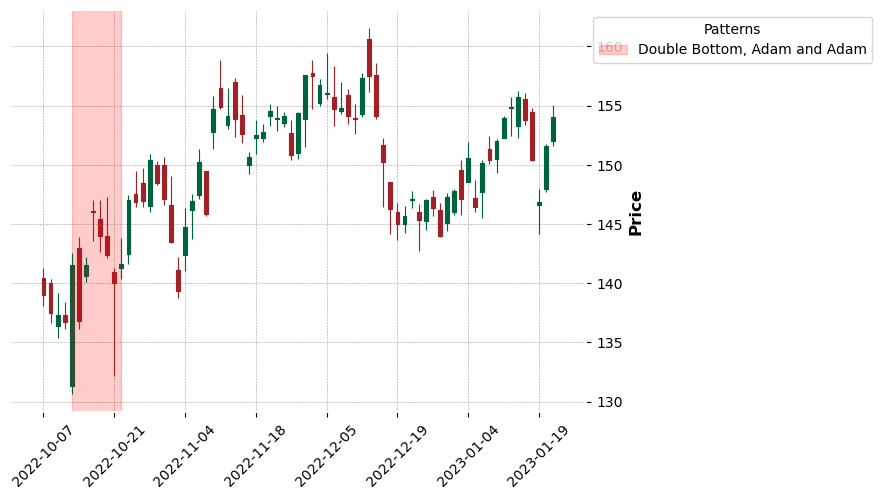

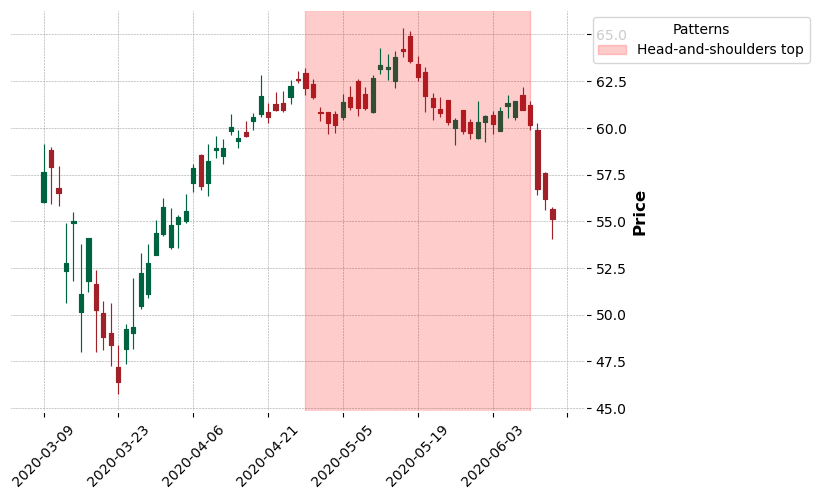

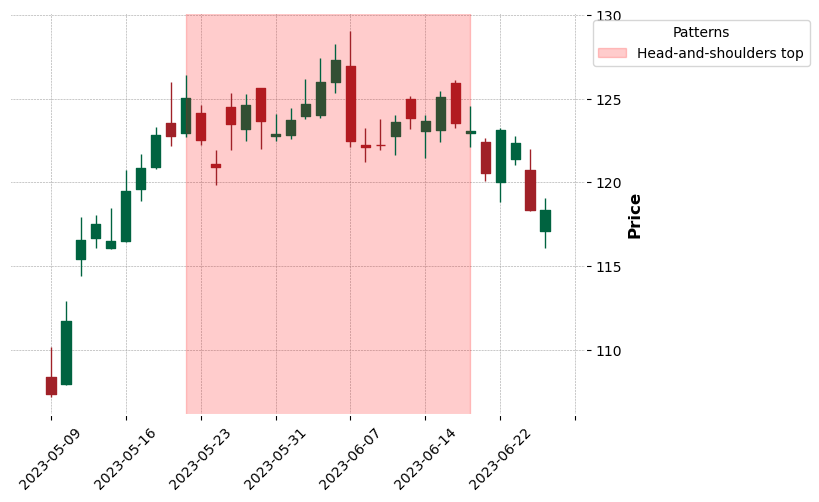

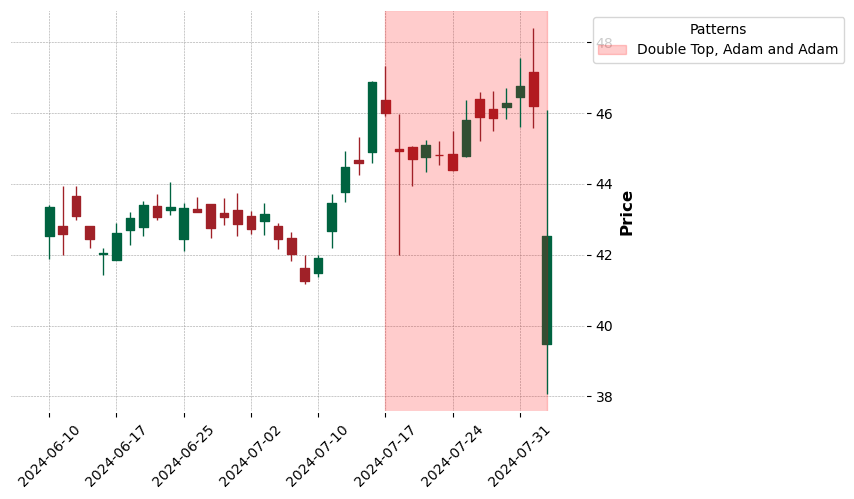

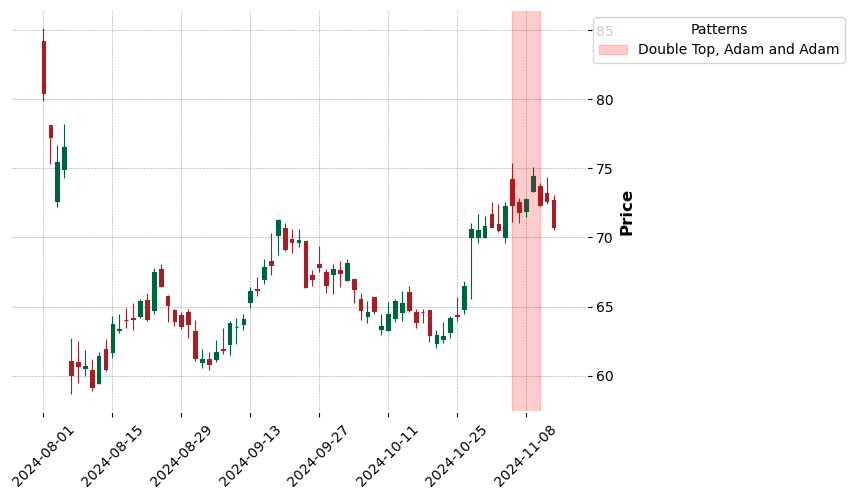

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates

colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'black', 'pink']

# Group by Seg_ID to plot the patterns together
# grouped = test_pattern_segment_wise.head(5).groupby('Seg_ID')
grouped = test_pattern_segment_wise.sample(n=5).groupby('Seg_ID')


# Iterate through each segment group
for seg_id, group in grouped:
    
    # get ohlc data for the symbol
    symbol = group['Symbol'].iloc[0]
    ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')

    # convert the date columns to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]

    # get the ohlc data that is within the segment
    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]   

    if ohcl_data.empty:
        continue
    # Create a candlestick plot using mplfinance
    ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()

    ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

    # Re-plot with proper date formatting
    fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', 
                        datetime_format='%Y-%m-%d', returnfig=True)


    ax = axes[0]  # Access the first (and only) axis object
    # Loop through the patterns and highlight them on the chart
    color_index = 0
    for index, row in group.iterrows():

        
        pattern_start = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
        pattern_end = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object

        pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
        pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object



        num_of_OHLC_data_points_from_seg_start_to_pattern_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])

        pattern_start = num_of_OHLC_data_points_from_seg_start_to_pattern_start

        num_of_OHLC_data_points_from_pattern_start_to_pattern_end = len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

        pattern_end = pattern_start + num_of_OHLC_data_points_from_pattern_start_to_pattern_end

        pattern_lable = row['Chart Pattern']
        
        # Add a vertical span (highlight the pattern) to the chart
        ax.axvspan(pattern_start, pattern_end,color=colors[color_index], alpha=0.2, label=pattern_lable)
        color_index += 1

    # Customize the chart with grid, labels, and legend
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")

    # Show the chart
    plt.show()


### Draw a segment


In [11]:
    
colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "purple", "orange", "brown", "pink", "lime", "teal"]

def plot_patterns_for_segment(segment_id, test_pattern_segment_wise ,ohcl_data_given=None,padding_days=0,same_color = False, color_pattern_wise = False ,color_cluster_wise = False, legend = True , seg_alpha = 0.2, probability = None , save = False,name = ""):
    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    group = grouped.get_group(segment_id)
    ohcl_data = pd.DataFrame()
    
    if (ohcl_data_given is None):
        # get ohlc data for the symbol
        symbol = group['Symbol'].iloc[0]
        ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')
    else:
        ohcl_data = ohcl_data_given

    # convert the date columns to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]
    
    # Define the padding range (before and after the segment)
    seg_start = seg_start - pd.to_timedelta(padding_days, unit='D')
    seg_end = seg_end + pd.to_timedelta(padding_days, unit='D')

    # get the ohlc data that is within the segment
    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]   

    if (ohcl_data.empty == True):
        print("OHLC Data set is empty ")
    else:
        
        # Create a candlestick plot using mplfinance
        ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()


        # # Create the base plot (this returns a figure and axes)
        # fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', title=f'OHLC Chart with Patterns',
        #                         ylabel='Price', figsize=(12, 6), returnfig=True)  # Set figsize here

        ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

        # Re-plot with proper date formatting
        fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', 
                            datetime_format='%Y-%m-%d', returnfig=True)


        ax = axes[0]  # Access the first (and only) axis object
        # Loop through the patterns and highlight them on the chart
        color_index = 0
        for index, row in group.iterrows():

            
            pattern_start = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
            pattern_end = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object
            
            print('Pattern Name : ', row['Chart Pattern'], 'Pattern Start : ', pattern_start, 'Pattern End : ', pattern_end)

            pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
            pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object



            num_of_OHLC_data_points_from_seg_start_to_pattern_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])

            pattern_start = num_of_OHLC_data_points_from_seg_start_to_pattern_start

            num_of_OHLC_data_points_from_pattern_start_to_pattern_end = len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

            pattern_end = pattern_start + num_of_OHLC_data_points_from_pattern_start_to_pattern_end

            pattern_lable = row['Chart Pattern']
            
            if color_pattern_wise:
                color_index = pattern_encoding[pattern_lable]
            if color_cluster_wise:
                color_index = row['Cluster']
            if same_color:
                color_index = 2
            if save and probability is not None :
                seg_alpha = probability/5
            
            # Add a vertical span (highlight the pattern) to the chart
            ax.axvspan(pattern_start, pattern_end,color=colors[color_index], alpha=seg_alpha, label=pattern_lable)
            
            if not color_pattern_wise:
                color_index += 1

        # Customize the chart with grid, labels, and legend
        ax.grid(True)
        if probability is not None:
            ax.set_title(f'Probability of being a {pattern_lable} : {probability}')
        if legend:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")

        # Show the chart
        plt.show()
        
        if save:
            fig.savefig(f"Samples/{segment_id}_{name}.png")

## Sliding window Predicting


In [12]:
# def normalize_ohlc_segment(dataset):
#     # calculate the min values from Low column and max values from High column for each instance
#     min_low = dataset['Low'].min()
#     max_high = dataset['High'].min()
    
#     # OHLC columns to normalize
#     ohlc_columns = ['Open', 'High', 'Low', 'Close']
    
#     dataset_normalized = dataset.copy()
    
#     # Apply the normalization formula to all columns in one go
#     dataset_normalized[ohlc_columns] = (dataset_normalized[ohlc_columns] - min_low) / (max_high - min_low)
    
#     # if there is a Volume column normalize it
#     if 'Volume' in dataset.columns:
#         # calculate the min values from Volume column and max values from Volume column for each instance
#         min_volume = dataset['Volume'].min()
#         max_volume = dataset['Volume'].min()
        
#         # Normalize the Volume column
#         dataset_normalized['Volume'] = (dataset_normalized['Volume'] - min_volume) / (max_volume - min_volume)
    
    
#     return dataset_normalized   

from utils.formatAndPreprocess import normalize_ohlc_segment

In [13]:
def get_ohlc_data_segment(test_pattern_segment_wise, test_seg_id, path,group):
    seg_id = group['Seg_ID'].iloc[0]

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]

    # Get OHLC data for the symbol
    symbol = group['Symbol'].iloc[0]
    ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')

    # Convert the date column to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    # Filter out the original data within the segment (without padding)
    ohlc_data_segment = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]

    # normalize the data segment
    ohlc_data_segment = normalize_ohlc_segment(ohlc_data_segment)

    ohlc_data_segment.drop('Volume', axis=1, inplace=True)
    
    return ohlc_data_segment



In [14]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import math


def process_window(i, ohlc_data_segment, rocket_model, probability_threshold, pattern_encoding_reversed, seg_id, symbol, seg_start, seg_end, test_seg_id, window_size, padding_proportion):
    start_index = i - math.ceil(window_size * padding_proportion)
    end_index = start_index + window_size
    if start_index < 0:
        start_index = 0
    if end_index > len(ohlc_data_segment):
        end_index = len(ohlc_data_segment)

    ohlc_segment = ohlc_data_segment[start_index:end_index]
    if len(ohlc_segment) == 0:
        return None  # Skip empty segments

    win_start_date = ohlc_segment['Date'].iloc[0]
    win_end_date = ohlc_segment['Date'].iloc[-1]
    # print("ohlc befor :" , ohlc_segment)
    ohlc_array_for_rocket = ohlc_segment[['Open', 'High', 'Low', 'Close']].to_numpy().reshape(1, len(ohlc_segment), 4)
    ohlc_array_for_rocket = np.transpose(ohlc_array_for_rocket, (0, 2, 1))
    # print( "ohlc for rocket :" , ohlc_array_for_rocket)
    pattern_probabilities = rocket_model.predict_proba(ohlc_array_for_rocket)
    max_probability = np.max(pattern_probabilities)
    # print(f"Predicted Pattern: {pattern_encoding_reversed[np.argmax(pattern_probabilities)]} with probability: {max_probability} in num {i} window")
    # if max_probability > probability_threshold:
    pattern_index = np.argmax(pattern_probabilities)
    new_row = {
        'Seg_ID': seg_id, 'Start': win_start_date, 'End': win_end_date, 
        'Symbol': symbol, 'Chart Pattern': pattern_encoding_reversed[pattern_index], 
        'Seg_Start': seg_start, 'Seg_End': seg_end ,'Probability': max_probability
    }
    # plot_patterns_for_segment(test_seg_id, pd.DataFrame([new_row]), ohlc_data_segment)
    return new_row
    # return None



def parallel_process_sliding_window(ohlc_data_segment, rocket_model, probability_threshold, stride, pattern_encoding_reversed, group, test_seg_id, window_size, padding_proportion):
    seg_id = group['Seg_ID'].iloc[0]
    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]
    symbol = group['Symbol'].iloc[0]

    num_cores = 10  # Use all available cores

    # Use Parallel as a context manager to ensure cleanup
    with Parallel(n_jobs=num_cores,verbose = 10) as parallel:
        results = parallel(
            delayed(process_window)(i, ohlc_data_segment, rocket_model, probability_threshold, pattern_encoding_reversed, seg_id, symbol, seg_start, seg_end, test_seg_id, window_size, padding_proportion)
            for i in range(0, len(ohlc_data_segment), stride)
        )

    # print(f"Finished processing segment {seg_id} for symbol {symbol}")
    # print(results)
    # Filter out None values and create DataFrame
    win_results_df = pd.DataFrame([res for res in results if res is not None])
    
    # #  do the sam e thing without parrellel processing
    # results = []
    # for i in range(0, len(ohlc_data_segment), stride):
    #     res = process_window(i, ohlc_data_segment, rocket_model, probability_threshold, pattern_encoding_reversed, seg_id, symbol, seg_start, seg_end, test_seg_id, window_size, padding_proportion)
    #     if res is not None:
    #         results.append(res)
    # win_results_df = pd.DataFrame(results)

    return win_results_df


In [15]:
def plot_sliding_steps(win_results_df, ohlc_data_segment, probability_threshold, test_seg_id,save = False):
    # loop through each row of the win_results_df and add plot  
    for index, row in win_results_df.iterrows():
        print(f"Predicted Pattern: {row['Chart Pattern']} with probability: {row['Probability']} in num {index} window")
        if row['Probability'] > probability_threshold:
            plot_patterns_for_segment(test_seg_id, pd.DataFrame([row]), ohlc_data_segment, color_pattern_wise=True,probability = row['Probability'], save = save,name = f"{index}")
            


In [16]:
# # iterate through the padded_ohlc_data rows by 50 rows a time
# import math

# window_size = 30
# padding_proportion = 0.85
# stride = 1
# probability_threshold = 0.75

# # create a data frame with Seg_ID,Start,End,Symbol,Chart Pattern columns to store the results of each window
# win_results_df = pd.DataFrame(columns=['Seg_ID', 'Start', 'End', 'Symbol', 'Chart Pattern','Seg_Start','Seg_End'])

# for i in range(0, len(ohlc_data_segment), stride):
#     start_index  = i - math.ceil(window_size * padding_proportion)
#     end_index = start_index + window_size
#     # print(f"Before : Start Index: {start_index}, End Index: {end_index}")
#     if start_index < 0:
#         start_index = 0
#     if end_index > len(ohlc_data_segment):
#         end_index = len(ohlc_data_segment)

#     # print(f"After : Start Index: {start_index}, End Index: {end_index}")        
#     ohlc_segment = ohlc_data_segment[start_index:end_index]
#     win_start_date = ohlc_segment['Date'].iloc[0]
#     win_end_date = ohlc_segment['Date'].iloc[-1]
#     ohlc_array_for_rocket = ohlc_segment[['Open', 'High', 'Low', 'Close']].to_numpy().reshape(1, len(ohlc_segment), 4)
#     ohlc_array_for_rocket = np.transpose(ohlc_array_for_rocket, (0, 2, 1))
#     pattern_probabilities = rocket_model.predict_proba(ohlc_array_for_rocket)
#     #  get the max probability 
#     max_probability = np.max(pattern_probabilities)
#     win_pred_list = []
    
#     # print the pattern, randge and the max probability then erase it in the next iteration
#     print(f"Predicted Pattern: {pattern_encoding_reversed[np.argmax(pattern_probabilities)]} with probability: {max_probability} in num {i} window")
#     if max_probability > probability_threshold:
#         # get the index of the max probability
#         pattern_index = np.argmax(pattern_probabilities)
#         # print(f"Predicted Pattern: {pattern_encoding_reversed[pattern_index]} with probability: {max_probability} in {i/5}th window")
#         # create a new row for the win_results_df
#         new_row = {'Seg_ID': seg_id, 'Start': win_start_date, 'End': win_end_date, 'Symbol': symbol, 'Chart Pattern': pattern_encoding_reversed[pattern_index], 'Seg_Start': seg_start, 'Seg_End': seg_end}
#         # convert the row to a datafram
#         new_row_df = pd.DataFrame([new_row])
#         plot_patterns_for_segment(test_seg_id, new_row_df , ohlc_data_segment)
#         win_pred_list.append(new_row)
    
#     win_results_df = pd.concat([win_results_df, pd.DataFrame(win_pred_list)], ignore_index=True)
        
    

## Cluster windows of each pattern


In [17]:
def prepare_dataset_for_cluster(ohlc_data_segment, win_results_df):

    predicted_patterns = win_results_df.copy()
    origin_date = ohlc_data_segment['Date'].min()
    for index, row in predicted_patterns.iterrows():
        pattern_start = row['Start']
        pattern_end = row['End']
        
        #  get the number of OHLC data points from the origin date to the pattern start date
        start_point_index = len(ohlc_data_segment[ohlc_data_segment['Date'] < pattern_start])
        pattern_len = len(ohlc_data_segment[(ohlc_data_segment['Date'] >= pattern_start) & (ohlc_data_segment['Date'] <= pattern_end)])
        
        pattern_mid_index = start_point_index + (pattern_len / 2)
        
        # add the center index to a new column Center in the predicted_patterns current row
        predicted_patterns.at[index, 'Center'] = pattern_mid_index
        predicted_patterns.at[index, 'Pattern_Start_pos'] = start_point_index
        predicted_patterns.at[index, 'Pattern_End_pos'] = start_point_index + pattern_len

    return predicted_patterns
    

### DB Scan & Intersection


In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

def cluster_windows(predicted_patterns , probability_threshold, window_size):
    df = predicted_patterns.copy()

    # only get the rows that has a probability greater than the probability threshold
    df = df[df['Probability'] > probability_threshold]

    # Initialize a list to store merged clusters from all groups
    cluster_labled_windows = []
    interseced_clusters = []

    # Group by 'Chart Pattern' and apply clustering to each group
    for pattern, group in df.groupby('Chart Pattern'):
        # print (pattern)
        # print(group)
        # Clustering
        centers = group['Center'].values.reshape(-1, 1)
        eps  =window_size/2 + 4
        db = DBSCAN(eps=eps, min_samples=2).fit(centers)
        group['Cluster'] = db.labels_
        
        cluster_labled_windows.append(group)
        
        # Filter out noise (-1) and group by Cluster
        for cluster_id, cluster_group in group[group['Cluster'] != -1].groupby('Cluster'):

            
            expanded_dates = []
            for _, row in cluster_group.iterrows():
                # Print the start and end dates for debugging
                dates = pd.date_range(row["Start"], row["End"])
                expanded_dates.extend(dates)

            # print("Total expanded dates:", len(expanded_dates))


            # Step 2: Count occurrences of each date
            date_counts = pd.Series(expanded_dates).value_counts().sort_index()

            # Step 3: Identify cluster start and end (where at least 2 windows overlap)
            cluster_start = date_counts[date_counts >= 2].index.min()
            cluster_end = date_counts[date_counts >= 2].index.max()
            
            interseced_clusters.append({
                'Seg_ID' : cluster_group['Seg_ID'].iloc[0],
                'Symbol' : cluster_group['Symbol'].iloc[0],
                'Chart Pattern': pattern,
                'Cluster': cluster_id,
                'Start': cluster_start,
                'End': cluster_end,
                'Seg_Start': cluster_group['Seg_Start'].iloc[0],
                'Seg_End': cluster_group['Seg_End'].iloc[0]
            })

    if len(cluster_labled_windows) == 0 or len(interseced_clusters) == 0:
        return None,None
    # # Combine all merged clusters into a final DataFrame
    cluster_labled_windows_df = pd.concat(cluster_labled_windows)
    interseced_clusters_df = pd.DataFrame(interseced_clusters)

    # sort by the index 
    cluster_labled_windows_df = cluster_labled_windows_df.sort_index()
    # print(cluster_labled_windows_df)
    # Display the result
    # print(merged_df)
    return cluster_labled_windows_df,interseced_clusters_df



### Functional Pattern Filter and Point recognition


In [19]:
from scipy.signal import find_peaks

def calc_head_and_sholder_top(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    # Find valleys (local minima) by inverting the low prices
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    
    # create a list of dates for peaks and valleys
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    

    if len(peak_indices) < 3 or len(valley_indices) < 2:
        print("Not enough peaks and valleys to form a Head & Shoulders pattern.")
        return
    
    try:
        H_index = np.argmax(high_prices[peak_indices])
        H = peak_indices[H_index]
        LS_index = np.argmax(high_prices[peak_indices[0:H_index]])
        LS = peak_indices[LS_index]
        RS_index = np.argmax(high_prices[peak_indices[H_index+1:]]) + H_index + 1
        RS = peak_indices[RS_index]

        vally_left = valley_indices[(valley_indices > LS) & (valley_indices < H)]
        vally_right = valley_indices[(valley_indices > H) & (valley_indices < RS)]
        NL1 = vally_left[np.argmin(low_prices[vally_left])]
        NL2 = vally_right[np.argmin(low_prices[vally_right])]
        
        # Ensure the middle peak is the highest
        if high_prices[H] <= max(high_prices[LS], high_prices[RS]):
            print("Not a valid Head & Shoulders pattern.")
            return
        
        LS_date = ohlc_data_pattern_segment['Date'].iloc[LS]
        H_date = ohlc_data_pattern_segment['Date'].iloc[H]
        RS_date = ohlc_data_pattern_segment['Date'].iloc[RS]
        NL1_date = ohlc_data_pattern_segment['Date'].iloc[NL1]
        NL2_date = ohlc_data_pattern_segment['Date'].iloc[NL2]
        
        # add the dates to the row
        row['HS_Left_Shoulder'] = LS_date
        row['HS_Head'] = H_date
        row['HS_Right_Shoulder'] = RS_date
        row['HS_Neckline_1'] = NL1_date
        row['HS_Neckline_2'] = NL2_date
        row['Peak_Dates'] = peak_dates
        row['Valley_Dates'] = valley_dates
        row['Calc_Start'] = LS_date
        row['Calc_End'] = RS_date
        
        return row
    except:
        print("Error in finding the peaks or valleys in the Head and Shoulders pattern")
        return

def calc_head_and_shoulder_bottom(row, ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1  

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 3 or len(peak_indices) < 2:
        print("Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.")
        return

    try:
        H_index = np.argmin(low_prices[valley_indices])  # Find lowest valley (Head)
        H = valley_indices[H_index]
        LS_index = np.argmin(low_prices[valley_indices[0:H_index]])
        LS = valley_indices[LS_index]
        RS_index = np.argmin(low_prices[valley_indices[H_index+1:]]) + H_index + 1
        RS = valley_indices[RS_index]

        peak_left = peak_indices[(peak_indices > LS) & (peak_indices < H)]
        peak_right = peak_indices[(peak_indices > H) & (peak_indices < RS)]
        NL1 = peak_left[np.argmax(high_prices[peak_left])]
        NL2 = peak_right[np.argmax(high_prices[peak_right])]

        # Ensure the middle valley is the lowest
        if low_prices[H] >= min(low_prices[LS], low_prices[RS]):
            print("Not a valid Head & Shoulders Bottom pattern.")
            return
        
        LS_date = ohlc_data_pattern_segment['Date'].iloc[LS]
        H_date = ohlc_data_pattern_segment['Date'].iloc[H]
        RS_date = ohlc_data_pattern_segment['Date'].iloc[RS]
        NL1_date = ohlc_data_pattern_segment['Date'].iloc[NL1]
        NL2_date = ohlc_data_pattern_segment['Date'].iloc[NL2]

        # Add the detected pattern data to the row
        row['HS_Left_Shoulder'] = LS_date
        row['HS_Head'] = H_date
        row['HS_Right_Shoulder'] = RS_date
        row['HS_Neckline_1'] = NL1_date
        row['HS_Neckline_2'] = NL2_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = LS_date
        row['Calc_End'] = RS_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern")
        return

def calc_double_top_aa(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    # Find valleys (local minima) by inverting the low prices
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    
    # create a list of dates for peaks and valleys
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    

    if len(peak_indices) < 2 or len(valley_indices) < 1:
        print("Not enough peaks and valleys to form a Double Top pattern.")
        return
    
    try:
        H1_index = np.argmax(high_prices[peak_indices])
        H1 = peak_indices[H1_index]
        H2_index = np.argmax(high_prices[peak_indices[H1_index+1:]]) + H1_index + 1
        H2 = peak_indices[H2_index]
        # get v index that is between H1 and H2
        valley_indices_between_H1_H2 = valley_indices[(valley_indices > H1) & (valley_indices < H2)]
        V = valley_indices_between_H1_H2[np.argmax(low_prices[ valley_indices_between_H1_H2])]
        
        # # Ensure the middle peak is the highest
        # if high_prices[H1] <= high_prices[H2]:
        #     print("Not a valid Double Top pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        V_date = ohlc_data_pattern_segment['Date'].iloc[V]
        
        # add the dates to the row
        row['DT_Peak_1'] = H1_date
        row['DT_Peak_2'] = H2_date
        row['DT_Valley'] = V_date
        row['Peak_Dates'] = peak_dates
        row['Valley_Dates'] = valley_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date
        
        return row
    except:
        print("Error in finding the peaks or valleys in the Double Top pattern")
        return
    
def calc_double_bottom_aa(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.05 

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 2 or len(peak_indices) < 1:
        print("Not enough valleys and peaks to form a Double Bottom pattern.")
        return

    try:
        H1_index = np.argmin(low_prices[valley_indices])
        H1 = valley_indices[H1_index]
        H2_index = np.argmin(low_prices[valley_indices[H1_index+1:]]) + H1_index + 1
        H2 = valley_indices[H2_index]
        # get v index that is between H1 and H2
        peak_indices_between_H1_H2 = peak_indices[(peak_indices > H1) & (peak_indices < H2)]
        P = peak_indices_between_H1_H2[np.argmax(high_prices[ peak_indices_between_H1_H2])]
        
        # # Ensure the middle valley is the lowest
        # if low_prices[H1] >= low_prices[H2]:
        #     print("Not a valid Double Bottom pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        P_date = ohlc_data_pattern_segment['Date'].iloc[P]
        
        # Add the detected pattern data to the row
        row['DB_Valley_1'] = H1_date
        row['DB_Valley_2'] = H2_date
        row['DB_Peak'] = P_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Double Bottom pattern")
        return
    
def calc_double_bottom_ea(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    round_vallies,_ = find_peaks(-low_prices, prominence=0.01,width=3,threshold=0.01)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 2 or len(peak_indices) < 1:
        print("Not enough valleys and peaks to form a Double Bottom pattern.")
        return

    try:
        H1_index = np.argmin(low_prices[round_vallies])
        H1 = valley_indices[H1_index]
        H2_index = np.argmin(low_prices[valley_indices[H1_index+1:]]) + H1_index + 1
        H2 = valley_indices[H2_index]
        # get v index that is between H1 and H2
        peak_indices_between_H1_H2 = peak_indices[(peak_indices > H1) & (peak_indices < H2)]
        P = peak_indices_between_H1_H2[np.argmax(high_prices[ peak_indices_between_H1_H2])]
        
        # # Ensure the middle valley is the lowest
        # if low_prices[H1] >= low_prices[H2]:
        #     print("Not a valid Double Bottom pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        P_date = ohlc_data_pattern_segment['Date'].iloc[P]
        
        # Add the detected pattern data to the row
        row['DB_Valley_1'] = H1_date
        row['DB_Valley_2'] = H2_date
        row['DB_Peak'] = P_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Double Bottom pattern")
        return

In [20]:
def functional_pattern_filter_and_point_recognition(interseced_clusters_df):
    located_patterns_and_other_info_rows = []

    # iterate through each row of the interseced_clusters_df 
    for index, row in interseced_clusters_df.iterrows():
        pattern = row['Chart Pattern']
        symbol = row['Symbol']
        ohlc_data_for_symbol = pd.read_csv(path + '/' + symbol + '.csv')
        # convert the date columns to datetime
        ohlc_data_for_symbol['Date'] = pd.to_datetime(ohlc_data_for_symbol['Date'])
        ohlc_data_for_symbol['Date'] = ohlc_data_for_symbol['Date'].dt.tz_localize(None)
        
        # get the ohlc data that is within the segment
        ohlc_data_pattern_segment = ohlc_data_for_symbol[(ohlc_data_for_symbol['Date'] >= row['Start']) & (ohlc_data_for_symbol['Date'] <= row['End'])]
        # reset the index of the ohlc_data_pattern_segment
        ohlc_data_pattern_segment.reset_index(drop=True, inplace=True)
        
        
        
        # write a switch case for each pattern
        if pattern == 'Double Top, Adam and Adam':
            updated_row = calc_double_top_aa(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Triangle, symmetrical':
            # TODO: Implement the symmetrical triangle pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Double Bottom, Eve and Adam':
            updated_row = calc_double_bottom_ea(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
                
            
        elif pattern == 'Head-and-shoulders top':
            updated_row = calc_head_and_sholder_top(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Double Bottom, Adam and Adam':
            updated_row = calc_double_bottom_aa(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Head-and-shoulders bottom':
            updated_row = calc_head_and_shoulder_bottom(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Flag, high and tight':
            # TODO: Implement the high and tight flag pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Cup with handle':
            # TODO : Implement the cup with handle pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        else:
            print("Pattern not found")

    located_patterns_and_other_info = pd.DataFrame(located_patterns_and_other_info_rows)
    return located_patterns_and_other_info




In [21]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

def draw_head_and_shoulders_top(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Head and Shoulders pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    calc_start_date = row['Calc_Start']
    calc_end_date = row['Calc_End']
    
    calc_start_idx = ohlc_data[ohlc_data['Date']== calc_start_date].index
    calc_end_idx = ohlc_data[ohlc_data['Date']== calc_end_date].index
    
    # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
    ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
    ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)
    
    LS_idx = ohlc_data[ohlc_data['Date']== row['HS_Left_Shoulder']].index
    H_idx = ohlc_data[ohlc_data['Date']== row['HS_Head']].index
    RS_idx = ohlc_data[ohlc_data['Date']== row['HS_Right_Shoulder']].index
    NL1_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_1']].index
    NL2_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_2']].index
    
    # Draw the head and shoulders
    ax.plot([LS_idx, H_idx, RS_idx], [high_prices[LS_idx], high_prices[H_idx], high_prices[RS_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="H&S Pattern")
    
    # Use NL1_idx and NL2_idx as the x-range to keep the line within bounds
    x_min, x_max = min(NL1_idx, NL2_idx), max(NL1_idx, NL2_idx)

    # Compute the y-values using the line equation (y = mx + c)
    slope = (low_prices[NL2_idx] - low_prices[NL1_idx]) / (NL2_idx - NL1_idx)
    y_min = low_prices[NL1_idx] + slope * (x_min - NL1_idx)
    y_max = low_prices[NL1_idx] + slope * (x_max - NL1_idx)

    # Plot the line within the original graph size
    ax.plot([x_min, x_max], [y_min, y_max], 
            linestyle="dashed", color="red", linewidth=1, label="Neckline")




    
    

def draw_head_and_shoulders_bottom(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Head and Shoulders pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    calc_start_date = row['Calc_Start']
    calc_end_date = row['Calc_End']
    
    calc_start_idx = ohlc_data[ohlc_data['Date']== calc_start_date].index
    calc_end_idx = ohlc_data[ohlc_data['Date']== calc_end_date].index
    
    # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
    ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
    ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)
    
    
    LS_idx = ohlc_data[ohlc_data['Date']== row['HS_Left_Shoulder']].index
    H_idx = ohlc_data[ohlc_data['Date']== row['HS_Head']].index
    RS_idx = ohlc_data[ohlc_data['Date']== row['HS_Right_Shoulder']].index
    NL1_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_1']].index
    NL2_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_2']].index
    
    # Draw the head and shoulders
    ax.plot([LS_idx, H_idx, RS_idx], [low_prices[LS_idx], low_prices[H_idx], low_prices[RS_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="H&S Pattern")
    
    # Use NL1_idx and NL2_idx as the x-range to keep the line within bounds
    x_min, x_max = min(NL1_idx, NL2_idx), max(NL1_idx, NL2_idx)

    # Compute the y-values using the line equation (y = mx + c)
    slope = (high_prices[NL2_idx] - high_prices[NL1_idx]) / (NL2_idx - NL1_idx)
    y_min = high_prices[NL1_idx] + slope * (x_min - NL1_idx)
    y_max = high_prices[NL1_idx] + slope * (x_max - NL1_idx)

    # Plot the line within the original graph size
    ax.plot([x_min, x_max], [y_min, y_max], 
            linestyle="dashed", color="red", linewidth=1, label="Neckline")


    
def draw_double_top_aa(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Double Top pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    

    
    DT_Peak_1_idx = ohlc_data[ohlc_data['Date']== row['DT_Peak_1']].index
    DT_Peak_2_idx = ohlc_data[ohlc_data['Date']== row['DT_Peak_2']].index
    DT_Valley_idx = ohlc_data[ohlc_data['Date']== row['DT_Valley']].index
    
    # draw the double peaks
    ax.plot([DT_Peak_1_idx,DT_Valley_idx, DT_Peak_2_idx], [high_prices[DT_Peak_1_idx],high_prices[DT_Valley_idx], high_prices[DT_Peak_2_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="Double Top Pattern")
    # Draw the neckline
    ax.hlines(y=low_prices[DT_Valley_idx], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='red', linestyle='dotted', linewidth=1)

def draw_double_bottom_aa(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Double Bottom pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    DB_Valley_1_idx = ohlc_data[ohlc_data['Date']== row['DB_Valley_1']].index
    DB_Valley_2_idx = ohlc_data[ohlc_data['Date']== row['DB_Valley_2']].index
    DB_Peak_idx = ohlc_data[ohlc_data['Date']== row['DB_Peak']].index
    
    # draw the double peaks
    ax.plot([DB_Valley_1_idx,DB_Peak_idx, DB_Valley_2_idx], [low_prices[DB_Valley_1_idx],low_prices[DB_Peak_idx], low_prices[DB_Valley_2_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="Double Bottom Pattern")
    # Draw the neckline
    ax.hlines(y=high_prices[DB_Peak_idx], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='red', linestyle='dotted', linewidth=1)

def plot_pattern_clusters(segment_id, test_pattern_segment_wise, ohcl_data_given=None, padding_days=0,draw_lines = False):
    colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "purple", "orange", "brown", "pink", "lime", "teal"]

    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    group = grouped.get_group(segment_id)
    
    if ohcl_data_given is None:
        symbol = group['Symbol'].iloc[0]
        ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')
    else:
        ohcl_data = ohcl_data_given

    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0] - pd.to_timedelta(padding_days, unit='D')
    seg_end = group['Seg_End'].iloc[0] + pd.to_timedelta(padding_days, unit='D')

    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]
    if ohcl_data.empty:
        print("OHLC Data set is empty")
        return

    ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()
    ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

    fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', datetime_format='%Y-%m-%d', returnfig=True)
    ax = axes[0]

    for _, row in group.iterrows():
        pattern_name = row['Chart Pattern']
        cluster = row['Cluster']
        color = "gray" if cluster == -1 else colors[cluster]

        pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)
        pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)

        num_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])
        num_end = num_start + len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

        ax.axvspan(num_start, num_end, color=color, alpha=0.1, label=pattern_name)
        

        if draw_lines:
            # error = row['Error'] check only if the column is present
            error = False
            if 'Error' in row and row['Error'] != np.nan:
                error = row['Error']
            if error != True:
                calc_start_date = row['Calc_Start']
                calc_end_date = row['Calc_End']
                
                # reset the index of the ohlc_data
                ohcl_data.reset_index(drop=True, inplace=True)
                
                calc_start_idx = ohcl_data[ohcl_data['Date']== calc_start_date].index
                calc_end_idx = ohcl_data[ohcl_data['Date']== calc_end_date].index
                
                # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
                ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
                ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)

                # If detected pattern is Head and Shoulders, plot indicator lines
                if pattern_name == "Head-and-shoulders top":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_head_and_sholder = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_head_and_shoulders_top(ax, ohcl_data, num_start,row)
                elif pattern_name == "Head-and-shoulders bottom":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_head_and_sholder = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_head_and_shoulders_bottom(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Top, Adam and Adam":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_top_aa(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Bottom, Adam and Adam":
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_bottom_aa(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Bottom, Eve and Adam":
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_bottom_aa(ax, ohcl_data, num_start,row)
    
    
    if draw_lines:    
        # Get unique legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = {}
        unique_handles = []
        


        # Initialize storage for unique handles/labels
        unique_labels = {}
        unique_handles = []
        i= 1
        
        for handle, label in zip(handles, labels):
            # print(label)
            
            # Allow duplication if the label is in pattern_encoding
            if label in pattern_encoding or label not in unique_labels:
                if label not in unique_labels:
                    unique_labels[label] = handle
                    unique_handles.append(handle)
                else:
                    unique_labels[label + f"_{i}"] = handle
                    unique_handles.append(handle)
                    i += 1
                    

        ax.legend(unique_handles, unique_labels.keys())



    ax.grid(True)
    plt.show()


In [22]:
# pattern = 'Head-and-shoulders top'
# cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == pattern]

In [23]:
def plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, test_seg_id):
    # for each unique Chart Pattern in located_patterns_and_other_info plot the patterns
    for pattern, group in located_patterns_and_other_info.groupby('Chart Pattern'):
        # pattern = 'Head-and-shoulders top'
        print (pattern ," :")
        print("    Clustered Windows :")
        plot_pattern_clusters(test_seg_id, cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == pattern])
        print("    Finalized Section :")
        plot_pattern_clusters(test_seg_id, located_patterns_and_other_info[located_patterns_and_other_info['Chart Pattern'] == pattern],draw_lines=True)



# Loop Through All the segments


In [24]:
grouped = test_pattern_segment_wise.groupby('Seg_ID')
# get the seg id with the most number of patterns
max_seg_id = 0
max_patterns = 0
for seg_id, group in grouped:
    if len(group) >= max_patterns:
        max_patterns = len(group)
        max_seg_id = seg_id
        print(f"Segment ID: {seg_id} with {len(group)} patterns")

print(f"Segment ID with the most number of patterns: {max_seg_id} with {max_patterns} patterns")

Segment ID: 0 with 1 patterns
Segment ID: 1 with 1 patterns
Segment ID: 2 with 1 patterns
Segment ID: 3 with 1 patterns
Segment ID: 4 with 1 patterns
Segment ID: 5 with 1 patterns
Segment ID: 6 with 1 patterns
Segment ID: 7 with 1 patterns
Segment ID: 8 with 1 patterns
Segment ID: 9 with 1 patterns
Segment ID: 10 with 1 patterns
Segment ID: 11 with 1 patterns
Segment ID: 12 with 2 patterns
Segment ID: 25 with 2 patterns
Segment ID: 58 with 2 patterns
Segment ID: 61 with 2 patterns
Segment ID: 64 with 2 patterns
Segment ID: 83 with 2 patterns
Segment ID: 85 with 2 patterns
Segment ID: 88 with 2 patterns
Segment ID: 96 with 2 patterns
Segment ID: 161 with 2 patterns
Segment ID: 179 with 2 patterns
Segment ID: 181 with 2 patterns
Segment ID: 200 with 2 patterns
Segment ID: 226 with 2 patterns
Segment ID: 236 with 2 patterns
Segment ID: 245 with 2 patterns
Segment ID: 250 with 2 patterns
Segment ID: 263 with 2 patterns
Segment ID: 270 with 2 patterns
Segment ID: 274 with 2 patterns
Segment

Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-16 00:00:00 Pattern End :  2023-03-24 00:00:00


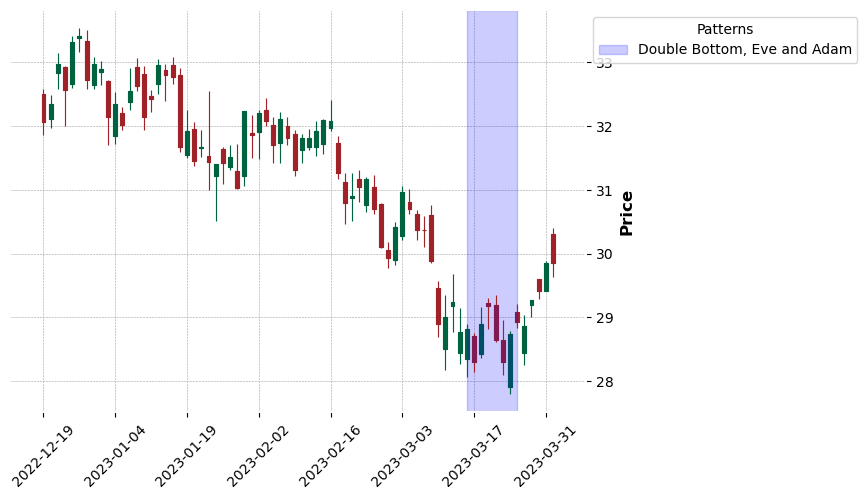

In [25]:
test_seg_id = 392                 
plot_patterns_for_segment(test_seg_id    , test_pattern_segment_wise)

In [26]:
# load the pipelined model
import os
import joblib
from utils.FixedLengthTransformer import FixedLengthTransformer

# window_size = 20
win_size_proportion = 5
padding_proportion = 0.6
stride = 1
probability_threshold = 0.65


model_save_dir = ''
multi_rocket_model = joblib.load(os.path.join(model_save_dir, "multi_rocket_model_w_aug_PU.pkl"))
rocket_model = joblib.load("rocket_model_w_aug_PU.pkl")
mini_rocket_model = joblib.load("mini_rocket_model_w_aug_PU.pkl")

In [27]:
multi_rocket_model

Pipeline(steps=[('fixedlengthtransformer',
                 FixedLengthTransformer(fixed_length=100)),
                ('multirocketmultivariate',
                 MultiRocketMultivariate(n_jobs=-1, num_kernels=10000)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               en...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [28]:
rocket_model

Pipeline(steps=[('fixedlengthtransformer',
                 FixedLengthTransformer(fixed_length=100)),
                ('rocket', Rocket()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=Non...None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [29]:
mini_rocket_model

Pipeline(steps=[('fixedlengthtransformer',
                 FixedLengthTransformer(fixed_length=100)),
                ('minirocketmultivariate',
                 MiniRocketMultivariate(num_kernels=5000)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=150,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [30]:
test_pattern_segment_wise

Seg_ID  Seg_Start    Seg_End Symbol                 Chart Pattern  \
0        0 2024-02-05 2024-05-28     AA  Double Bottom, Adam and Adam   
1        1 2020-10-29 2021-03-21     AA          Flag, high and tight   
2        2 2020-08-13 2021-03-28   AAPL               Cup with handle   
3        3 2021-03-03 2021-06-25    ABT         Triangle, symmetrical   
4        4 2024-02-19 2024-06-18   ACIW         Triangle, symmetrical   
..     ...        ...        ...    ...                           ...   
442    405 2024-05-28 2024-09-18   ^DJI     Double Top, Adam and Adam   
443    406 2024-01-07 2024-03-22   ^DJT         Triangle, symmetrical   
444    407 2022-07-19 2022-11-21   ^DJU     Double Top, Adam and Adam   
445    408 2022-02-02 2022-05-25  ^IXIC     Double Top, Adam and Adam   
446    408 2022-02-02 2022-05-25  ^IXIC     Head-and-shoulders bottom   

    BullishBearish      Start        End                   Industry  \
0                0 2024-04-18 2024-05-01          Aerospace/Defense   
1                1 2021-01-27 2021-03-11          Aerospace/Defense   
2                1 2020-09-02 2021-01-07  Computers and Peripherals   
3                1 2021-03-25 2021-04-08           Medical Supplies   
4                0 2024-02-28 2024-03-19                IT Services   
..             ...        ...        ...                        ...   
442              0 2024-07-18 2024-07-31                        NaN   
443              0 2024-02-20 2024-03-11                        NaN   
444              0 2022-08-18 2022-09-12                        NaN   
445             -1 2022-02-02 2022-02-10                        NaN   
446              1 2022-05-12 2022-05-24                        NaN   

    Pattern_Length   ID  
0               13  0.0  
1               43  2.0  
2              127  0.0  
3               14  0.0  
4               20  0.0  
..             ...  ...  
442             13  1.0  
443             20  0.0  
444             25  0.0  
445              8  0.0  
446             12  1.0  

[447 rows x 11 columns]

In [31]:
seg_ids= [392,363]

import sys


located_patterns_and_other_info_list = []
window_results_list = []
model = mini_rocket_model

for seg_id, group in tqdm(grouped, desc="Processing segments"):
    
    test_seg_id = seg_id  
# for test_seg_id in tqdm(seg_ids, desc="Processing test segments"):
    try :
        # plot_patterns_for_segment(test_seg_id    , test_pattern_segment_wise)
        grouped = test_pattern_segment_wise.groupby('Seg_ID')
        # Select a group
        group = grouped.get_group(test_seg_id)

        Seg_Start = group.iloc[0]['Seg_Start']
        Seg_End = group.iloc[0]['Seg_End']
        seg_len = (Seg_End - Seg_Start).days

        window_size = seg_len // win_size_proportion
        if window_size < 10:
            window_size = 10
        # elif window_size > 30:
        #     window_size = 30
            
        ohlc_data_segment = get_ohlc_data_segment(test_pattern_segment_wise, test_seg_id, path,group) 
        if ohlc_data_segment is None:
            print("OHLC Data segment is empty")
            continue   
        win_results_df = parallel_process_sliding_window(ohlc_data_segment, model, probability_threshold,stride, pattern_encoding_reversed,group,test_seg_id,window_size, padding_proportion)
        if win_results_df is None:
            print("Window results dataframe is empty")
            continue
        window_results_list.append(win_results_df)
        # plot_sliding_steps(win_results_df ,ohlc_data_segment,probability_threshold ,test_seg_id)
        predicted_patterns = prepare_dataset_for_cluster(ohlc_data_segment, win_results_df)
        if predicted_patterns is None:
            print("Predicted patterns dataframe is empty")
        cluster_labled_windows_df , interseced_clusters_df = cluster_windows(predicted_patterns, probability_threshold, window_size)
        if cluster_labled_windows_df is None or interseced_clusters_df is None:
            print("Clustered windows dataframe is empty")
            continue
        located_patterns_and_other_info = functional_pattern_filter_and_point_recognition(interseced_clusters_df)
        if located_patterns_and_other_info is None:
            print("Located patterns and other info dataframe is empty")
            continue
        # plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, test_seg_id)
        
        located_patterns_and_other_info_list.append(located_patterns_and_other_info)
    except:
        print("Error in segment ID: ",test_seg_id,"error : ",sys.exc_info()[0])
        continue

located_patterns_and_other_info_final_df = pd.concat(located_patterns_and_other_info_list)
window_results_all_df = pd.concat(window_results_list)

Processing segments:   0%|          | 0/409 [00:00<?, ?it/s][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   13.3s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   15.8s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   16.7s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   16.8s finished
Processing segments:   0%|          | 1/409 [00:17<1:57:15, 17.24s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elap

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done  74 out of  84 | elapsed:   14.5s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  84 out of  84 | elapsed:   15.8s finished
Processing segments:   1%|          | 5/409 [01:26<1:54:01, 16.93s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   12.0s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   13.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   13.9s finished
Processing segments:   2%|▏         | 7/409 [01:53<1:41:19, 15.12s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:    1.1s remaining:    0.7s
[Parallel

Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.5s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   12.7s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   12.9s finished
Processing segments:   2%|▏         | 9/409 [02:08<1:16:39, 11.50s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   13.4s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   14.6s finished
Processing segments:   2%|▏         | 10/409 [02:22<1:23:16, 12.52s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done  79 out of  89 | elapsed:   15.3s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  89 out of  89 | elapsed:   16.4s finished
Processing segments:   3%|▎         | 11/409 [02:39<1:31:18, 13.77s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   13.2s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   14.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   14.6s finished
Processing segments:   3%|▎         | 12/409 [02:54<1:33:09, 14.08s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   13.1s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   13.6s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   14.4s finished
Processing segments:   3%|▎         | 13/409 [03:08<1:33:51, 14.22s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   12.3s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   13.6s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   14.1s finished
Processing segments:   3%|▎         | 14/409 [03:23<1:33:45, 14.24s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done  75 out of  85 | elapsed:   13.1s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  85 out of  85 | elapsed:   14.1s finished
Processing segments:   4%|▍         | 18/409 [04:24<1:33:59, 14.42s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   11.6s
[Parallel(n_jobs=10)]: Done  84 out of  93 | elapsed:   14.2s remaining:    1.4s
[Parallel(n_jobs=10)]: Done  93 out of  93 | elapsed:   15.1s finished
Processing segments:   5%|▍         | 19/409 [04:39<1:35:29, 14.69s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   15.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   18.3s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   21.0s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   23.7s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:   26.8s
[Parallel(n_jobs=10)]: Done 184 out of 184 | elapsed:   29.7s finished
Processing segments:   5%|▍         | 20/409 [05:09<2:04:57, 19.27s/it][Parallel(n_jobs=10)]: Using backend LokyBackend wit

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   11.6s
[Parallel(n_jobs=10)]: Done  75 out of  85 | elapsed:   13.2s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  85 out of  85 | elapsed:   14.2s finished
Processing segments:   5%|▌         | 22/409 [05:36<1:45:26, 16.35s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done  81 out of  90 | elapsed:   13.8s remaining:    1.4s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   14.7s finished
Processing segments:   6%|▌         | 24/409 [06:04<1:37:27, 15.19s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   11.3s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   12.0s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   12.4s finished
Processing segments:   6%|▌         | 25/409 [06:16<1:32:18, 14.42s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.4s

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   11.4s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   12.9s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   13.3s finished
Processing segments:   7%|▋         | 28/409 [07:00<1:31:50, 14.46s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.3s
[Parallel(n_jobs=10)]: Done  73 out of  83 | elapsed:   12.3s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  83 out of  83 | elapsed:   13.6s finished
Processing segments:   7%|▋         | 29/409 [07:14<1:30:20, 14.26s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   12.7s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   14.1s finished
Processing segments:   8%|▊         | 31/409 [07:42<1:29:39, 14.23s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   14.0s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   15.1s finished
Processing segments:   8%|▊         | 34/409 [08:25<1:30:03, 14.41s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   12.3s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   13.3s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   13.4s finished
Processing segments:   9%|▊         | 35/409 [08:39<1:28:19, 14.17s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  42 out of  55 | elapsed:    8.1s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  48 out of  55 | elapsed:    9.1s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  55 out of  55 | elapsed:    9.7s finished
Processing segments:   9%|▉         | 36/409 [08:49<1:20:06, 12.89s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  38 out of  51 | elapsed:    7.1s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  44 out of  51 | elapsed:    8.1s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  51 out of  51 | elapsed:    8.9s finished
Processing segments:   9%|▉         | 37/409 [08:58<1:12:43, 11.73s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   12.3s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   13.0s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   13.4s finished
Processing segments:   9%|▉         | 38/409 [09:12<1:15:59, 12.29s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   12.8s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   13.9s finished
Processing segments:  10%|▉         | 39/409 [09:26<1:19:05, 12.83s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   13.4s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   14.8s finished
Processing segments:  10%|▉         | 40/409 [09:41<1:22:49, 13.47s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  27 out of  41 | elapsed:    5.5s remaining:    2.8s
[Parallel(n_jobs=10)]: Done  32 out of  41 | elapsed:    6.6s

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   12.9s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   14.0s finished
Processing segments:  10%|█         | 42/409 [10:02<1:16:05, 12.44s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.2s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   12.5s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   12.9s finished
Processing segments:  11%|█         | 43/409 [10:15<1:17:04, 12.63s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.4s
[Parallel(n_jobs=10)]: Done  83 out of  92 | elapsed:   14.8s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  92 out of  92 | elapsed:   16.0s finished
Processing segments:  11%|█         | 44/409 [10:32<1:23:21, 13.70s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.4s
[Parallel(n_jobs=10)]: Done  77 out of  87 | elapsed:   14.2s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:   15.4s finished
Processing segments:  12%|█▏        | 48/409 [11:31<1:28:12, 14.66s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   13.3s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   14.4s finished
Processing segments:  12%|█▏        | 49/409 [11:46<1:27:54, 14.65s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  45 out of  58 | elapsed:    8.9s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  51 out of  58 | elapsed:    9.7s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  58 out of  58 | elapsed:   10.5s finished
Processing segments:  12%|█▏        | 50/409 [11:56<1:20:30, 13.45s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  61 out of  72 | elapsed:   11.5s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  69 out of  72 | elapsed:   12.7s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   13.0s finished
Processing segments:  12%|█▏        | 51/409 [12:10<1:19:44, 13.37s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done  87 out of  96 | elapsed:   16.1s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed:   17.0s finished
Processing segments:  13%|█▎        | 52/409 [12:27<1:26:16, 14.50s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  59 out of  70 | elapsed:   11.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  67 out of  70 | elapsed:   12.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:   12.5s finished
Processing segments:  13%|█▎        | 53/409 [12:39<1:22:51, 13.96s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   12.5s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   13.2s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   13.7s finished
Processing segments:  13%|█▎        | 54/409 [12:53<1:22:28, 13.94s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.8s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.1s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   13.3s finished
Processing segments:  13%|█▎        | 55/409 [13:07<1:21:23, 13.79s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   13.0s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   13.6s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   14.1s finished
Processing segments:  14%|█▎        | 56/409 [13:21<1:22:01, 13.94s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.7s

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   14.8s
[Parallel(n_jobs=10)]: Done  90 out of  99 | elapsed:   16.7s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  99 out of  99 | elapsed:   17.7s finished
Processing segments:  15%|█▌        | 62/409 [15:04<1:33:11, 16.12s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  73 out of  83 | elapsed:   13.3s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  83 out of  83 | elapsed:   14.6s finished
Processing segments:  16%|█▌        | 64/409 [15:32<1:27:01, 15.14s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   12.5s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   13.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   13.8s finished
Processing segments:  16%|█▌        | 66/409 [16:00<1:23:21, 14.58s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   12.6s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   13.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   13.9s finished
Processing segments:  17%|█▋        | 70/409 [17:05<1:29:26, 15.83s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.9s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.1s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   13.3s finished
Processing segments:  17%|█▋        | 71/409 [17:18<1:25:07, 15.11s/it]

Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  85 out of  94 | elapsed:   16.0s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:   16.8s finished
Processing segments:  18%|█▊        | 72/409 [17:35<1:28:04, 15.68s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.9s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   13.5s finished
Processing segments:  18%|█▊        | 73/409 [17:49<1:24:29, 15.09s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   13.0s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   14.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   14.2s finished
Processing segments:  18%|█▊        | 74/409 [18:03<1:23:00, 14.87s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  77 out of  87 | elapsed:   15.0s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:   16.0s finished
Processing segments:  18%|█▊        | 75/409 [18:19<1:24:59, 15.27s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  84 out of  93 | elapsed:   15.5s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  93 out of  93 | elapsed:   16.6s finished
Processing segments:  19%|█▉        | 78/409 [19:09<1:27:22, 15.84s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 out of  64 | elapsed:   10.2s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  59 out of  64 | elapsed:   12.0s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:   12.2s finished
Processing segments:  20%|█▉        | 80/409 [19:37<1:21:42, 14.90s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   12.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   13.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   13.9s finished
Processing segments:  20%|██        | 82/409 [20:09<1:22:40, 15.17s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  83 out of  92 | elapsed:   15.3s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  92 out of  92 | elapsed:   16.4s finished
Processing segments:  20%|██        | 83/409 [20:25<1:24:47, 15.61s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   11.9s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   13.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   13.8s finished
Processing segments:  21%|██        | 85/409 [20:54<1:20:21, 14.88s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.6s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   14.4s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   15.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   15.5s finished
Processing segments:  21%|██        | 86/409 [21:10<1:21:30, 15.14s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  79 out of  89 | elapsed:   14.9s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  89 out of  89 | elapsed:   16.0s finished
Processing segments:  22%|██▏       | 90/409 [22:13<1:22:24, 15.50s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done  84 out of  93 | elapsed:   15.5s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  93 out of  93 | elapsed:   17.0s finished
Processing segments:  22%|██▏       | 91/409 [22:31<1:24:51, 16.01s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   12.6s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   13.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   13.7s finished
Processing segments:  22%|██▏       | 92/409 [22:45<1:21:16, 15.38s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  78 out of  88 | elapsed:   15.2s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  88 out of  88 | elapsed:   16.3s finished
Processing segments:  23%|██▎       | 93/409 [23:01<1:22:49, 15.73s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   13.2s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   14.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   14.6s finished
Processing segments:  23%|██▎       | 96/409 [23:47<1:19:59, 15.33s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   13.3s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   14.6s finished
Processing segments:  24%|██▎       | 97/409 [24:02<1:18:49, 15.16s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   15.3s
[Parallel(n_jobs=10)]: Done  95 out of 103 | elapsed:   18.3s remaining:    1.5s
[Parallel(n_jobs=10)]: Done 103 out of 103 | elapsed:   19.1s finished
Processing segments:  24%|██▍       | 98/409 [24:21<1:25:00, 16.40s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  81 out of  90 | elapsed:   15.0s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   16.2s finished
Processing segments:  25%|██▍       | 102/409 [25:27<1:23:43, 16.36s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  62 out of  73 | elapsed:   11.6s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  70 out of  73 | elapsed:   13.1s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  73 out of  73 | elapsed:   13.1s finished
Processing segments:  25%|██▌       | 103/409 [25:40<1:18:42, 15.43s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  86 out of  95 | elapsed:   16.3s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  95 out of  95 | elapsed:   17.2s finished
Processing segments:  25%|██▌       | 104/409 [25:58<1:21:24, 16.01s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  71 out of  81 | elapsed:   13.6s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  81 out of  81 | elapsed:   14.7s finished
Processing segments:  26%|██▌       | 107/409 [26:42<1:16:15, 15.15s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.9s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   13.4s finished
Processing segments:  26%|██▋       | 108/409 [26:56<1:13:37, 14.67s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  77 out of  87 | elapsed:   15.0s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:   16.4s finished
Processing segments:  27%|██▋       | 109/409 [27:12<1:16:14, 15.25s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[P

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done  61 out of  72 | elapsed:   12.5s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  69 out of  72 | elapsed:   13.8s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   14.0s finished
Processing segments:  27%|██▋       | 111/409 [27:42<1:14:33, 15.01s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   13.8s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   15.2s finished
Processing segments:  28%|██▊       | 114/409 [28:18<1:05:10, 13.25s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   15.0s
[Parallel(n_jobs=10)]: Done  93 out of 101 | elapsed:   17.4s remaining:    1.4s
[Parallel(n_jobs=10)]: Done 101 out of 101 | elapsed:   18.3s finished
Processing segments:  29%|██▊       | 117/409 [28:58<1:06:41, 13.70s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.7s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   13.4s finished
Processing segments:  29%|██▉       | 118/409 [29:12<1:06:16, 13.67s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   14.0s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   15.4s finished
Processing segments:  29%|██▉       | 119/409 [29:28<1:08:54, 14.26s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[P

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  75 out of  85 | elapsed:   14.5s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  85 out of  85 | elapsed:   15.7s finished
Processing segments:  30%|██▉       | 122/409 [30:15<1:12:40, 15.19s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=

Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   12.5s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   13.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   13.9s finished
Processing segments:  32%|███▏      | 132/409 [32:51<1:08:27, 14.83s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  61 out of  72 | elapsed:   11.8s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  69 out of  72 | elapsed:   13.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   13.2s finished
Processing segments:  33%|███▎      | 133/409 [33:04<1:06:15, 14.40s/it]

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   15.8s
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:   18.3s remaining:    1.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   19.0s finished
Processing segments:  33%|███▎      | 134/409 [33:23<1:12:38, 15.85s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[P

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   14.8s
[Parallel(n_jobs=10)]: Done 103 out of 110 | elapsed:   19.4s remaining:    1.2s
[Parallel(n_jobs=10)]: Done 110 out of 110 | elapsed:   20.0s finished
Processing segments:  33%|███▎      | 137/409 [34:11<1:14:43, 16.48s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.7s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   13.1s finished
Processing segments:  34%|███▎      | 138/409 [34:25<1:10:10, 15.54s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1

Error in segment ID:  139 error :  <class 'KeyError'>


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   15.3s
[Parallel(n_jobs=10)]: Done  94 out of 102 | elapsed:   17.8s remaining:    1.4s
[Parallel(n_jobs=10)]: Done 102 out of 102 | elapsed:   18.7s finished
Processing segments:  34%|███▍      | 141/409 [34:59<56:48, 12.72s/it]  [Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  86 out of  95 | elapsed:   16.5s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  95 out of  95 | elapsed:   17.3s finished
Processing segments:  36%|███▌      | 148/409 [36:50<1:09:01, 15.87s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   13.1s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   14.2s finished
Processing segments:  37%|███▋      | 151/409 [37:48<1:14:38, 17.36s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=

Error in segment ID:  152 error :  <class 'KeyError'>


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   15.4s
[Parallel(n_jobs=10)]: Done  96 out of 104 | elapsed:   18.4s remaining:    1.4s
[Parallel(n_jobs=10)]: Done 104 out of 104 | elapsed:   19.3s finished
Processing segments:  38%|███▊      | 154/409 [38:27<1:00:04, 14.14s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   12.8s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   13.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   14.0s finished
Processing segments:  38%|███▊      | 157/409 [39:11<1:00:44, 14.46s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | 

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   14.7s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   15.8s finished
Processing segments:  39%|███▉      | 159/409 [39:47<1:06:43, 16.02s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  57 out of  69 | elapsed:   11.3s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  64 out of  69 | elapsed:   11.9s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  69 out of  69 | elapsed:   12.6s finished
Processing segments:  39%|███▉      | 160/409 [40:00<1:02:36, 15.09s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  62 out of  73 | elapsed:   11.8s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  70 out of  73 | elapsed:   13.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  73 out of  73 | elapsed:   13.3s finished
Processing segments:  40%|███▉      | 163/409 [40:43<58:55, 14.37s/it]  [Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  27 out of  41 | elapsed:    5.7s remaining:    2.9s
[Parallel(n_jobs=10)]: Done  32 out of  41 | elapsed:    6.5s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  37 out of  41 | elapsed:    7.2s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  41 out of  41 | elapsed:    7.5s finished
Processing segments:  40%|████      | 164/409 [40:50<50:34, 12.39s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  34 out of  48 | elapsed:    6.9s remaining:    2.8s
[Parallel(n_jobs=10)]: Done  39 out of  48 | elapsed:    7.9s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  44 out of  48 | elapsed:    8.3s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  48 out of  48 | elapsed:    8.9s finished
Processing segments:  40%|████      | 165/409 [40:59<46:19, 11.39s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  81 out of  90 | elapsed:   15.2s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   16.3s finished
Processing segments:  41%|████      | 166/409 [41:16<52:16, 12.91s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  73 out of  83 | elapsed:   14.0s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  83 out of  83 | elapsed:   15.2s finished
Processing segments:  41%|████      | 167/409 [41:31<54:59, 13.64s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done 100 out of 108 | elapsed:   18.6s remaining:    1.4s
[Parallel(n_jobs=10)]: Done 108 out of 108 | elapsed:   19.1s finished
Processing segments:  41%|████▏     | 169/409 [42:04<1:01:00, 15.25s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done  81 out of  90 | elapsed:   15.1s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   16.3s finished
Processing segments:  42%|████▏     | 170/409 [42:20<1:02:16, 15.63s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   12.9s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   13.5s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   14.1s finished
Processing segments:  42%|████▏     | 171/409 [42:35<1:00:23, 15.23s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  19 out of  34 | elapsed:    4.1s remaining:    3.2s
[Parallel(n_jobs=10)]: Done  23 out of  3

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   12.8s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   13.5s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   14.1s finished
Processing segments:  42%|████▏     | 173/409 [42:55<51:26, 13.08s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   2 out of   9 | elapsed:    1.5s remaining:    5.5s
[Parallel(n_jobs=10)]: Done   3 out of   9 | elapsed:    1.6s remaining:    3.3s
[Parallel(n_jobs=10)]: Done   4 out of   9 | elapsed:    1.7s remaining:    2.2s
[Parallel(n_jobs=10)]: Done   5 out of   9 | elapsed:    1.8s remaining:    1.4s
[Parallel(n_jobs=10)]: Done   6 out of   9 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=10)]: Done   7 out of   9 | elapsed:    1.8s remaining:    0.4s
[Parallel(n_jobs=10)]: Done   9 out of   9 | elapsed:    1.8s finished
Processing segments:  43%|████▎     | 174/409 [42:57<38:11,  9.75s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  73 out of  83 | elapsed:   13.8s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  83 out of  83 | elapsed:   15.4s finished
Processing segments:  43%|████▎     | 175/409 [43:13<44:51, 11.50s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   13.6s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   14.8s finished
Processing segments:  43%|████▎     | 176/409 [43:28<48:45, 12.56s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   13.6s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   14.8s finished
Processing segments:  44%|████▍     | 179/409 [44:15<55:49, 14.56s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   13.2s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   14.4s finished
Processing segments:  44%|████▍     | 180/409 [44:30<55:35, 14.57s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  23 out of  38 | elapsed:    5.3s remaining:    3.4s
[Parallel(n_jobs=10)]: Done  27 out of  38 | elapsed:    5.9s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  31 out of  38 | elapsed:    6.6s remaining:    1.4s
[Parallel(n_jobs=10)]: Done  35 out of  38 | elapsed:    7.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  38 out of  38 | elapsed:    7.3s finished
Processing segments:  44%|████▍     | 181/409 [44:37<47:12, 12.42s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  86 out of  95 | elapsed:   16.3s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  95 out of  95 | elapsed:   17.4s finished
Processing segments:  44%|████▍     | 182/409 [44:55<52:50, 13.97s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   13.3s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   14.5s finished
Processing segments:  45%|████▍     | 184/409 [45:26<55:09, 14.71s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   13.2s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   14.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   14.4s finished
Processing segments:  46%|████▌     | 187/409 [46:12<55:33, 15.01s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   13.8s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   15.0s finished
Processing segments:  46%|████▋     | 190/409 [46:59<56:30, 15.48s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   12.0s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   13.5s finished
Processing segments:  47%|████▋     | 192/409 [47:28<53:31, 14.80s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  78 out of  88 | elapsed:   15.1s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  88 out of  88 | elapsed:   16.2s finished
Processing segments:  47%|████▋     | 193/409 [47:44<55:02, 15.29s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  84 out of  93 | elapsed:   15.8s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  93 out of  93 | elapsed:   16.8s finished
Processing segments:  47%|████▋     | 194/409 [48:01<56:36, 15.80s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  23 out of  38 | elapsed:    5.2s remaining:    3.4s
[Parallel(n_jobs=10)]: Done  27 out of  38 | elapsed:    5.9s 

Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   12.5s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.8s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   14.0s finished
Processing segments:  48%|████▊     | 196/409 [48:23<48:01, 13.53s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  71 out of  81 | elapsed:   13.5s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  81 out of  81 | elapsed:   14.7s finished
Processing segments:  48%|████▊     | 197/409 [48:38<49:16, 13.95s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  78 out of  88 | elapsed:   15.0s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  88 out of  88 | elapsed:   16.2s finished
Processing segments:  48%|████▊     | 198/409 [48:54<51:35, 14.67s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   12.9s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   14.1s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   14.2s finished
Processing segments:  49%|████▊     | 199/409 [49:08<51:02, 14.58s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   13.0s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   14.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   14.1s finished
Processing segments:  49%|████▉     | 200/409 [49:23<50:27, 14.49s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   13.5s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   14.7s finished
Processing segments:  49%|████▉     | 201/409 [49:37<50:35, 14.60s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   13.1s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   14.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   14.4s finished
Processing segments:  49%|████▉     | 202/409 [49:52<50:17, 14.58s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   12.8s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   13.4s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   14.0s finished
Processing segments:  50%|████▉     | 203/409 [50:06<49:40, 14.47s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   15.4s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   18.1s
[Parallel(n_jobs=10)]: Done 109 out of 116 | elapsed:   20.7s remaining:    1.2s
[Parallel(n_jobs=10)]: Done 116 out of 116 | elapsed:   21.5s finished
Processing segments:  50%|████▉     | 204/409 [50:28<56:51, 16.64s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  81 out of  90 | elapsed:   14.9s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   16.1s finished
Processing segments:  50%|█████     | 205/409 [50:44<56:14, 16.54s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  60 out of  71 | elapsed:   11.8s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  68 out of  71 | elapsed:   13.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  71 out of  71 | elapsed:   13.1s finished
Processing segments:  50%|█████     | 206/409 [50:57<52:35, 15.55s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   14.6s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   15.6s finished
Processing segments:  51%|█████     | 207/409 [51:13<52:36, 15.62s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   15.1s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   16.1s finished
Processing segments:  51%|█████     | 208/409 [51:29<53:00, 15.82s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done  77 out of  87 | elapsed:   15.2s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:   16.3s finished
Processing segments:  51%|█████     | 209/409 [51:46<53:21, 16.01s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   13.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   14.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   14.4s finished
Processing segments:  51%|█████▏    | 210/409 [52:00<51:38, 15.57s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   16.8s
[Parallel(n_jobs=10)]: Done  89 out of  98 | elapsed:   19.3s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  98 out of  98 | elapsed:   20.4s finished
Processing segments:  52%|█████▏    | 211/409 [52:21<56:19, 17.07s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.9s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   17.3s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   18.4s finished
Processing segments:  52%|█████▏    | 212/409 [52:40<57:34, 17.53s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 out of  44 | elapsed:    6.6s remaining:    3.0s
[Parallel(n_jobs=10)]: Done  35 out of  44 | elapsed:    7.9s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  40 out of  44 | elapsed:    8.5s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  44 out of  44 | elapsed:    8.8s finished
Processing segments:  52%|█████▏    | 214/409 [53:07<49:17, 15.17s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.9s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   14.1s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   15.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   15.4s finished
Processing segments:  53%|█████▎    | 215/409 [53:23<49:27, 15.30s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   14.0s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   15.1s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   15.2s finished
Processing segments:  53%|█████▎    | 216/409 [53:38<49:16, 15.32s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   15.6s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   17.0s finished
Processing segments:  53%|█████▎    | 218/409 [54:10<50:12, 15.77s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   13.6s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   14.9s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   15.1s finished
Processing segments:  54%|█████▎    | 219/409 [54:25<49:28, 15.62s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   2 out of  15 | elapsed:    1.8s remaining:   12.1s
[Parallel(n_jobs=10)]: Done   4 out of  15 | elapsed:    2.0s remaining:    5.8s
[Parallel(n_jobs=10)]: Done   6 out of  15 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=10)]: Done   8 out of  15 | elapsed:    2.4s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  10 out of  15 | elapsed:    2.5s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:    3.1s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:    3.5s finished
Processing segments:  54%|█████▍    | 220/409 [54:29<37:51, 12.02s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  24 out of  39 | elapsed:    5.8s remaining:    3.6s
[Parallel(n_jobs=10)]: Done  28 out of  39 | elapsed:    6.3s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  32 out of  39 | elapsed:    7.1s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  36 out of  39 | elapsed:    7.7s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  39 out of  39 | elapsed:    7.8s finished
Processing segments:  54%|█████▍    | 221/409 [54:37<33:47, 10.79s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   14.4s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   15.5s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   15.8s finished
Processing segments:  54%|█████▍    | 222/409 [54:53<38:27, 12.34s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   14.4s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   15.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   15.9s finished
Processing segments:  55%|█████▍    | 223/409 [55:09<41:42, 13.45s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   17.1s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   18.2s finished
Processing segments:  55%|█████▍    | 224/409 [55:27<46:04, 14.94s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.6s
[Parallel(n_jobs=10)]: Done  81 out of  90 | elapsed:   16.0s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   17.1s finished
Processing segments:  55%|█████▌    | 225/409 [55:45<48:00, 15.65s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   14.5s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   15.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   16.0s finished
Processing segments:  56%|█████▌    | 228/409 [56:36<49:54, 16.54s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   14.9s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   16.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   16.4s finished
Processing segments:  56%|█████▌    | 229/409 [56:52<49:41, 16.56s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.8s
[Parallel(n_jobs=10)]: Done  74 out of  84 | elapsed:   16.4s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  84 out of  84 | elapsed:   17.9s finished
Processing segments:  56%|█████▌    | 230/409 [57:10<50:48, 17.03s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   13.3s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   14.9s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   15.4s finished
Processing segments:  56%|█████▋    | 231/409 [57:26<49:13, 16.59s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.4s
[Parallel(n_jobs=10)]: Done  79 out of  89 | elapsed:   17.0s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  89 out of  89 | elapsed:   18.4s finished
Processing segments:  57%|█████▋    | 232/409 [57:45<50:46, 17.21s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  32 out of  46 | elapsed:    7.6s remaining:    3.3s


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.7s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   17.3s
[Parallel(n_jobs=10)]: Done  88 out of  97 | elapsed:   19.1s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  97 out of  97 | elapsed:   20.2s finished
Processing segments:  57%|█████▋    | 234/409 [58:15<48:41, 16.69s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   15.2s
[Parallel(n_jobs=10)]: Done  82 out of  91 | elapsed:   18.4s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  91 out of  91 | elapsed:   19.6s finished
Processing segments:  57%|█████▋    | 235/409 [58:35<51:06, 17.63s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   15.0s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   16.0s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   16.4s finished
Processing segments:  58%|█████▊    | 238/409 [59:25<48:36, 17.05s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.0s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   15.4s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   16.4s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   16.8s finished
Processing segments:  58%|█████▊    | 239/409 [59:42<48:15, 17.03s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  46 out of  59 | elapsed:   10.5s remaining:    2.9s
[Parallel(n_jobs=10)]: Done  52 out of  59 | elapsed:   11.2s remaining:    1.4s
[Parallel(n_jobs=10)]: Done  59 out of  59 | elapsed:   12.3s finished
Processing segments:  59%|█████▊    | 240/409 [59:55<44:07, 15.67s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.9s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   17.3s
[Parallel(n_jobs=10)]: Done 100 out of 108 | elapsed:   22.1s remaining:    1.7s
[Parallel(n_jobs=10)]: Done 108 out of 108 | elapsed:   22.6s finished
Processing segments:  59%|█████▉    | 242/409 [1:00:36<51:21, 18.45s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.4s
[Parallel(n_jobs=10)]: Done  84 out of  93 | elapsed:   17.5s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  93 out of  93 | elapsed:   18.6s finished
Processing segments:  60%|█████▉    | 245/409 [1:01:30<49:32, 18.13s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.0s
[Parallel(n_jobs=10)]: Done  75 out of  85 | elapsed:   16.0s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  85 out of  85 | elapsed:   17.2s finished
Processing segments:  61%|██████    | 249/409 [1:02:42<46:56, 17.60s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  19 out of  34 | elapsed:    4.7s remaining:    3.7s
[Parallel(n_jobs=10)]: Done  23 out of  34 | elapsed:    5.4s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  27 out of  34 | elapsed:    6.6s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  31 out of  34 | elapsed:    6.9s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  34 out of  34 | elapsed:    7.0s finished
Processing segments:  61%|██████    | 250/409 [1:02:49<38:21, 14.48s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.9s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   13.1s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   14.7s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   14.8s finished
Processing segments:  61%|██████▏   | 251/409 [1:03:04<38:31, 14.63s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   7 out of  23 | elapsed:    2.2s remaining:    5.2s
[Parallel(n_jobs=10)]: Done  10 out of  23 | elapsed:    2.5s remaining:    3.3s
[Parall

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.4s
[Parallel(n_jobs=10)]: Done  74 out of  84 | elapsed:   15.5s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  84 out of  84 | elapsed:   17.0s finished
Processing segments:  62%|██████▏   | 253/409 [1:03:26<34:54, 13.43s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.4s
[Parallel(n_jobs=

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.8s
[Parallel(n_jobs=10)]: Done  82 out of  91 | elapsed:   18.7s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  91 out of  91 | elapsed:   19.8s finished
Processing segments:  63%|██████▎   | 256/409 [1:04:32<48:40, 19.09s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  24 out of  39 | elapsed:    6.2s remaining:    3.8s
[Parallel(n_jobs=10)]: Done  28 out of  39 | elapsed:    6.7s remaining:    2.6s
[Parallel(n_jobs=10)]: Done  32 out of  39 | elapsed:    7.6s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  36 out of  39 | elapsed:    8.1s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  39 out of  39 | elapsed:    8.3s finished
Processing segments:  63%|██████▎   | 257/409 [1:04:41<40:19, 15.92s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   14.3s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   15.5s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   15.8s finished
Processing segments:  63%|██████▎   | 258/409 [1:04:57<40:06, 15.94s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.2s
[Parallel(n_jobs=10)]: Done  82 out of  91 | elapsed:   17.0s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  91 out of  91 | elapsed:   18.2s finished
Processing segments:  63%|██████▎   | 259/409 [1:05:15<41:43, 16.69s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   13.2s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   14.8s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   15.1s finished
Processing segments:  64%|██████▍   | 262/409 [1:06:03<39:19, 16.05s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.3s
[Parallel(n_jobs=10)]: Done  77 out of  87 | elapsed:   16.6s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:   17.8s finished
Processing segments:  64%|██████▍   | 263/409 [1:06:21<40:29, 16.64s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   14.9s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   15.8s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   16.2s finished
Processing segments:  65%|██████▍   | 265/409 [1:06:58<41:44, 17.39s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.9s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   15.9s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   17.1s finished
Processing segments:  66%|██████▌   | 268/409 [1:07:49<40:30, 17.24s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.1s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   14.4s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   15.8s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   16.4s finished
Processing segments:  66%|██████▌   | 269/409 [1:08:05<39:43, 17.02s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.1s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   16.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   17.3s finished
Processing segments:  66%|██████▌   | 270/409 [1:08:23<39:47, 17.17s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.9s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   14.3s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   15.6s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   15.7s finished
Processing segments:  67%|██████▋   | 273/409 [1:09:13<38:09, 16.83s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.3s
[Parallel(n_jobs=10)]: Done  77 out of  87 | elapsed:   16.2s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:   17.6s finished
Processing segments:  67%|██████▋   | 276/409 [1:10:18<43:57, 19.83s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   13.1s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   14.6s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   14.7s finished
Processing segments:  68%|██████▊   | 277/409 [1:10:33<40:23, 18.36s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.2s
[Parallel(n_jobs=10)]: Done  74 out of  84 | elapsed:   15.7s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  84 out of  84 | elapsed:   17.2s finished
Processing segments:  68%|██████▊   | 278/409 [1:10:50<39:27, 18.08s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[P

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  50 out of  62 | elapsed:   11.1s remaining:    2.6s
[Parallel(n_jobs=10)]: Done  57 out of  62 | elapsed:   12.2s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  62 out of  62 | elapsed:   12.6s finished
Processing segments:  69%|██████▊   | 281/409 [1:11:41<35:33, 16.67s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   15.0s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   16.2s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   16.3s finished
Processing segments:  69%|██████▉   | 282/409 [1:11:58<35:10, 16.62s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.3s
[Parallel(n_jobs=10)]: Done  57 out of  69 | elapsed:   12.5s remaining:    2.6s
[Parallel(n_jobs=10)]: Done  64 out of  69 | elapsed:   13.1s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  69 out of  69 | elapsed:   14.0s finished
Processing segments:  69%|██████▉   | 283/409 [1:12:12<33:22, 15.89s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   14.1s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   14.8s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   15.4s finished
Processing segments:  69%|██████▉   | 284/409 [1:12:28<32:54, 15.79s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done  78 out of  88 | elapsed:   16.9s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  88 out of  88 | elapsed:   18.1s finished
Processing segments:  70%|██████▉   | 285/409 [1:12:46<34:11, 16.54s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.0s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   15.5s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   16.8s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   17.3s finished
Processing segments:  70%|███████   | 287/409 [1:13:25<36:25, 17.91s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   13.7s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   15.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   15.8s finished
Processing segments:  71%|███████   | 290/409 [1:14:27<37:36, 18.96s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1

Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   15.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   16.6s finished
Processing segments:  72%|███████▏  | 293/409 [1:15:06<29:02, 15.02s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.0s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done  88 out of  97 | elapsed:   18.5s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  97 out of  97 | elapsed:   19.2s finished
Processing segments:  72%|███████▏  | 295/409 [1:15:42<31:40, 16.67s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  71 out of  81 | elapsed:   15.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  81 out of  81 | elapsed:   16.5s finished
Processing segments:  73%|███████▎  | 299/409 [1:17:01<34:05, 18.60s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.8s
[Parallel(n_jobs=10)]: Done  75 out of  85 | elapsed:   15.8s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  85 out of  85 | elapsed:   16.8s finished
Processing segments:  73%|███████▎  | 300/409 [1:17:18<32:54, 18.12s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.0s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.9s
[Parallel(n_jobs=10)]: Done  60 out of  71 | elapsed:   12.7s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  68 out of  71 | elapsed:   14.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  71 out of  71 | elapsed:   14.3s finished
Processing segments:  74%|███████▍  | 302/409 [1:17:51<30:33, 17.13s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   13.3s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   14.6s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   15.2s finished
Processing segments:  74%|███████▍  | 303/409 [1:18:07<29:20, 16.61s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.4s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   16.8s
[Parallel(n_jobs=10)]: Done  93 out of 101 | elapsed:   19.4s remaining:    1.6s
[Parallel(n_jobs=10)]: Done 101 out of 101 | elapsed:   20.5s finished
Processing segments:  75%|███████▍  | 305/409 [1:18:40<29:33, 17.05s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.3s
[Parallel(n_jobs=10)]: Done  82 out of  91 | elapsed:   16.4s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  91 out of  91 | elapsed:   17.7s finished
Processing segments:  76%|███████▌  | 310/409 [1:20:00<25:59, 15.75s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in segment ID:  310 error :  <class 'KeyError'>


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  32 out of  46 | elapsed:    7.1s remaining:    3.0s
[Parallel(n_jobs=10)]: Done  37 out of  46 | elapsed:    8.6s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  42 out of  46 | elapsed:    9.0s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  46 out of  46 | elapsed:    9.7s finished
Processing segments:  76%|███████▋  | 312/409 [1:20:09<17:23, 10.76s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 out of  44 | elapsed:    6.9s remaining:    3.2s
[Parallel(n_jobs=10)]: Done  35 out of  44 | elapsed:    8.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  40 out of  44 | elapsed:    8.5s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  44 out of  44 | elapsed:    8.9s finished
Processing segments:  77%|███████▋  | 313/409 [1:20:19<16:33, 10.35s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  61 out of  72 | elapsed:   12.1s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  69 out of  72 | elapsed:   13.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   13.6s finished
Processing segments:  77%|███████▋  | 314/409 [1:20:32<17:48, 11.25s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done  86 out of  95 | elapsed:   16.9s remaining:    1.7s
[Parallel(n_jobs=10)]: Done  95 out of  95 | elapsed:   17.9s finished
Processing segments:  77%|███████▋  | 315/409 [1:20:50<20:32, 13.12s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done  83 out of  92 | elapsed:   15.6s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  92 out of  92 | elapsed:   16.7s finished
Processing segments:  77%|███████▋  | 316/409 [1:21:07<21:58, 14.17s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   13.0s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   14.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   14.5s finished
Processing segments:  78%|███████▊  | 317/409 [1:21:22<21:57, 14.32s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done  83 out of  92 | elapsed:   16.0s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  92 out of  92 | elapsed:   17.1s finished
Processing segments:  78%|███████▊  | 318/409 [1:21:39<23:01, 15.18s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 out of  76 | elapsed:   13.1s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  73 out of  76 | elapsed:   14.5s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  76 out of  76 | elapsed:   14.9s finished
Processing segments:  78%|███████▊  | 319/409 [1:21:54<22:44, 15.16s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   16.9s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   18.4s finished
Processing segments:  78%|███████▊  | 320/409 [1:22:13<24:00, 16.19s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   13.9s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   15.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   15.3s finished
Processing segments:  78%|███████▊  | 321/409 [1:22:29<23:26, 15.99s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.1s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   16.8s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   19.5s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   22.8s
[Parallel(n_jobs=10)]: Done 137 out of 141 | elapsed:   27.8s remaining:    0.7s
[Parallel(n_jobs=10)]: Done 141 out of 141 | elapsed:   28.4s finished
Processing segments:  79%|███████▊  | 322/409 [1:22:57<28:37, 19.74s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.6s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   14.3s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   16.0s finished
Processing segments:  79%|███████▉  | 324/409 [1:23:40<28:37, 20.20s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done  38 out of  51 | elapsed:    8.8s remaining:    2.9

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.7s
[Parallel(n_jobs=10)]: Done  74 out of  84 | elapsed:   15.4s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  84 out of  84 | elapsed:   16.6s finished
Processing segments:  80%|███████▉  | 326/409 [1:24:08<23:44, 17.16s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.3s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.3s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   16.8s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   19.7s
[Parallel(n_jobs=10)]: Done 111 out of 118 | elapsed:   23.0s remaining:    1.4s
[Parallel(n_jobs=10)]: Done 118 out of 118 | elapsed:   23.5s finished
Processing segments:  80%|████████  | 328/409 [1:24:46<24:59, 18.51s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  42 out of  55 | elapsed:    8.4s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  48 out of  55 | elapsed:    9.6s remaining:    1.3s
[Parallel(n_jobs=10)]: Done  55 out of  55 | elapsed:   10.3s finished
Processing segments:  81%|████████  | 332/409 [1:25:43<18:43, 14.59s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   14.9s
[Parallel(n_jobs=10)]: Done  89 out of  98 | elapsed:   16.7s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  98 out of  98 | elapsed:   17.7s finished
Processing segments:  81%|████████▏ | 333/409 [1:26:01<19:44, 15.58s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.6s
[Parallel(n_jobs=10)]: Done  83 out of  92 | elapsed:   18.1s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  92 out of  92 | elapsed:   19.3s finished
Processing segments:  83%|████████▎ | 339/409 [1:27:54<21:53, 18.77s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.2s
[Parallel(n_jobs=

Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   14.7s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   15.4s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   16.0s finished
Processing segments:  83%|████████▎ | 341/409 [1:28:29<20:25, 18.02s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.9s
[Parallel(n_jobs=10)]: Done  77 out of  87 | elapsed:   16.2s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:   17.5s finished
Processing segments:  84%|████████▎ | 342/409 [1:28:47<19:59, 17.91s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done  78 out of  88 | elapsed:   17.0s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  88 out of  88 | elapsed:   19.3s finished
Processing segments:  84%|████████▍ | 343/409 [1:29:06<20:15, 18.41s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.0s
[Parallel(n_jobs=10)]: Done  60 out of  71 | elapsed:   13.4s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  68 out of  71 | elapsed:   15.0s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  71 out of  71 | elapsed:   15.2s finished
Processing segments:  84%|████████▍ | 344/409 [1:29:22<18:58, 17.52s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  42 out of  55 | elapsed:    9.5s remaining:    2.9s
[Parallel(n_jobs=10)]: Done  48 out of  55 | elapsed:   10.9s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  55 out of  55 | elapsed:   11.5s finished
Processing segments:  84%|████████▍ | 345/409 [1:29:33<16:49, 15.77s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.1s
[Parallel(n_jobs=10)]: Done  85 out of  94 | elapsed:   18.2s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:   19.8s finished
Processing segments:  85%|████████▍ | 346/409 [1:29:53<17:53, 17.05s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.1s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   15.5s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   16.7s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   17.6s finished
Processing segments:  85%|████████▍ | 347/409 [1:30:11<17:53, 17.31s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.4

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.9s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   16.0s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   17.9s finished
Processing segments:  86%|████████▌ | 350/409 [1:31:10<18:03, 18.37s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.5s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.6s
[Parallel(n_jobs=10)]: Done  72 out of  82 | elapsed:   15.4s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  82 out of  82 | elapsed:   17.7s finished
Processing segments:  86%|████████▌ | 352/409 [1:31:47<17:27, 18.38s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   15.6s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   18.4s
[Parallel(n_jobs=10)]: Done 104 out of 111 | elapsed:   24.4s remaining:    1.5s
[Parallel(n_jobs=10)]: Done 111 out of 111 | elapsed:   25.8s finished
Processing segments:  86%|████████▋ | 353/409 [1:32:13<19:20, 20.72s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.9s
[P

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done  71 out of  81 | elapsed:   16.2s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  81 out of  81 | elapsed:   17.9s finished
Processing segments:  87%|████████▋ | 355/409 [1:32:46<16:50, 18.71s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.5s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.7s
[Parallel(n_jobs=10)]: Done  78 out of  88 | elapsed:   16.2s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  88 out of  88 | elapsed:   17.5s finished
Processing segments:  88%|████████▊ | 359/409 [1:33:51<14:14, 17.09s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.5s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  62 out of  73 | elapsed:   12.0s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  70 out of  73 | elapsed:   13.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  73 out of  73 | elapsed:   13.4s finished
Processing segments:  89%|████████▉ | 363/409 [1:34:50<11:41, 15.24s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   15.5s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   18.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   21.2s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   24.4s
[Parallel(n_jobs=10)]: Done 141 out of 145 | elapsed:   26.9s remaining:    0.7s
[Parallel(n_jobs=10)]: Done 145 out of 145 | elapsed:   27.5s finished
Processing segments:  89%|████████▉ | 365/409 [1:35:33<13:56, 19.01s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   13.5s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   14.5s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   14.6s finished
Processing segments:  89%|████████▉ | 366/409 [1:35:48<12:43, 17.75s/it]

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done  67 out of  78 | elapsed:   13.8s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  75 out of  78 | elapsed:   14.7s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  78 out of  78 | elapsed:   15.1s finished
Processing segments:  90%|████████▉ | 367/409 [1:36:03<11:54, 17.01s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   15.0s
[Parallel(n_jobs=10)]: Done  95 out of 103 | elapsed:   17.8s remaining:    1.4s
[Parallel(n_jobs=10)]: Done 103 out of 103 | elapsed:   18.8s finished
Processing segments:  90%|████████▉ | 368/409 [1:36:22<12:01, 17.60s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.6s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   14.4s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   15.9s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   16.0s finished
Processing segments:  90%|█████████ | 370/409 [1:36:53<10:48, 16.62s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done  64 out of  75 | elapsed:   15.9s remaining:    2.6s
[Parallel(n_jobs=10)]: Done  72 out of  75 | elapsed:   17.2s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   17.9s finished
Processing segments:  91%|█████████ | 371/409 [1:37:11<10:48, 17.06s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.3s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   16.0s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   17.2s finished
Processing segments:  91%|█████████ | 372/409 [1:37:29<10:35, 17.17s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  48 out of  60 | elapsed:   10.1s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  55 out of  60 | elapsed:   11.0s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:   11.5s finished
Processing segments:  91%|█████████▏| 374/409 [1:37:56<08:47, 15.09s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   15.3s
[Parallel(n_jobs=10)]: Done  75 out of  85 | elapsed:   17.1s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  85 out of  85 | elapsed:   19.1s finished
Processing segments:  92%|█████████▏| 375/409 [1:38:15<09:16, 16.36s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   14.7s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   17.3s
[Parallel(n_jobs=10)]: Done  95 out of 103 | elapsed:   20.3s remaining:    1.6s
[Parallel(n_jobs=10)]: Done 103 out of 103 | elapsed:   21.6s finished
Processing segments:  92%|█████████▏| 376/409 [1:38:37<09:54, 18.01s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done  61 out of  72 | elapsed:   13.4s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  69 out of  72 | elapsed:   14.9s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   15.1s finished
Processing segments:  92%|█████████▏| 377/409 [1:38:52<09:10, 17.20s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   15.1s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   16.7s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   17.3s finished
Processing segments:  93%|█████████▎| 380/409 [1:39:44<08:21, 17.29s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   12.2s
[Parallel(n_jobs=10)]: Done  61 out of  72 | elapsed:   14.1s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  69 out of  72 | elapsed:   15.9s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   16.3s finished
Processing segments:  93%|█████████▎| 381/409 [1:40:01<07:57, 17.06s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  33 out of  47 | elapsed:    7.7

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   13.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   16.4s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   20.2s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   23.0s
[Parallel(n_jobs=10)]: Done 106 out of 113 | elapsed:   25.7s remaining:    1.6s
[Parallel(n_jobs=10)]: Done 113 out of 113 | elapsed:   27.2s finished
Processing segments:  94%|█████████▎| 383/409 [1:40:39<08:09, 18.82s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  84 out of  93 | elapsed:   15.8s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  93 out of  93 | elapsed:   16.8s finished
Processing segments:  94%|█████████▍| 386/409 [1:41:25<06:16, 16.39s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  63 out of  74 | elapsed:   11.5s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  71 out of  74 | elapsed:   13.1s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:   13.2s finished
Processing segments:  95%|█████████▍| 387/409 [1:41:38<05:40, 15.49s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done  71 out of  81 | elapsed:   13.1s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  81 out of  81 | elapsed:   14.3s finished
Processing segments:  95%|█████████▍| 388/409 [1:41:53<05:19, 15.20s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  66 out of  77 | elapsed:   12.5s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  74 out of  77 | elapsed:   13.3s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  77 out of  77 | elapsed:   13.8s finished
Processing segments:  95%|█████████▌| 389/409 [1:42:07<04:56, 14.83s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done  61 out of  72 | elapsed:   11.8s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  69 out of  72 | elapsed:   13.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   13.2s finished
Processing segments:  95%|█████████▌| 390/409 [1:42:20<04:33, 14.39s/it]

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   14.7s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   17.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   19.7s
[Parallel(n_jobs=10)]: Done 123 out of 129 | elapsed:   22.6s remaining:    1.0s
[Parallel(n_jobs=10)]: Done 129 out of 129 | elapsed:   23.3s finished
Processing segments:  96%|█████████▌| 391/409 [1:42:44<05:08, 17.13s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[P

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  61 out of  72 | elapsed:   11.8s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  69 out of  72 | elapsed:   12.9s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   13.0s finished
Processing segments:  96%|█████████▌| 393/409 [1:43:13<04:11, 15.75s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   14.8s
[Parallel(n_jobs=10)]: Done 101 out of 109 | elapsed:   18.9s remaining:    1.4s
[Parallel(n_jobs=10)]: Done 109 out of 109 | elapsed:   19.7s finished
Processing segments:  96%|█████████▋| 394/409 [1:43:33<04:14, 16.99s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done  83 out of  92 | elapsed:   15.5s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  92 out of  92 | elapsed:   16.7s finished
Processing segments:  97%|█████████▋| 396/409 [1:44:03<03:30, 16.23s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done  49 out of  61 | elapsed:   10.1s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  56 out of  61 | elapsed:   11.5s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  61 out of  61 | elapsed:   11.7s finished
Processing segments:  97%|█████████▋| 397/409 [1:44:15<02:58, 14.92s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.2

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done  76 out of  86 | elapsed:   14.7s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  86 out of  86 | elapsed:   15.7s finished
Processing segments:  98%|█████████▊| 400/409 [1:45:04<02:20, 15.59s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   14.7s
[Parallel(n_jobs=10)]: Done  94 out of 102 | elapsed:   17.2s remaining:    1.4s
[Parallel(n_jobs=10)]: Done 102 out of 102 | elapsed:   18.2s finished
Processing segments:  98%|█████████▊| 401/409 [1:45:22<02:11, 16.45s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done  70 out of  80 | elapsed:   13.2s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed:   14.4s finished
Processing segments:  99%|█████████▊| 403/409 [1:45:51<01:32, 15.41s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[P

Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  68 out of  79 | elapsed:   13.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  76 out of  79 | elapsed:   14.1s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  79 out of  79 | elapsed:   14.3s finished
Processing segments:  99%|█████████▉| 406/409 [1:46:37<00:45, 15.18s/it]

Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  40 out of  53 | elapsed:    8.0s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  46 out of  53 | elapsed:    9.2s remaining:    1.3s
[Parallel(n_jobs=10)]: Done  53 out of  53 | elapsed:    9.8s finished
Processing segments: 100%|█████████▉| 407/409 [1:46:47<00:27, 13.61s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Clustered windows dataframe is empty


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done  79 out of  89 | elapsed:   14.7s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  89 out of  89 | elapsed:   15.8s finished
Processing segments: 100%|█████████▉| 408/409 [1:47:03<00:14, 14.33s/it][Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.9s
[Parallel(n_jobs=

In [69]:
# save located_patterns_and_other_info_final_df to a csv file
located_patterns_and_other_info_final_df.to_csv('Datasets/located_patterns_and_other_info_final_df.csv', index=False)
window_results_all_df.to_csv('Datasets/window_results_all_df.csv', index=False)

# Using and Tuning The located Patterns


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# load located_patterns_and_other_info_final_df from a csv file
located_patterns_and_other_info_final_df = pd.read_csv('Datasets/located_patterns_and_other_info_final_df.csv')
win_results_all_df = pd.read_csv('Datasets/window_results_all_df.csv')

In [71]:
win_results_all_df

Seg_ID       Start         End Symbol                Chart Pattern  \
0           0  2024-02-05  2024-02-14     AA  Double Bottom, Eve and Adam   
1           0  2024-02-05  2024-02-15     AA  Double Bottom, Eve and Adam   
2           0  2024-02-05  2024-02-16     AA  Double Bottom, Eve and Adam   
3           0  2024-02-05  2024-02-20     AA  Double Bottom, Eve and Adam   
4           0  2024-02-05  2024-02-21     AA  Double Bottom, Eve and Adam   
...       ...         ...         ...    ...                          ...   
33328     408  2022-04-29  2022-05-25  ^IXIC        Triangle, symmetrical   
33329     408  2022-05-02  2022-05-25  ^IXIC  Double Bottom, Eve and Adam   
33330     408  2022-05-03  2022-05-25  ^IXIC        Triangle, symmetrical   
33331     408  2022-05-04  2022-05-25  ^IXIC  Double Bottom, Eve and Adam   
33332     408  2022-05-05  2022-05-25  ^IXIC  Double Bottom, Eve and Adam   

        Seg_Start     Seg_End  Probability  
0      2024-02-05  2024-05-28     0.396416  
1      2024-02-05  2024-05-28     0.297188  
2      2024-02-05  2024-05-28     0.576113  
3      2024-02-05  2024-05-28     0.398168  
4      2024-02-05  2024-05-28     0.414554  
...           ...         ...          ...  
33328  2022-02-02  2022-05-25     0.287654  
33329  2022-02-02  2022-05-25     0.247007  
33330  2022-02-02  2022-05-25     0.243055  
33331  2022-02-02  2022-05-25     0.228758  
33332  2022-02-02  2022-05-25     0.346896  

[33333 rows x 8 columns]

In [35]:
located_patterns_and_other_info_final_df

Seg_ID Symbol              Chart Pattern  Cluster       Start  \
0         0     AA       Flag, high and tight        0  2024-04-24   
1         1     AA       Flag, high and tight        0  2020-10-29   
2         1     AA       Flag, high and tight        1  2021-01-26   
3         2   AAPL       Flag, high and tight        0  2020-10-22   
4         2   AAPL     Head-and-shoulders top        0  2020-12-30   
..      ...    ...                        ...      ...         ...   
270     403    XLK       Flag, high and tight        0  2023-10-18   
271     405   ^DJI       Flag, high and tight        0  2024-08-05   
272     405   ^DJI  Head-and-shoulders bottom        0  2024-07-23   
273     407   ^DJU       Flag, high and tight        0  2022-07-19   
274     408  ^IXIC       Flag, high and tight        0  2022-03-04   

            End   Seg_Start     Seg_End  Calc_Start    Calc_End  ...  \
0    2024-05-22  2024-02-05  2024-05-28  2024-04-24  2024-05-22  ...   
1    2020-12-14  2020-10-29  2021-03-21  2020-10-29  2020-12-14  ...   
2    2021-03-19  2020-10-29  2021-03-21  2021-01-26  2021-03-19  ...   
3    2021-02-08  2020-08-13  2021-03-28  2020-10-22  2021-02-08  ...   
4    2021-03-05  2020-08-13  2021-03-28  2021-01-08  2021-02-09  ...   
..          ...         ...         ...         ...         ...  ...   
270  2023-12-05  2023-07-29  2023-12-05  2023-10-18  2023-12-05  ...   
271  2024-09-03  2024-05-28  2024-09-18  2024-08-05  2024-09-03  ...   
272  2024-08-22  2024-05-28  2024-09-18  2024-07-23  2024-08-22  ...   
273  2022-08-23  2022-07-19  2022-11-21  2022-07-19  2022-08-23  ...   
274  2022-04-04  2022-02-02  2022-05-25  2022-03-04  2022-04-04  ...   

        HS_Head HS_Right_Shoulder HS_Neckline_1 HS_Neckline_2  \
0           NaN               NaN           NaN           NaN   
1           NaN               NaN           NaN           NaN   
2           NaN               NaN           NaN           NaN   
3           NaN               NaN           NaN           NaN   
4    2021-01-25        2021-02-09    2021-01-12    2021-01-29   
..          ...               ...           ...           ...   
270         NaN               NaN           NaN           NaN   
271         NaN               NaN           NaN           NaN   
272         NaN               NaN           NaN           NaN   
273         NaN               NaN           NaN           NaN   
274         NaN               NaN           NaN           NaN   

                                            Peak_Dates  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4    6    2021-01-08\n9    2021-01-13\n16   2021-01...   
..                                                 ...   
270                                                NaN   
271                                                NaN   
272                                                NaN   
273                                                NaN   
274                                                NaN   

                                          Valley_Dates Error DT_Peak_1  \
0                                                  NaN   NaN       NaN   
1                                                  NaN   NaN       NaN   
2                                                  NaN   NaN       NaN   
3                                                  NaN   NaN       NaN   
4    2    2021-01-04\n4    2021-01-06\n8    2021-01...   NaN       NaN   
..                                                 ...   ...       ...   
270                                                NaN   NaN       NaN   
271                                                NaN   NaN       NaN   
272                                                NaN  True       NaN   
273                                                NaN   NaN       NaN   
274    

In [36]:
# get all the unique values in located_patterns_and_other_info_final_df for the column 'Chart Pattern'
unique_patterns = located_patterns_and_other_info_final_df['Chart Pattern'].unique()
unique_patterns 

array(['Flag, high and tight', 'Head-and-shoulders top',
       'Double Top, Adam and Adam', 'Head-and-shoulders bottom',
       'Triangle, symmetrical', 'Double Bottom, Eve and Adam'],
      dtype=object)

In [37]:
# window_size = 20
win_size_proportion = 5
padding_proportion = 0.6
stride = 1
probability_threshold = 0.45

In [38]:
located_patterns_and_other_info_updated_list  =[]
win_res_grouped_results = window_results_all_df.groupby('Seg_ID')
for seg_id, win_res_group in win_res_grouped_results:
    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    # Select a group
    group = grouped.get_group(seg_id)
        
    ohlc_data_segment = get_ohlc_data_segment(test_pattern_segment_wise, seg_id, path,group)
    
    # plot_sliding_steps(win_res_group ,ohlc_data_segment,probability_threshold ,seg_id) 
    if ohlc_data_segment is None:
        print("OHLC Data segment is empty")
        continue
    predicted_patterns = prepare_dataset_for_cluster(ohlc_data_segment, win_res_group)
    if predicted_patterns is None:
        print("predicted_patterns is empty")
        continue
    cluster_labled_windows_df , interseced_clusters_df = cluster_windows(predicted_patterns, probability_threshold, window_size)
    if cluster_labled_windows_df is None  or interseced_clusters_df is None:
        print("cluster_labled_windows_df is empty")
        continue
    located_patterns_and_other_info = functional_pattern_filter_and_point_recognition(interseced_clusters_df)
    if located_patterns_and_other_info is None:
        print("located_patterns_and_other_info is empty")
        continue
    # drop teh rows of Chart patterns with the name 'No Pattern' , then print how many rows were dropped
    num_no_patterns = len(located_patterns_and_other_info[located_patterns_and_other_info['Chart Pattern'] == 'No Pattern'])
    if num_no_patterns > 0:
        print(f"Number of rows dropped for segment ID {seg_id} : {num_no_patterns}")
    located_patterns_and_other_info = located_patterns_and_other_info[located_patterns_and_other_info['Chart Pattern'] != 'No Pattern']

    # plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, seg_id)
    located_patterns_and_other_info_updated_list.append(located_patterns_and_other_info)
    

located_patterns_and_other_info_updated_df = pd.concat(located_patterns_and_other_info_updated_list)

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Not enough peaks and valleys to form a Double Top pattern.
Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding th

In [39]:
located_patterns_and_other_info_updated_df

Seg_ID Symbol                Chart Pattern  Cluster      Start        End  \
0        0     AA  Double Bottom, Eve and Adam        0 2024-02-14 2024-03-15   
1        0     AA         Flag, high and tight        0 2024-03-05 2024-04-04   
2        0     AA         Flag, high and tight        1 2024-04-24 2024-05-28   
3        0     AA        Triangle, symmetrical        0 2024-03-27 2024-05-15   
0        1     AA  Double Bottom, Eve and Adam        0 2020-10-29 2020-11-16   
..     ...    ...                          ...      ...        ...        ...   
1      407   ^DJU       Head-and-shoulders top        0 2022-08-24 2022-10-03   
0      408  ^IXIC         Flag, high and tight        0 2022-03-02 2022-04-05   
1      408  ^IXIC       Head-and-shoulders top        0 2022-03-15 2022-04-13   
2      408  ^IXIC        Triangle, symmetrical        0 2022-02-04 2022-03-14   
3      408  ^IXIC        Triangle, symmetrical        1 2022-03-29 2022-05-04   

    Seg_Start    Seg_End DB_Valley_1 DB_Valley_2  ...   Calc_End Error  \
0  2024-02-05 2024-05-28  2024-02-20  2024-02-26  ... 2024-02-26   NaN   
1  2024-02-05 2024-05-28         NaT         NaT  ... 2024-04-04   NaN   
2  2024-02-05 2024-05-28         NaT         NaT  ... 2024-05-28   NaN   
3  2024-02-05 2024-05-28         NaT         NaT  ... 2024-05-15   NaN   
0  2020-10-29 2021-03-21         NaT         NaT  ... 2020-11-16  True   
..        ...        ...         ...         ...  ...        ...   ...   
1  2022-07-19 2022-11-21         NaT         NaT  ... 2022-09-19   NaN   
0  2022-02-02 2022-05-25         NaT         NaT  ... 2022-04-05   NaN   
1  2022-02-02 2022-05-25         NaT         NaT  ... 2022-04-13  True   
2  2022-02-02 2022-05-25         NaT         NaT  ... 2022-03-14   NaN   
3  2022-02-02 2022-05-25         NaT         NaT  ... 2022-05-04   NaN   

   HS_Left_Shoulder    HS_Head HS_Right_Shoulder HS_Neckline_1 HS_Neckline_2  \
0               NaT        NaT               NaT           NaT           NaT   
1               NaT        NaT               NaT           NaT           NaT   
2               NaT        NaT               NaT           NaT           NaT   
3               NaT        NaT               NaT           NaT           NaT   
0               NaT        NaT               NaT           NaT           NaT   
..              ...        ...               ...           ...           ...   
1        2022-08-26 2022-09-12        2022-09-19    2022-09-01    2022-09-13   
0               NaT        NaT               NaT           NaT           NaT   
1               NaT        NaT               NaT           NaT           NaT   
2               NaT        NaT               NaT           NaT           NaT   
3               NaT        NaT               NaT           NaT           NaT   

   DT_Peak_1 DT_Peak_2 DT_Valley  
0        NaT       NaT       NaT  
1        NaT       NaT       NaT  
2        NaT       NaT       NaT  
3        NaT       NaT       NaT  
0        NaT       NaT       NaT  
..       ...       ...       ...  
1        NaT       NaT       NaT  
0        NaT       NaT       NaT  
1        NaT       NaT       NaT  
2        NaT       NaT       NaT  
3        NaT       NaT       NaT  

[1301 rows x 24 columns]

Predicted Pattern: Double Top, Adam and Adam with probability: 0.4955262243747711 in num 0 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2022-12-29 00:00:00


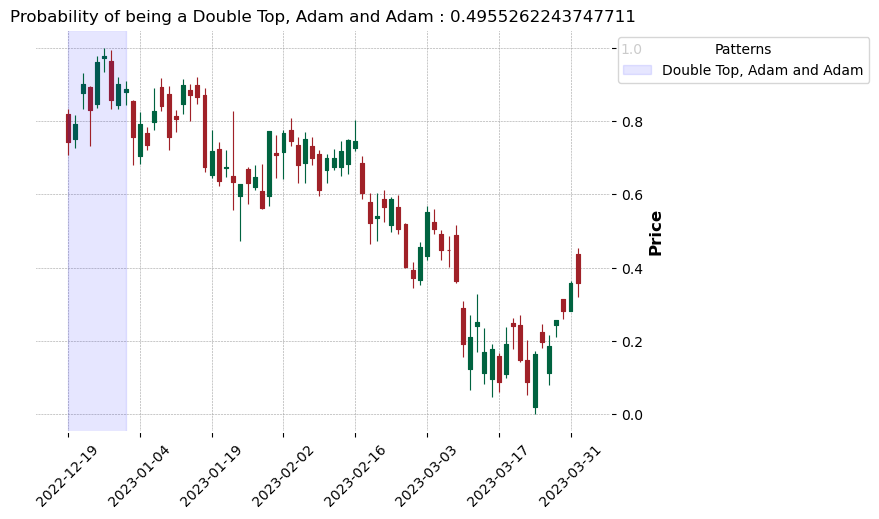

Predicted Pattern: Double Top, Adam and Adam with probability: 0.38676539063453674 in num 1 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2022-12-30 00:00:00


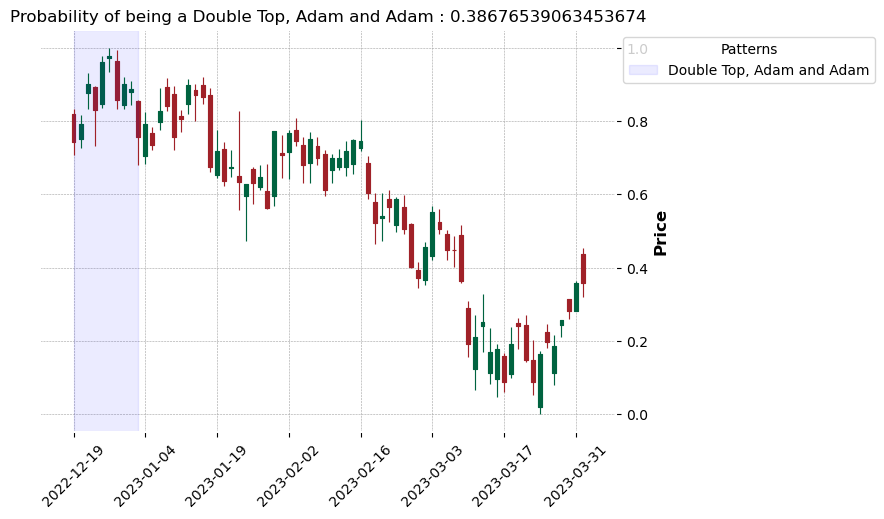

Predicted Pattern: Double Top, Adam and Adam with probability: 0.31719958782196045 in num 2 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-03 00:00:00


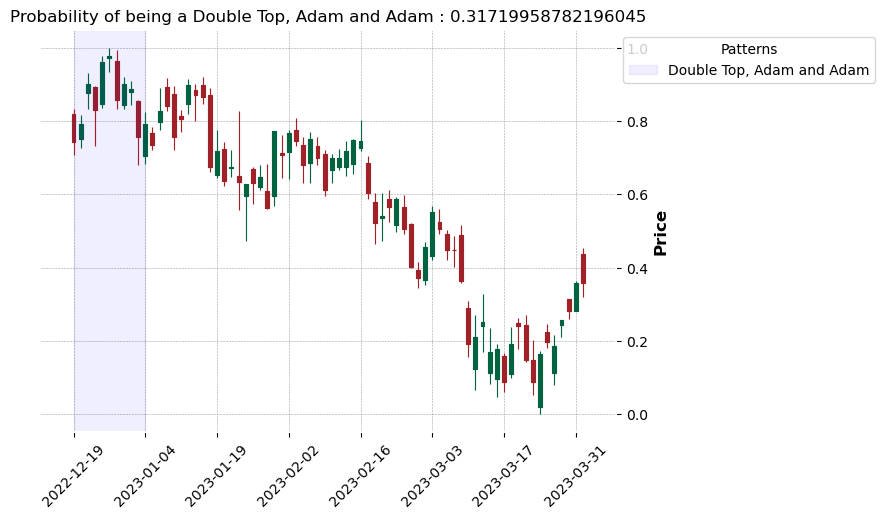

Predicted Pattern: Double Top, Adam and Adam with probability: 0.28049516677856445 in num 3 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-04 00:00:00


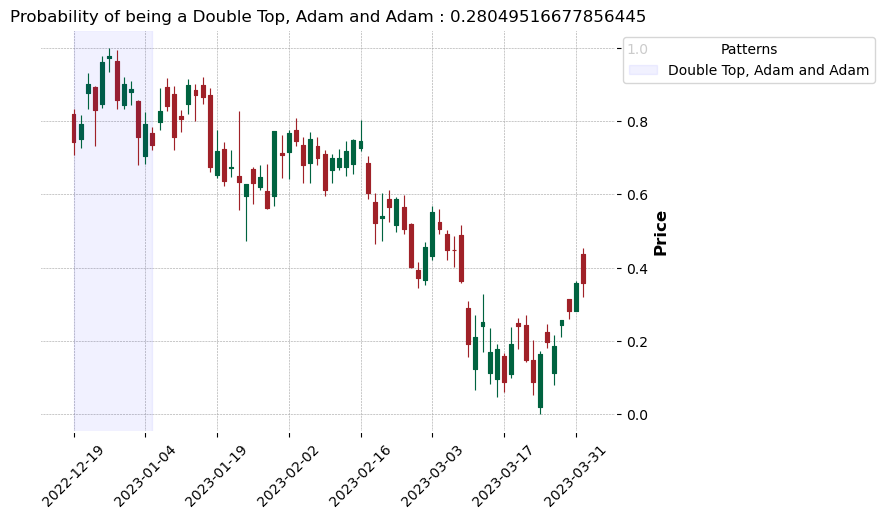

Predicted Pattern: Double Top, Adam and Adam with probability: 0.28188222646713257 in num 4 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-05 00:00:00


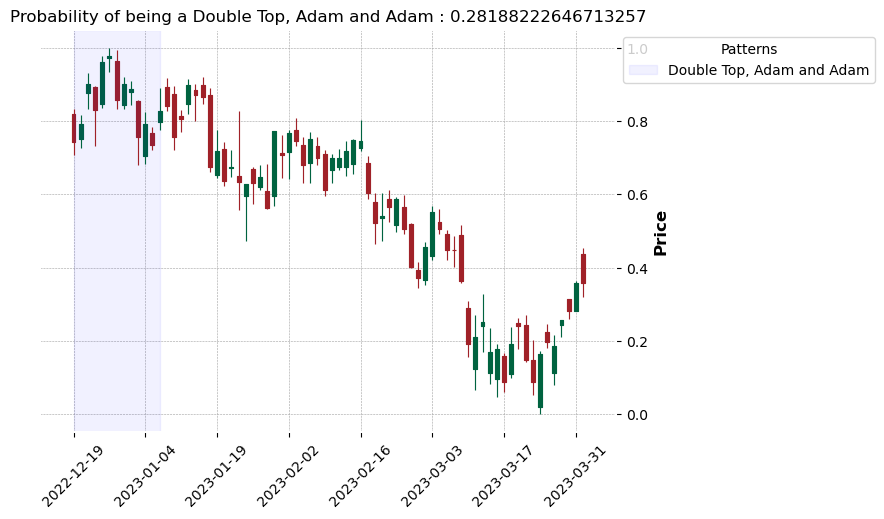

Predicted Pattern: Double Bottom, Adam and Adam with probability: 0.27847397327423096 in num 5 window
Pattern Name :  Double Bottom, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-06 00:00:00


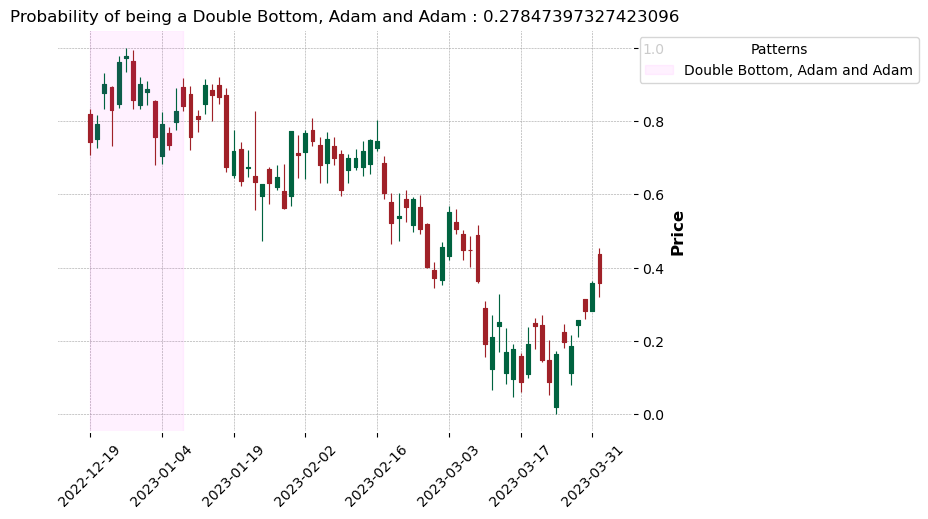

Predicted Pattern: Head-and-shoulders top with probability: 0.22255665063858032 in num 6 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-09 00:00:00


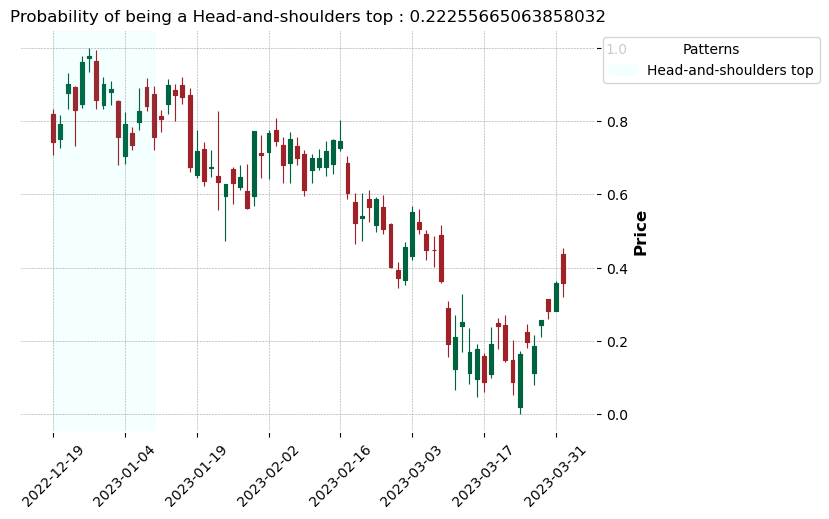

Predicted Pattern: Double Bottom, Adam and Adam with probability: 0.20981130003929138 in num 7 window
Pattern Name :  Double Bottom, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-10 00:00:00


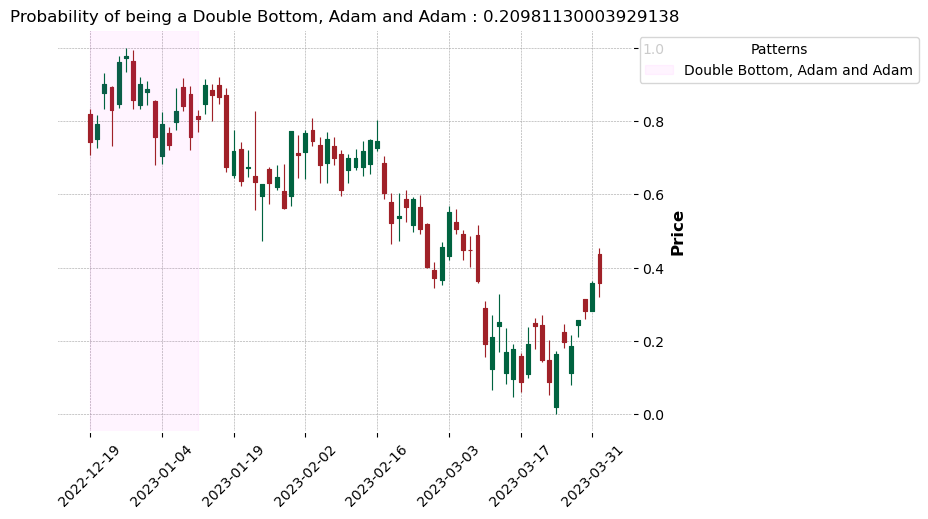

Predicted Pattern: Triangle, symmetrical with probability: 0.29724156856536865 in num 8 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-11 00:00:00


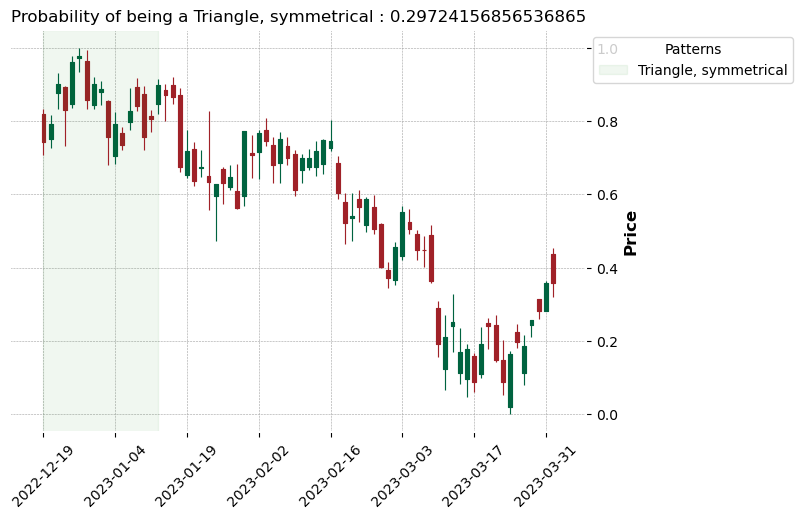

Predicted Pattern: Double Top, Adam and Adam with probability: 0.22038966417312622 in num 9 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-12 00:00:00


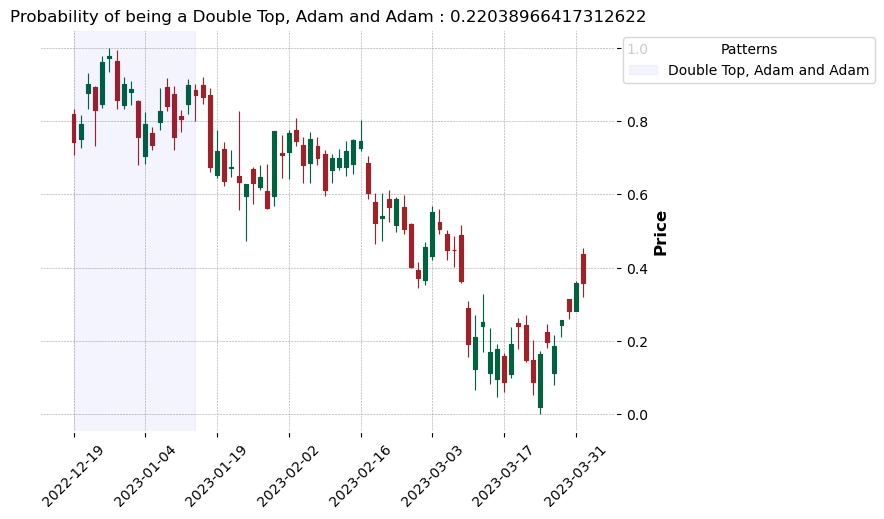

Predicted Pattern: Triangle, symmetrical with probability: 0.23044253885746002 in num 10 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-13 00:00:00


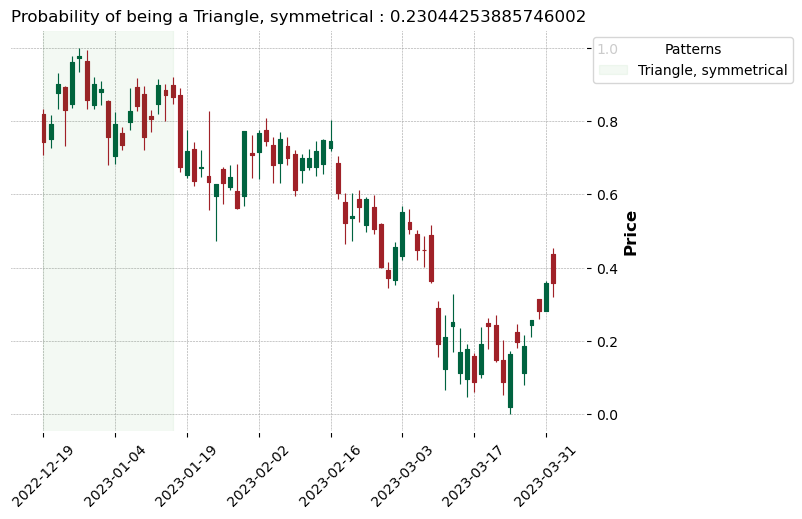

Predicted Pattern: Triangle, symmetrical with probability: 0.300804078578949 in num 11 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-17 00:00:00


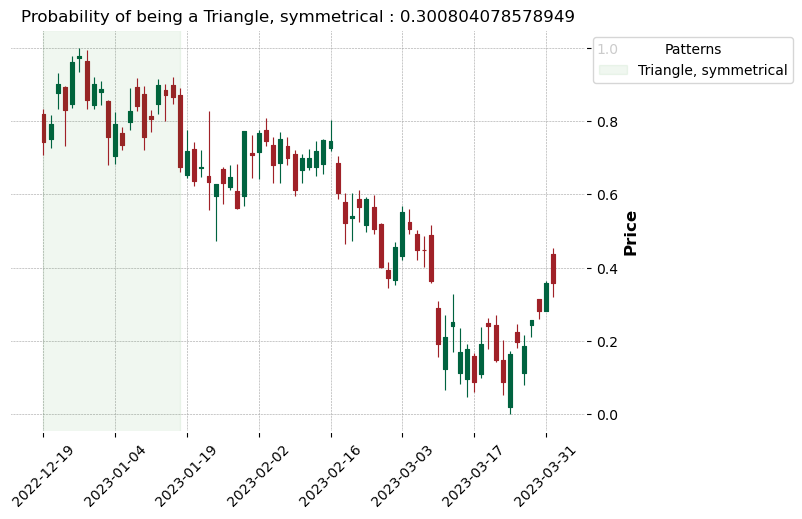

Predicted Pattern: Triangle, symmetrical with probability: 0.29171648621559143 in num 12 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-18 00:00:00


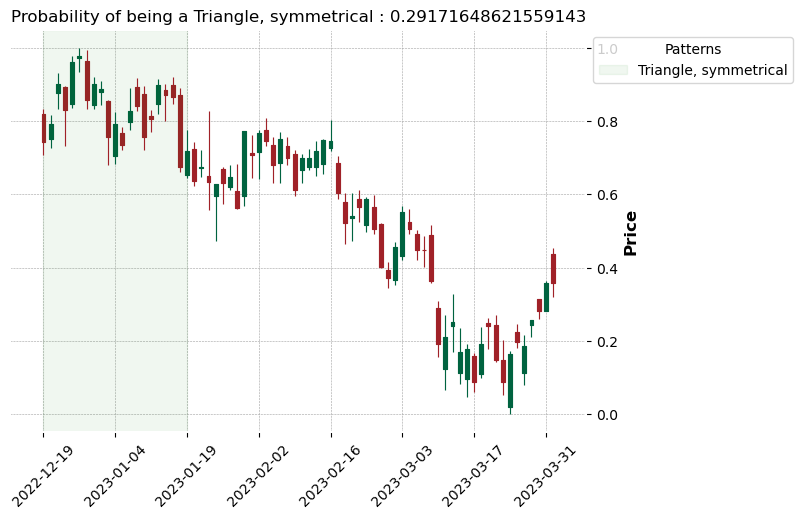

Predicted Pattern: Triangle, symmetrical with probability: 0.4002797603607178 in num 13 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-19 00:00:00


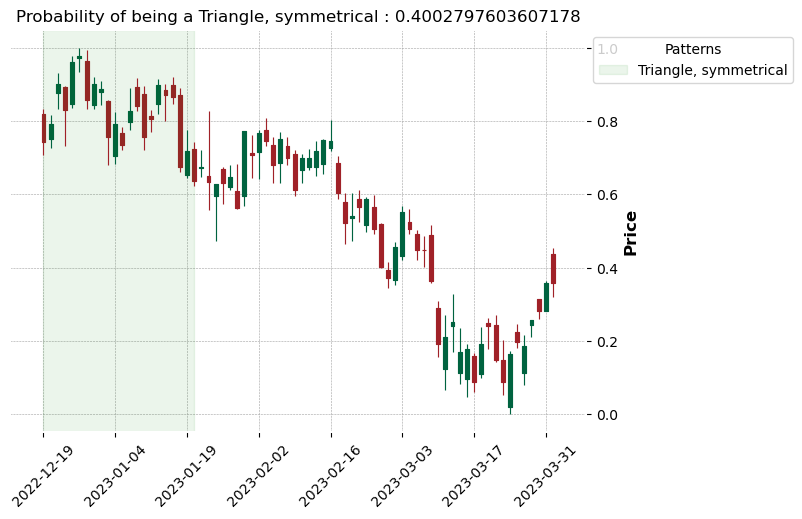

Predicted Pattern: Triangle, symmetrical with probability: 0.3323052227497101 in num 14 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-20 00:00:00 Pattern End :  2023-01-20 00:00:00


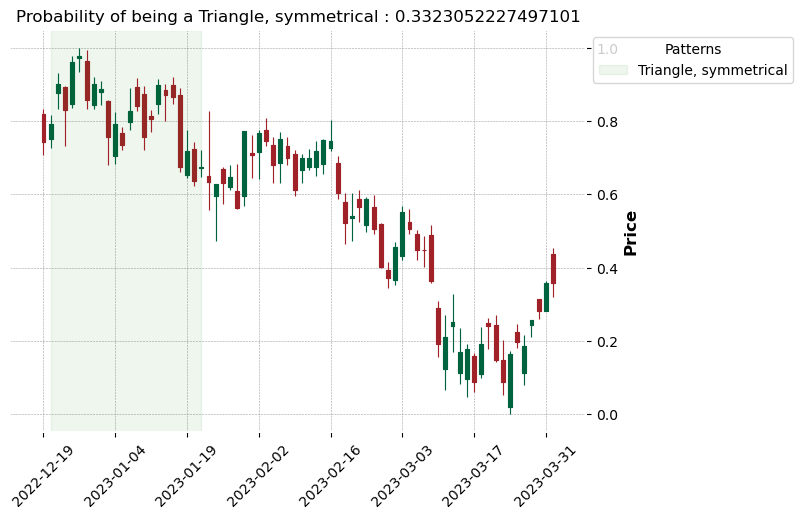

Predicted Pattern: Triangle, symmetrical with probability: 0.4265371859073639 in num 15 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-21 00:00:00 Pattern End :  2023-01-23 00:00:00


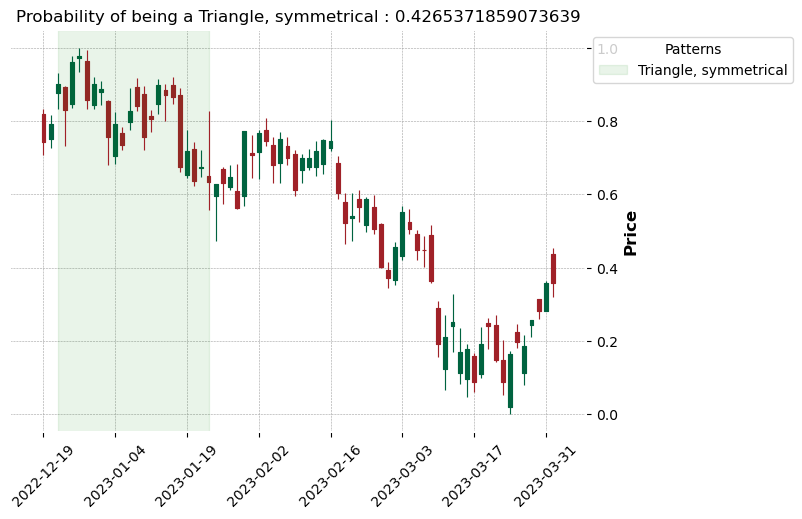

Predicted Pattern: Head-and-shoulders top with probability: 0.40022170543670654 in num 16 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2022-12-22 00:00:00 Pattern End :  2023-01-24 00:00:00


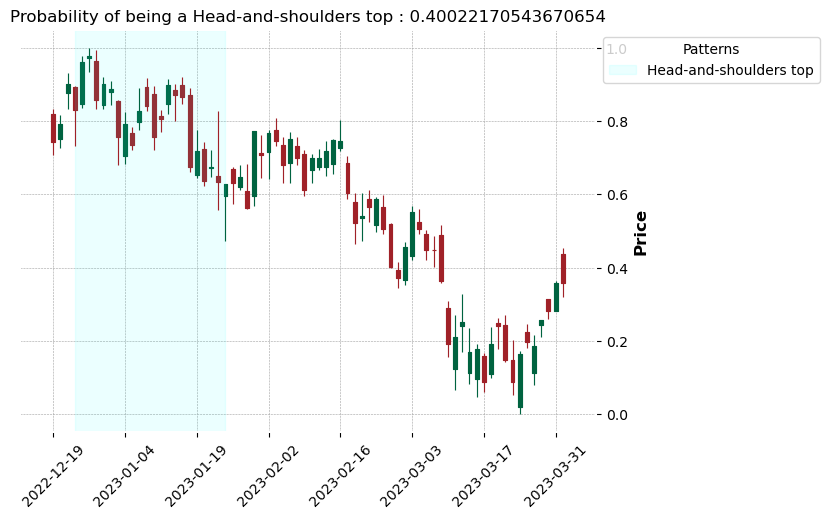

Predicted Pattern: Head-and-shoulders top with probability: 0.3774861991405487 in num 17 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2022-12-23 00:00:00 Pattern End :  2023-01-25 00:00:00


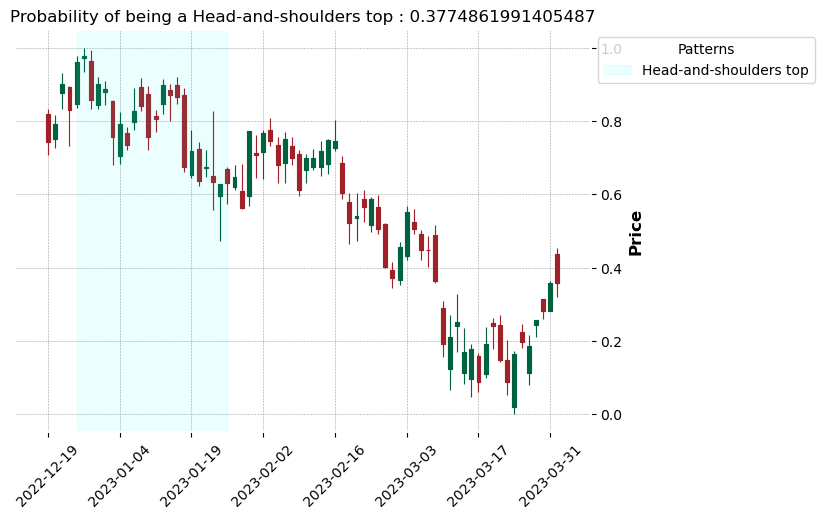

Predicted Pattern: Head-and-shoulders top with probability: 0.39095205068588257 in num 18 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2022-12-27 00:00:00 Pattern End :  2023-01-26 00:00:00


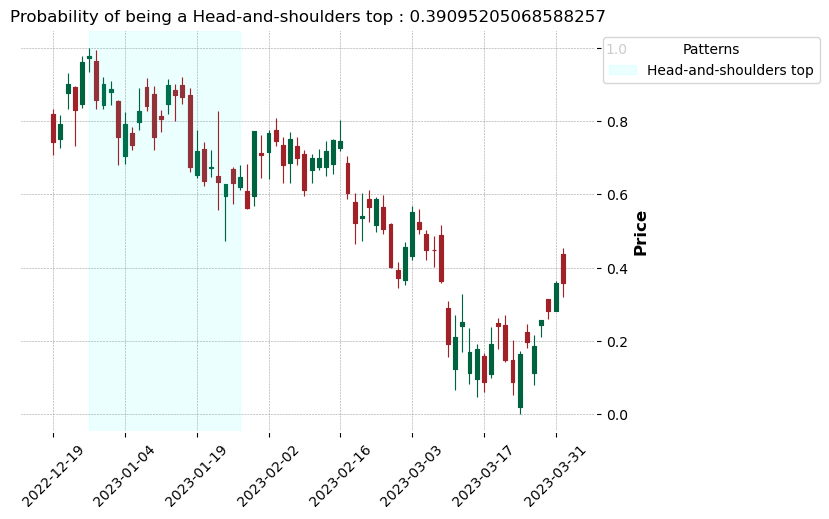

Predicted Pattern: Triangle, symmetrical with probability: 0.40069717168807983 in num 19 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-28 00:00:00 Pattern End :  2023-01-27 00:00:00


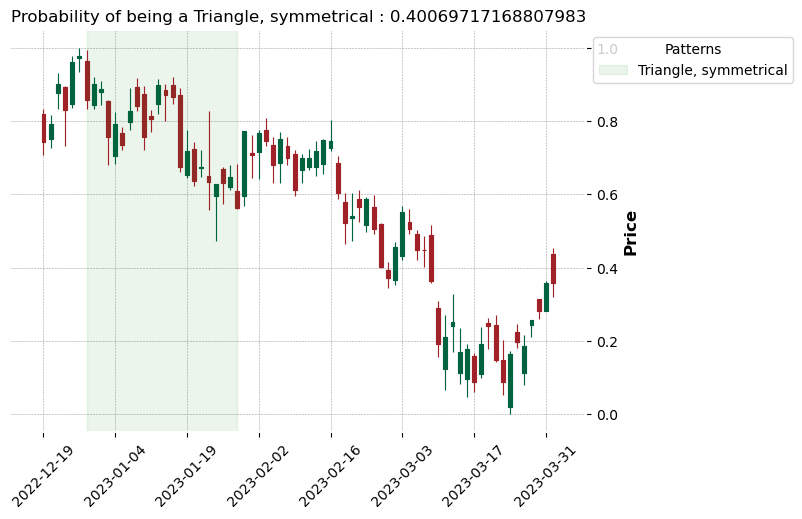

Predicted Pattern: Head-and-shoulders top with probability: 0.3744797706604004 in num 20 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2022-12-29 00:00:00 Pattern End :  2023-01-30 00:00:00


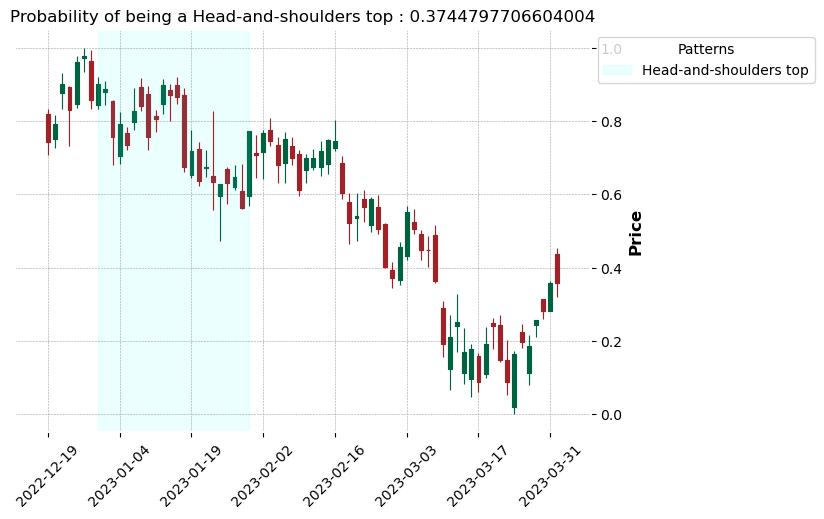

Predicted Pattern: Head-and-shoulders top with probability: 0.36318761110305786 in num 21 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2022-12-30 00:00:00 Pattern End :  2023-01-31 00:00:00


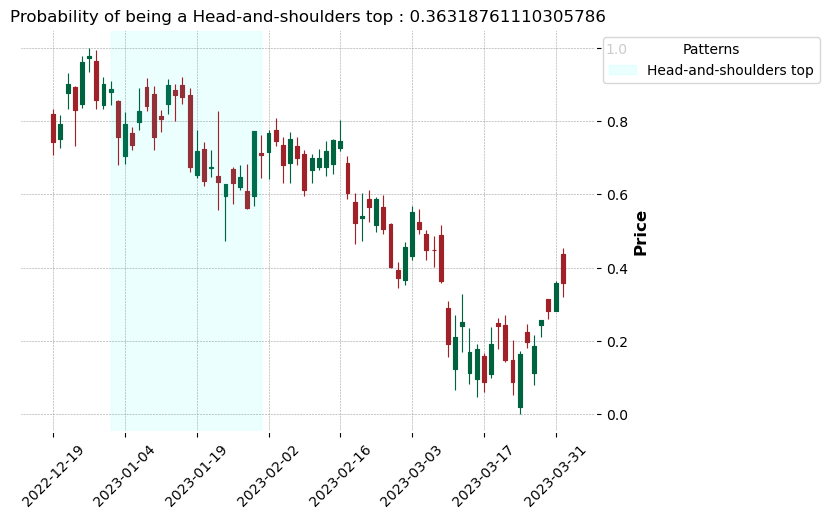

Predicted Pattern: Triangle, symmetrical with probability: 0.4385794401168823 in num 22 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-03 00:00:00 Pattern End :  2023-02-01 00:00:00


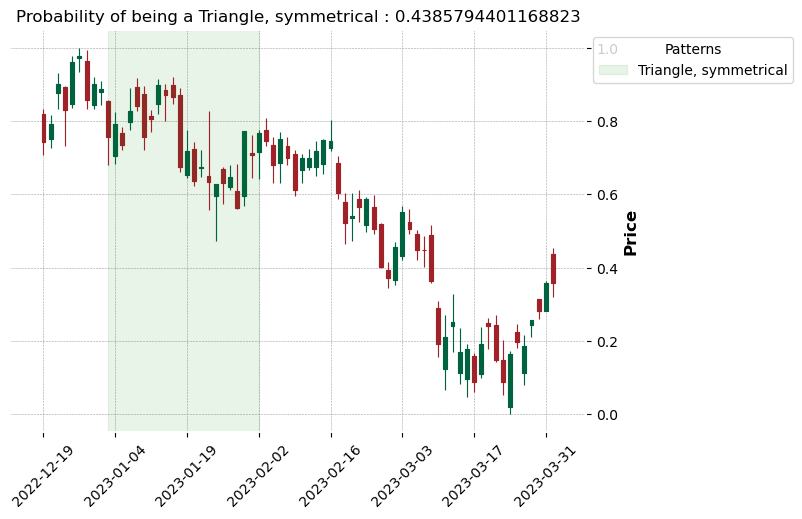

Predicted Pattern: Triangle, symmetrical with probability: 0.35479116439819336 in num 23 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-04 00:00:00 Pattern End :  2023-02-02 00:00:00


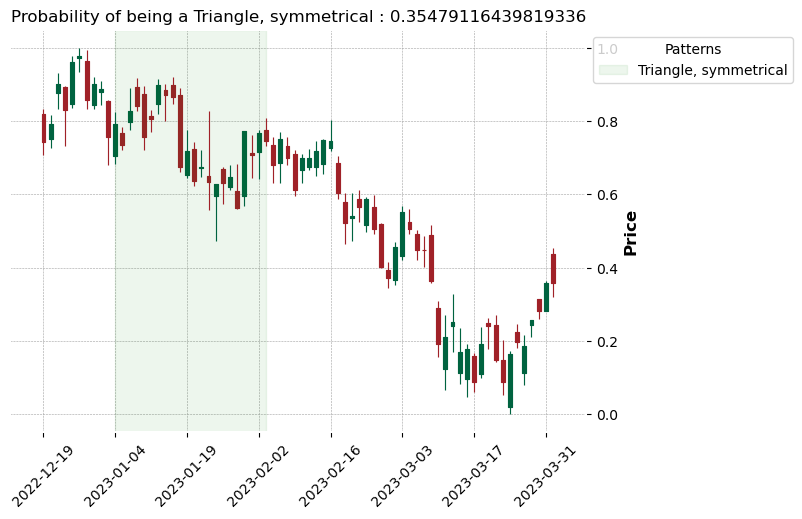

Predicted Pattern: Triangle, symmetrical with probability: 0.45907512307167053 in num 24 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-05 00:00:00 Pattern End :  2023-02-03 00:00:00


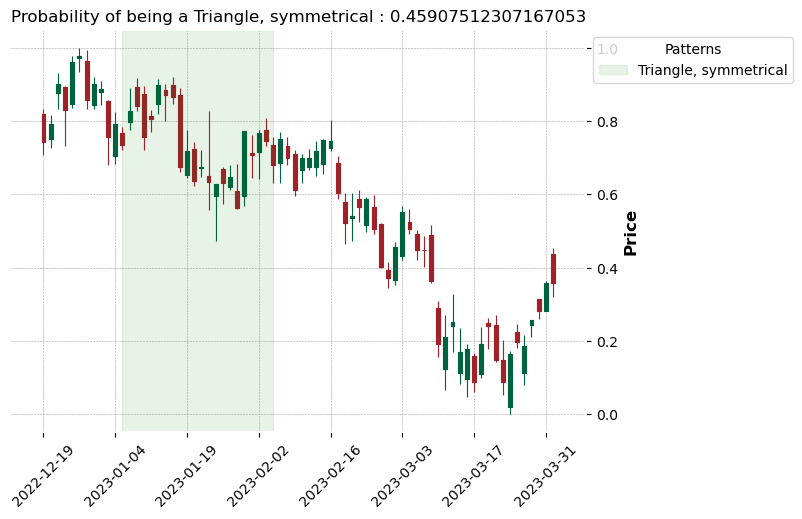

Predicted Pattern: Triangle, symmetrical with probability: 0.4624437391757965 in num 25 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-06 00:00:00 Pattern End :  2023-02-06 00:00:00


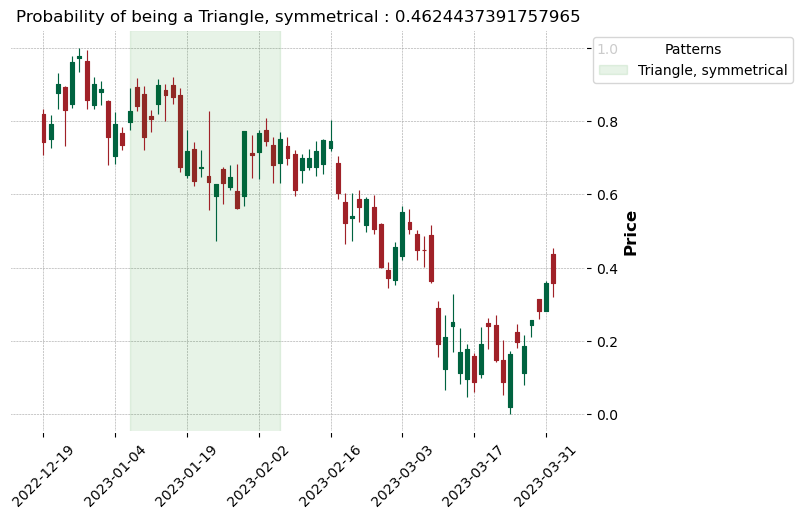

Predicted Pattern: Triangle, symmetrical with probability: 0.4373093545436859 in num 26 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-09 00:00:00 Pattern End :  2023-02-07 00:00:00


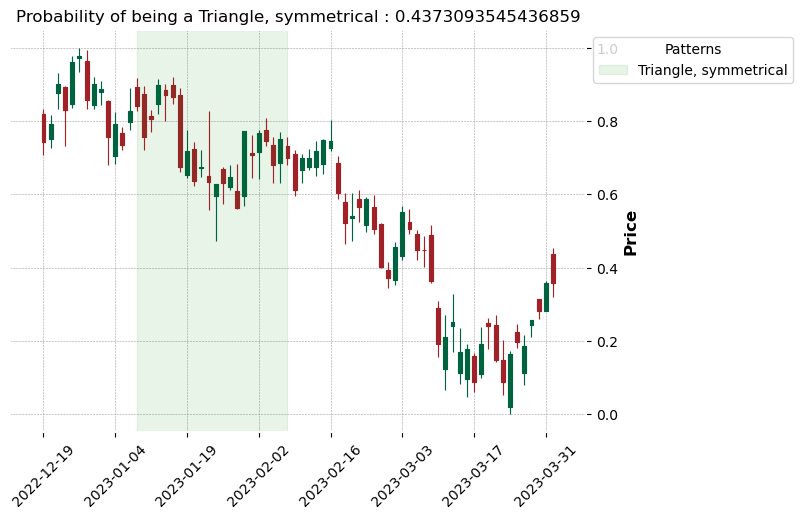

Predicted Pattern: Triangle, symmetrical with probability: 0.4267489016056061 in num 27 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-10 00:00:00 Pattern End :  2023-02-08 00:00:00


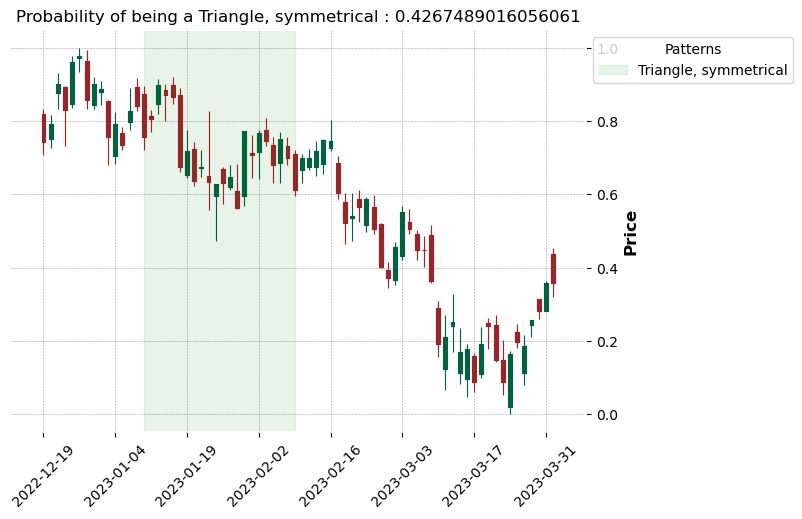

Predicted Pattern: Triangle, symmetrical with probability: 0.4733719229698181 in num 28 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-11 00:00:00 Pattern End :  2023-02-09 00:00:00


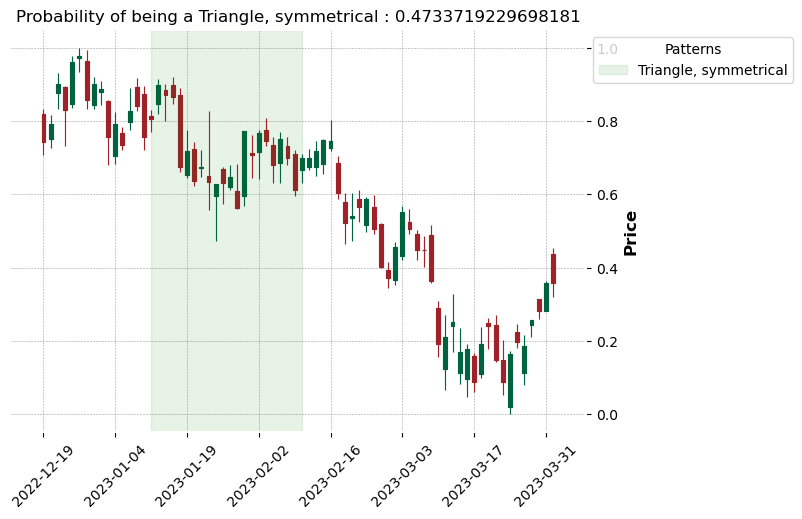

Predicted Pattern: Triangle, symmetrical with probability: 0.49427157640457153 in num 29 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-12 00:00:00 Pattern End :  2023-02-10 00:00:00


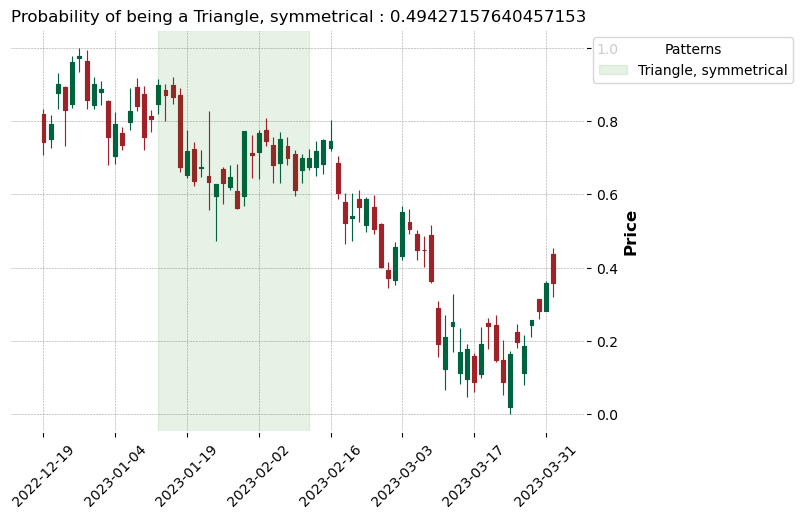

Predicted Pattern: Triangle, symmetrical with probability: 0.5971288084983826 in num 30 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-13 00:00:00 Pattern End :  2023-02-13 00:00:00


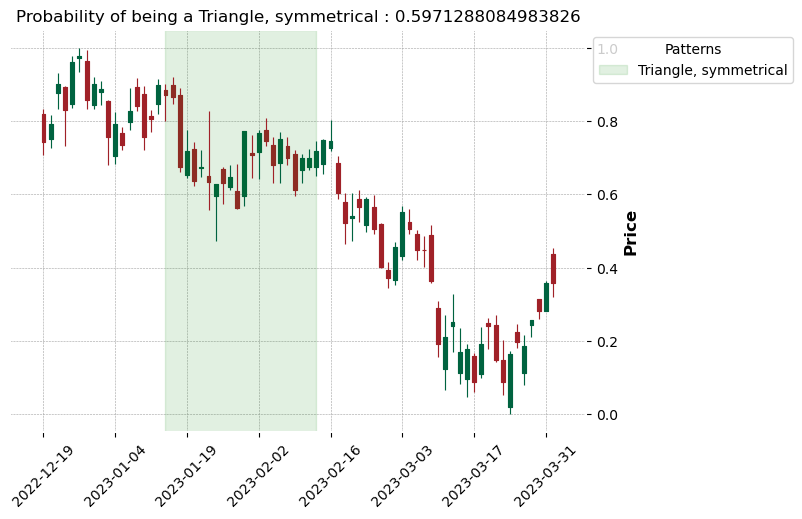

Predicted Pattern: Triangle, symmetrical with probability: 0.5309031009674072 in num 31 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-14 00:00:00


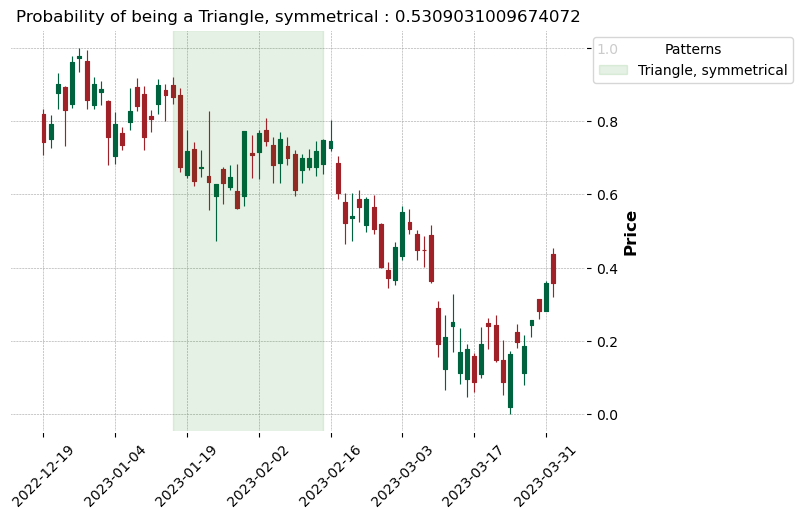

Predicted Pattern: Triangle, symmetrical with probability: 0.43538761138916016 in num 32 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-18 00:00:00 Pattern End :  2023-02-15 00:00:00


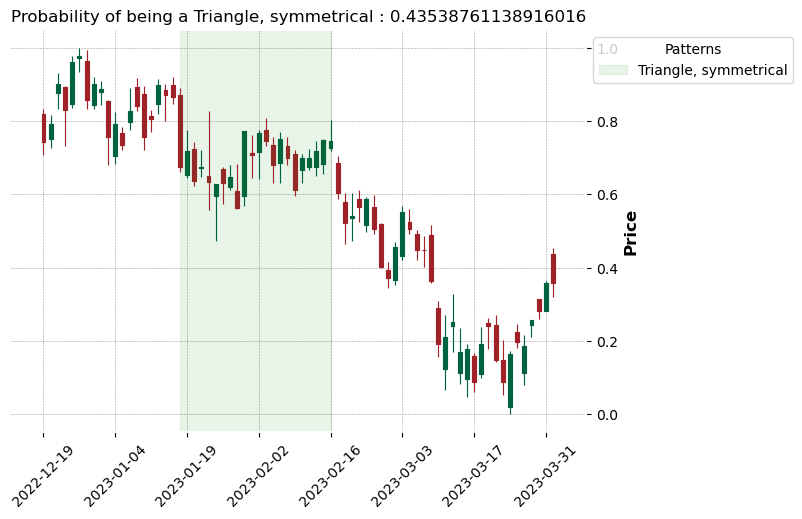

Predicted Pattern: Triangle, symmetrical with probability: 0.5322797298431396 in num 33 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-19 00:00:00 Pattern End :  2023-02-16 00:00:00


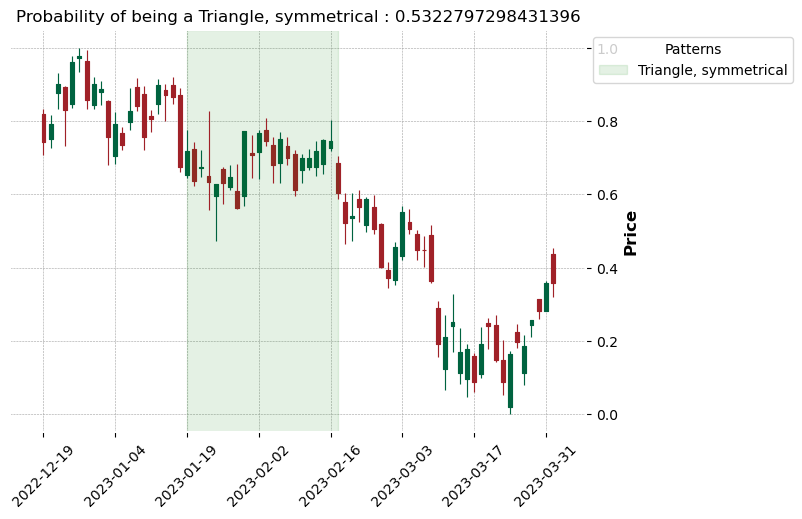

Predicted Pattern: Triangle, symmetrical with probability: 0.6021022200584412 in num 34 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-20 00:00:00 Pattern End :  2023-02-17 00:00:00


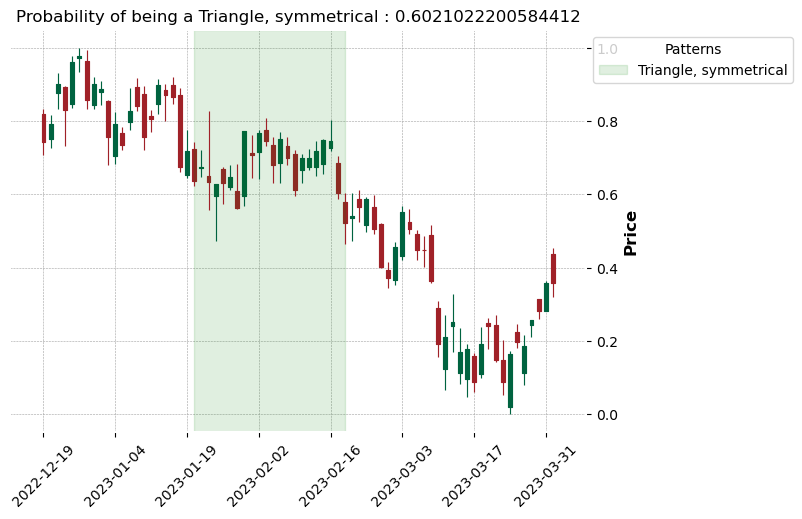

Predicted Pattern: Triangle, symmetrical with probability: 0.48434755206108093 in num 35 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-23 00:00:00 Pattern End :  2023-02-21 00:00:00


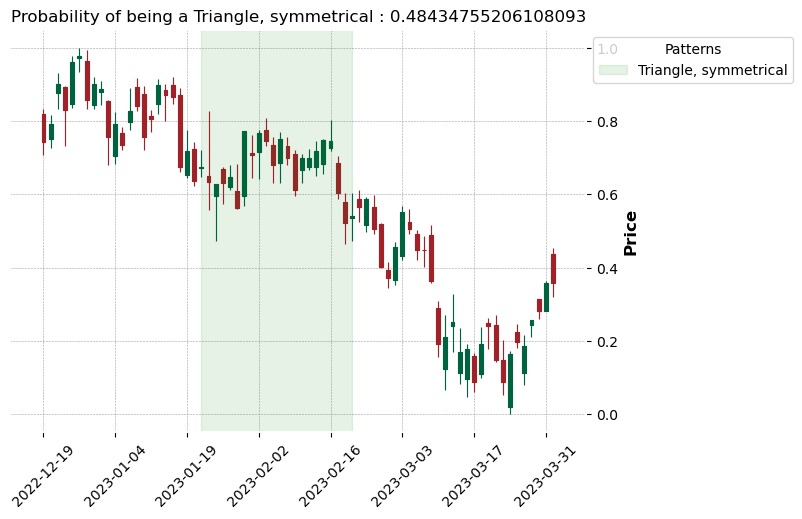

Predicted Pattern: Triangle, symmetrical with probability: 0.38198715448379517 in num 36 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-24 00:00:00 Pattern End :  2023-02-22 00:00:00


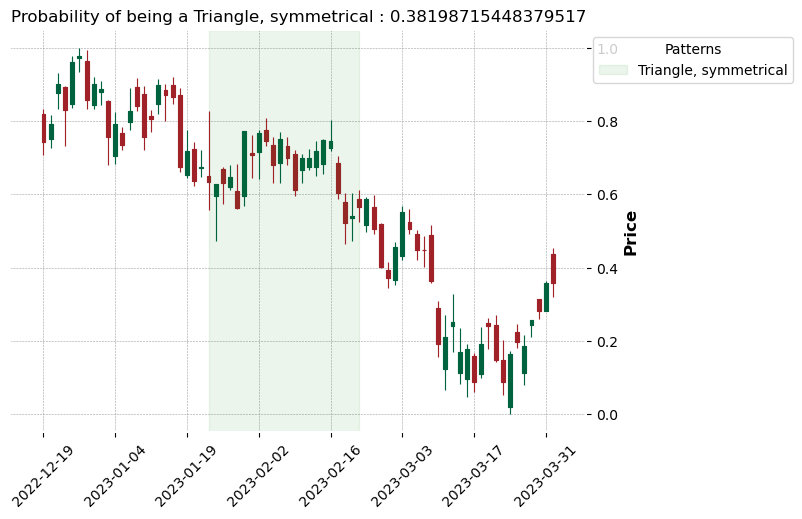

Predicted Pattern: Triangle, symmetrical with probability: 0.38385656476020813 in num 37 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-25 00:00:00 Pattern End :  2023-02-23 00:00:00


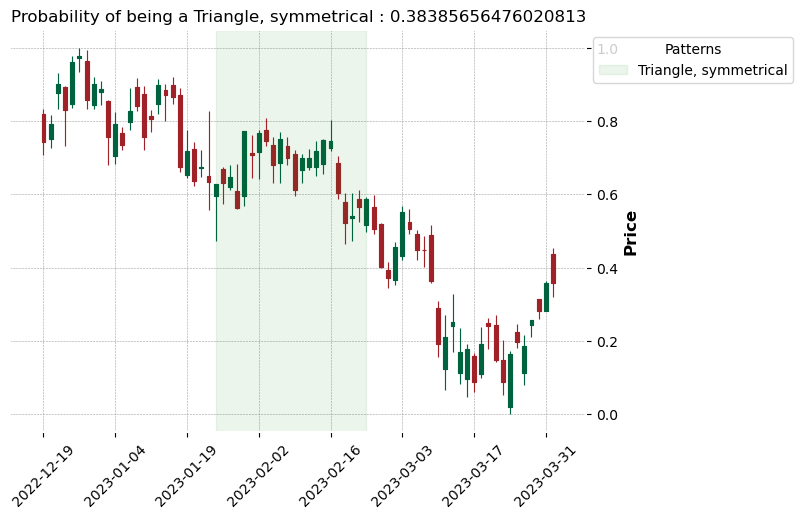

Predicted Pattern: Triangle, symmetrical with probability: 0.4279313087463379 in num 38 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-26 00:00:00 Pattern End :  2023-02-24 00:00:00


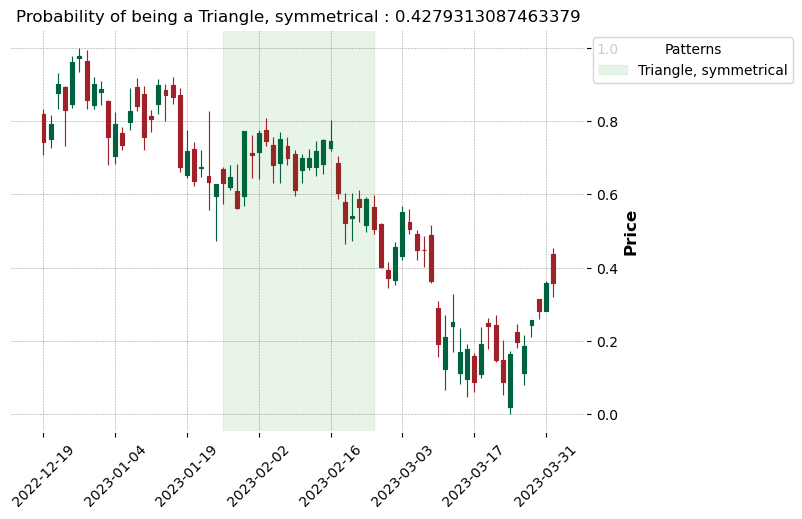

Predicted Pattern: Triangle, symmetrical with probability: 0.41984114050865173 in num 39 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-27 00:00:00 Pattern End :  2023-02-27 00:00:00


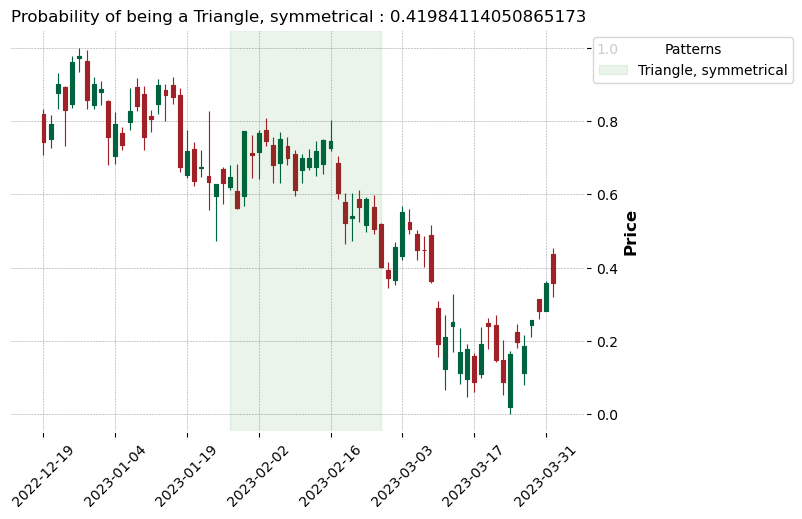

Predicted Pattern: Triangle, symmetrical with probability: 0.3940146565437317 in num 40 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-01-30 00:00:00 Pattern End :  2023-02-28 00:00:00


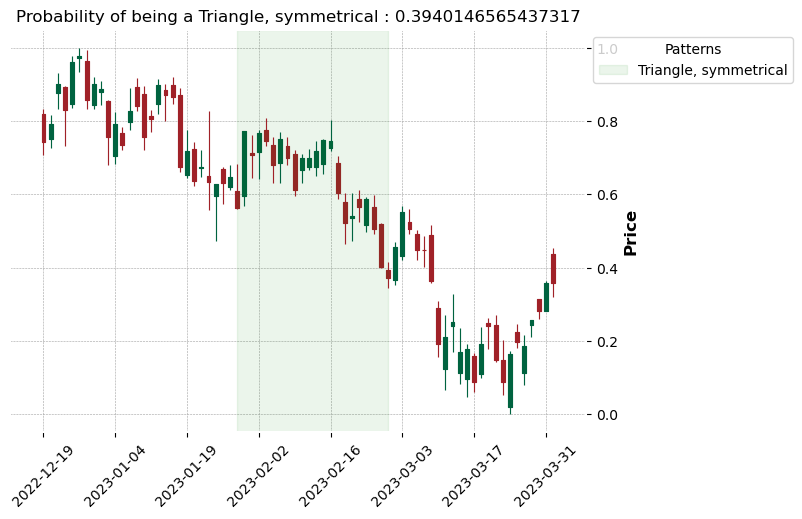

Predicted Pattern: Head-and-shoulders top with probability: 0.5078179240226746 in num 41 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-31 00:00:00 Pattern End :  2023-03-01 00:00:00


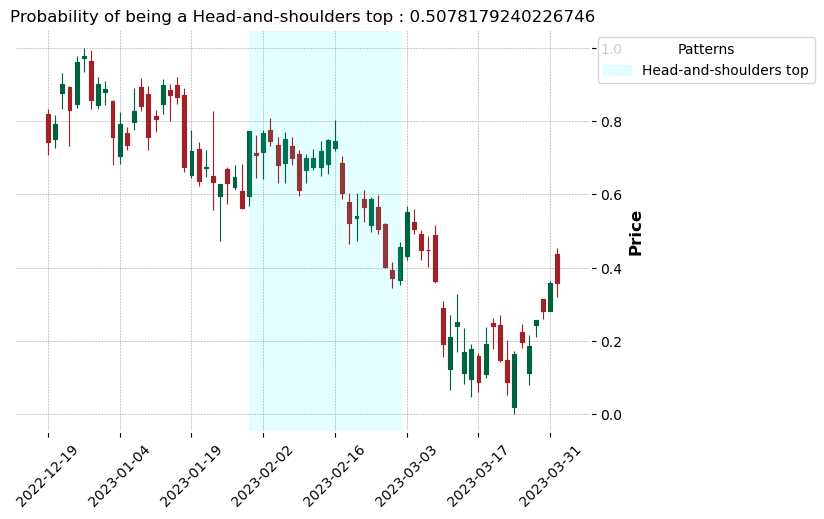

Predicted Pattern: Triangle, symmetrical with probability: 0.43954572081565857 in num 42 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-01 00:00:00 Pattern End :  2023-03-02 00:00:00


Predicted Pattern: Triangle, symmetrical with probability: 0.45624810457229614 in num 43 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-02 00:00:00 Pattern End :  2023-03-03 00:00:00


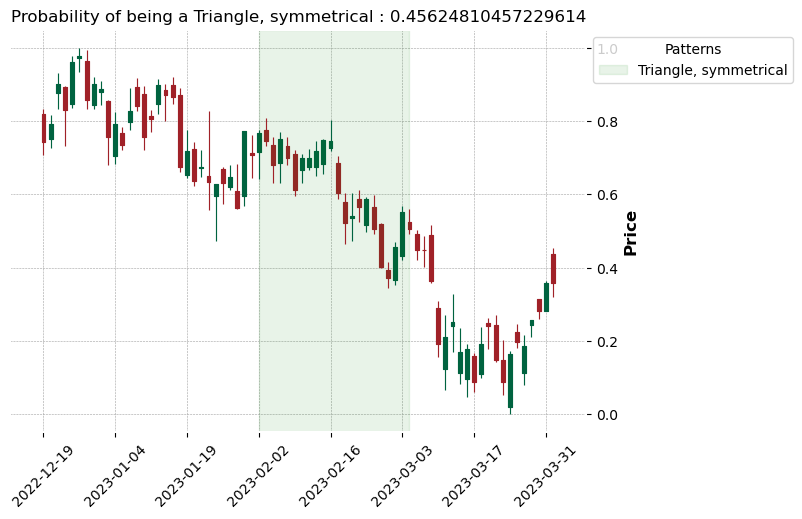

Predicted Pattern: Head-and-shoulders top with probability: 0.3726958632469177 in num 44 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-02-03 00:00:00 Pattern End :  2023-03-06 00:00:00


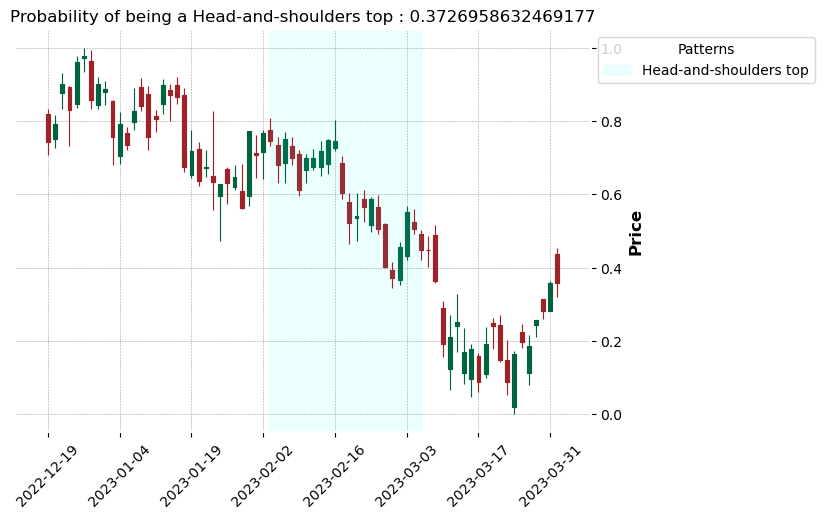

Predicted Pattern: Triangle, symmetrical with probability: 0.44409653544425964 in num 45 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-06 00:00:00 Pattern End :  2023-03-07 00:00:00


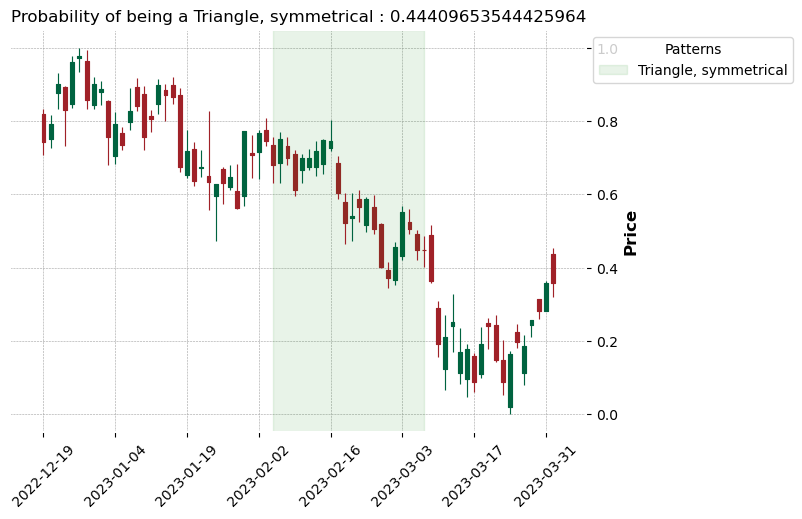

Predicted Pattern: Triangle, symmetrical with probability: 0.45642781257629395 in num 46 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-07 00:00:00 Pattern End :  2023-03-08 00:00:00


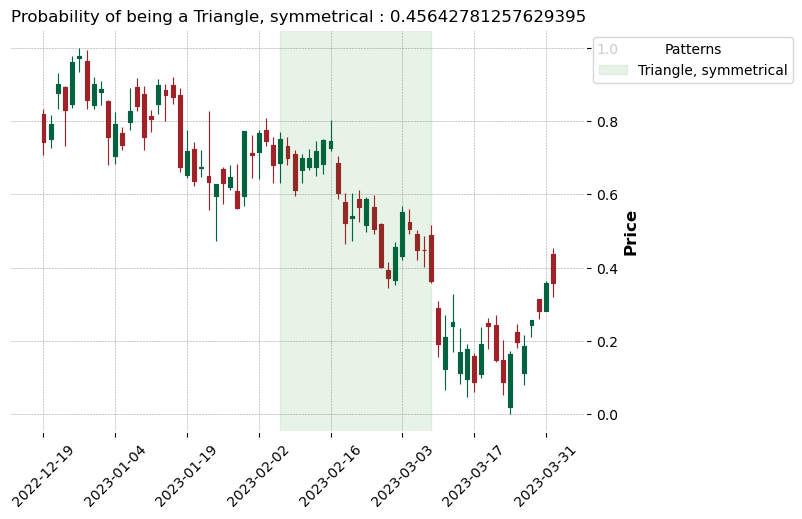

Predicted Pattern: Triangle, symmetrical with probability: 0.4192947447299957 in num 47 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-08 00:00:00 Pattern End :  2023-03-09 00:00:00


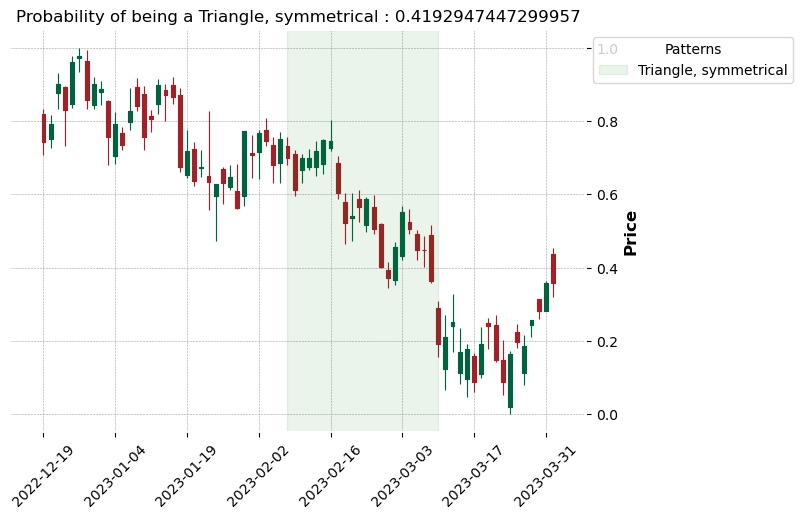

Predicted Pattern: Triangle, symmetrical with probability: 0.411751389503479 in num 48 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-09 00:00:00 Pattern End :  2023-03-10 00:00:00


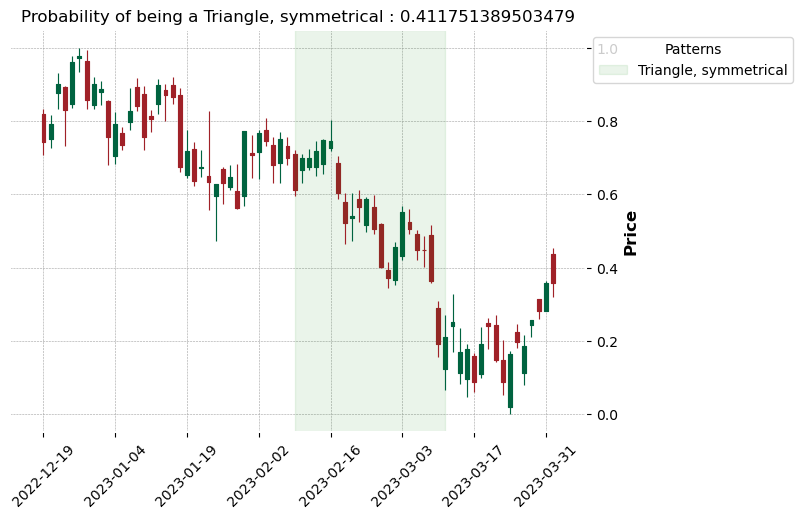

Predicted Pattern: Triangle, symmetrical with probability: 0.35650572180747986 in num 49 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-10 00:00:00 Pattern End :  2023-03-13 00:00:00


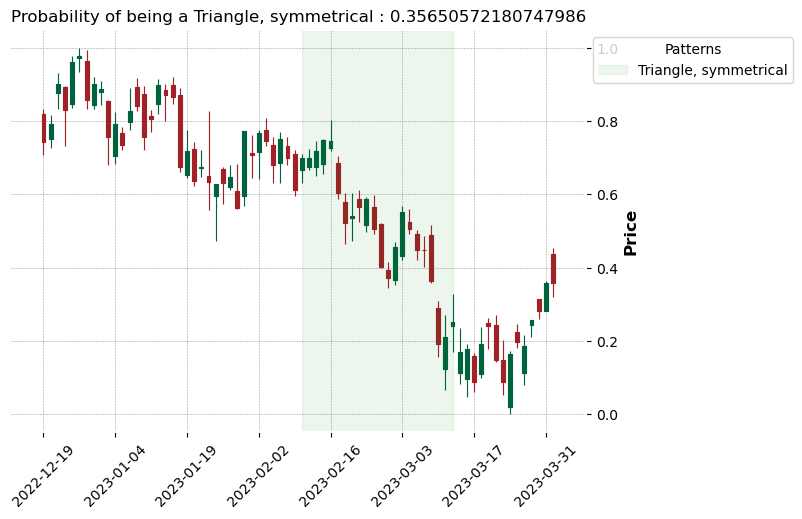

Predicted Pattern: Triangle, symmetrical with probability: 0.26545029878616333 in num 50 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-13 00:00:00 Pattern End :  2023-03-14 00:00:00


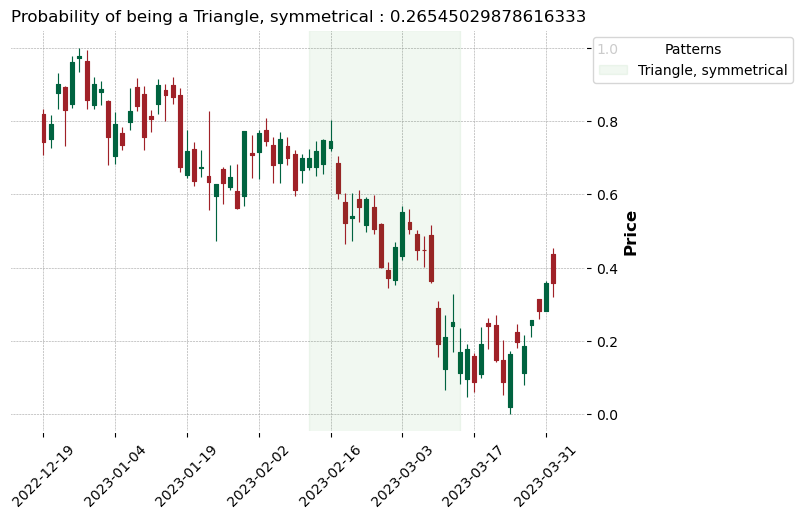

Predicted Pattern: Triangle, symmetrical with probability: 0.32347872853279114 in num 51 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-14 00:00:00 Pattern End :  2023-03-15 00:00:00


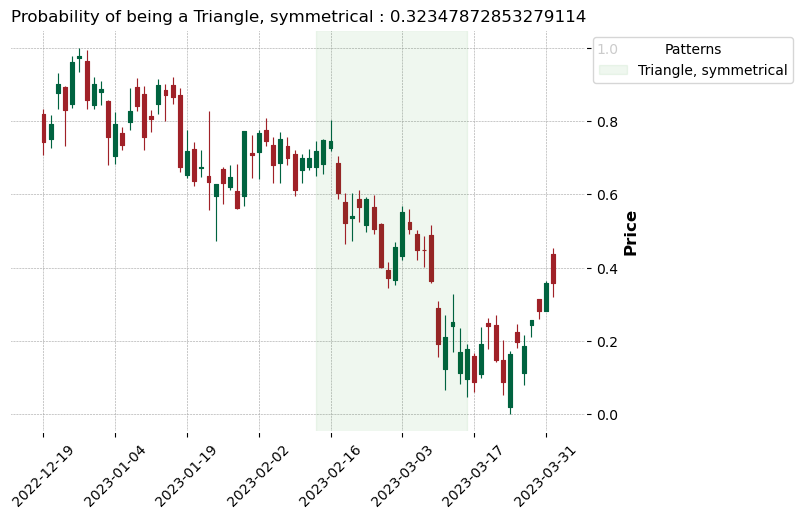

Predicted Pattern: Triangle, symmetrical with probability: 0.3442426323890686 in num 52 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-15 00:00:00 Pattern End :  2023-03-16 00:00:00


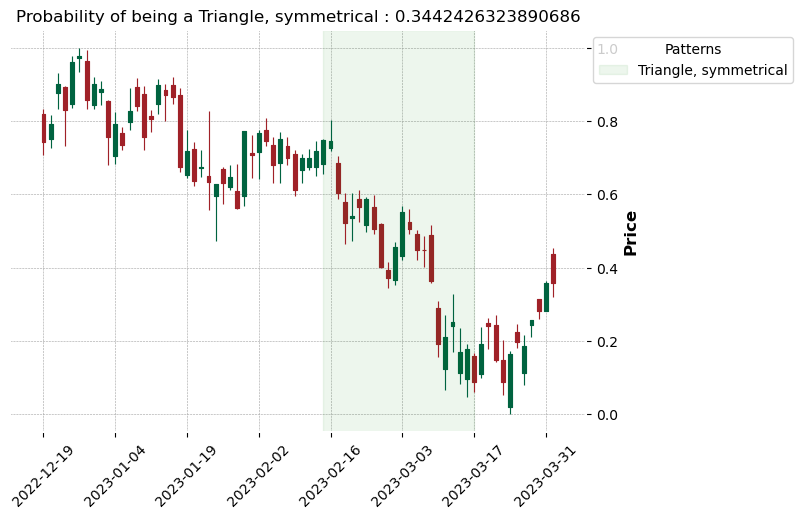

Predicted Pattern: Triangle, symmetrical with probability: 0.2963477671146393 in num 53 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-16 00:00:00 Pattern End :  2023-03-17 00:00:00


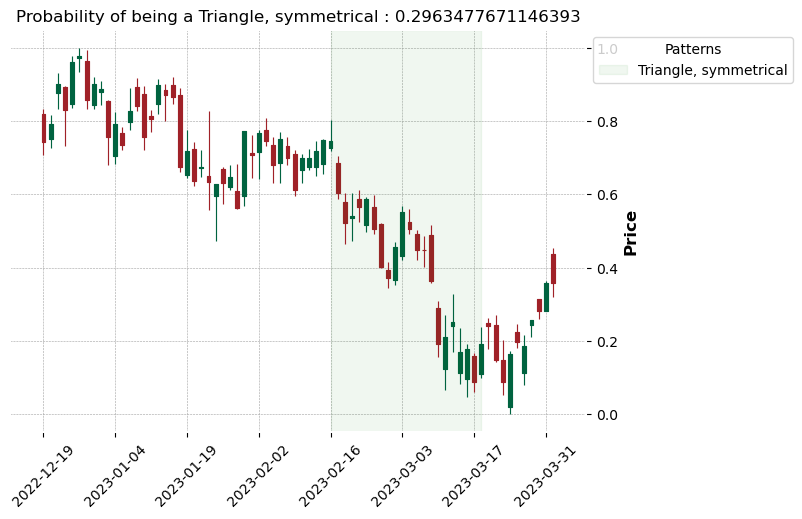

Predicted Pattern: Triangle, symmetrical with probability: 0.3097400665283203 in num 54 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-17 00:00:00 Pattern End :  2023-03-20 00:00:00


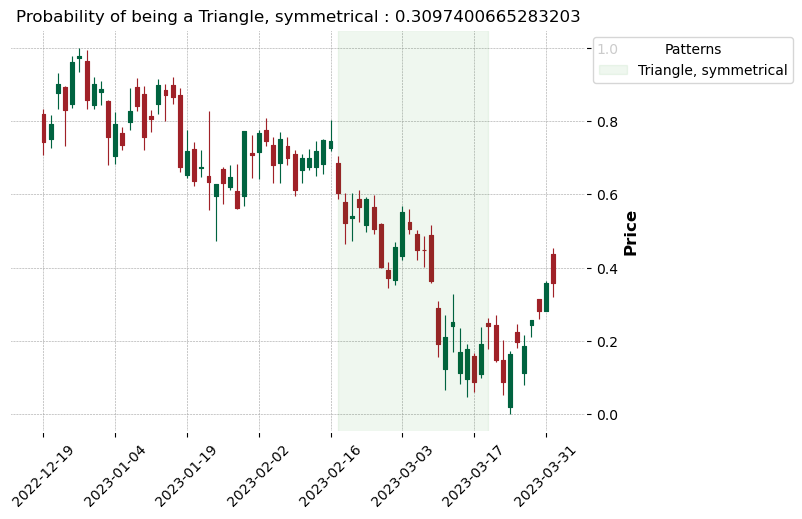

Predicted Pattern: Triangle, symmetrical with probability: 0.2899545431137085 in num 55 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-21 00:00:00 Pattern End :  2023-03-21 00:00:00


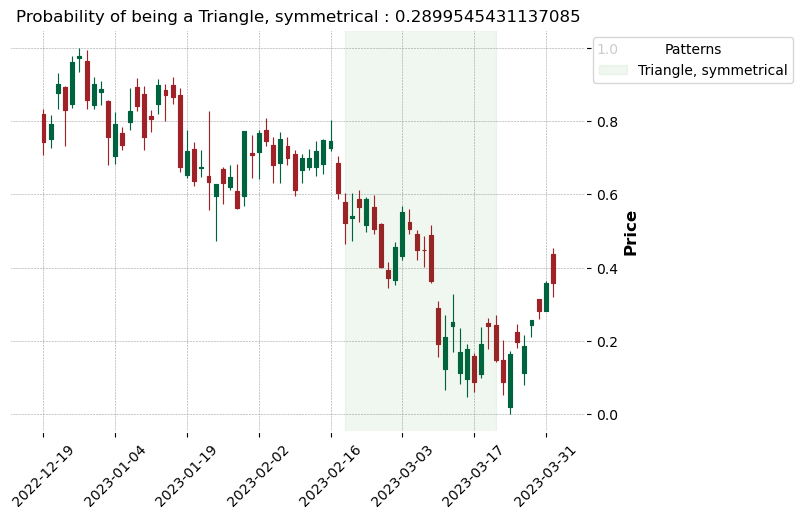

Predicted Pattern: Head-and-shoulders top with probability: 0.2689266502857208 in num 56 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-02-22 00:00:00 Pattern End :  2023-03-22 00:00:00


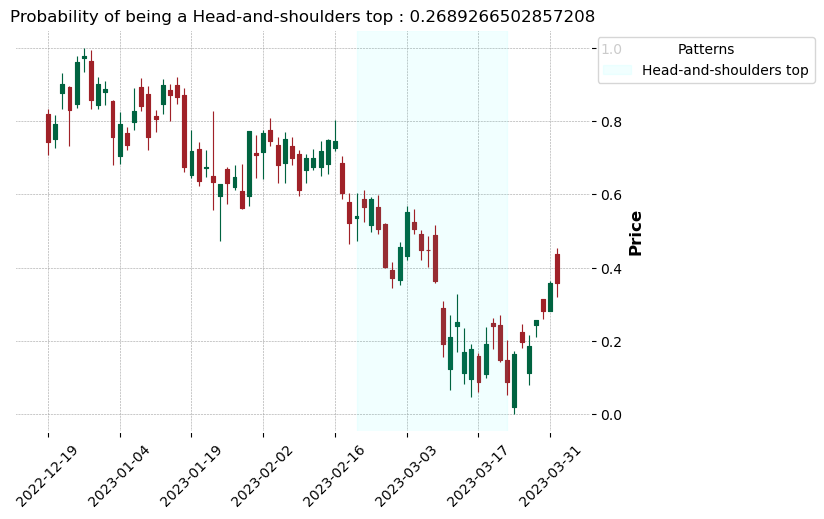

Predicted Pattern: Triangle, symmetrical with probability: 0.285523921251297 in num 57 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-23 00:00:00 Pattern End :  2023-03-23 00:00:00


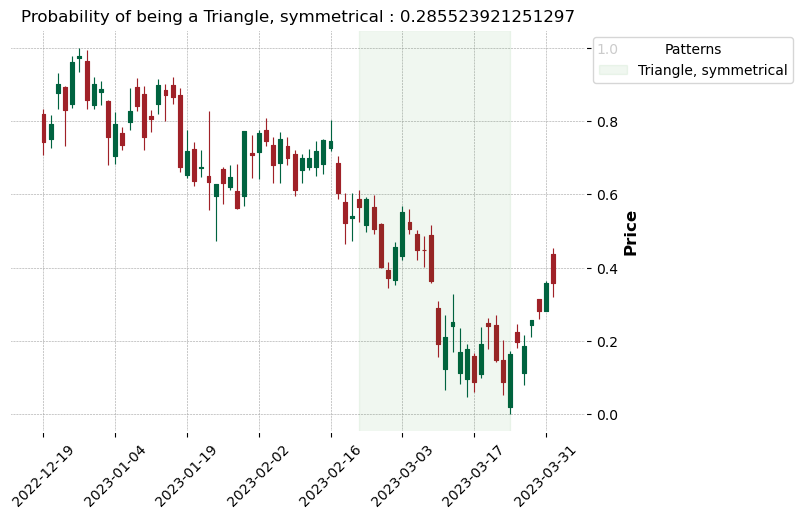

Predicted Pattern: Triangle, symmetrical with probability: 0.24489906430244446 in num 58 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-24 00:00:00 Pattern End :  2023-03-24 00:00:00


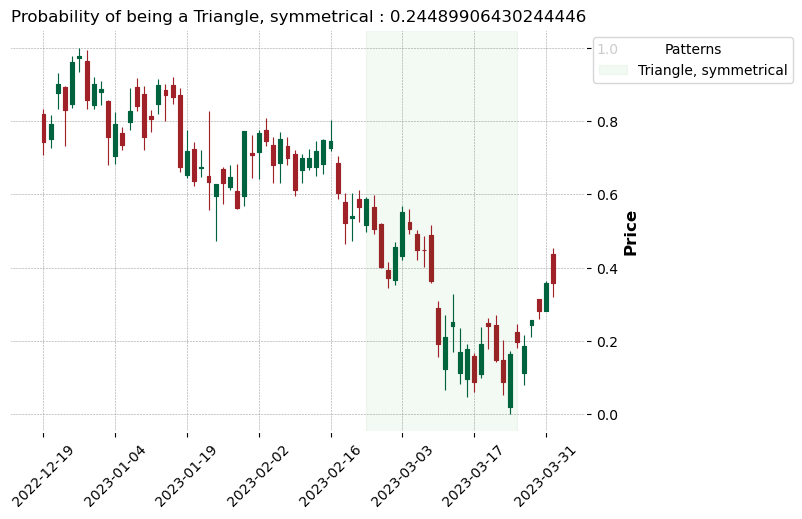

Predicted Pattern: Triangle, symmetrical with probability: 0.33175981044769287 in num 59 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-27 00:00:00 Pattern End :  2023-03-27 00:00:00


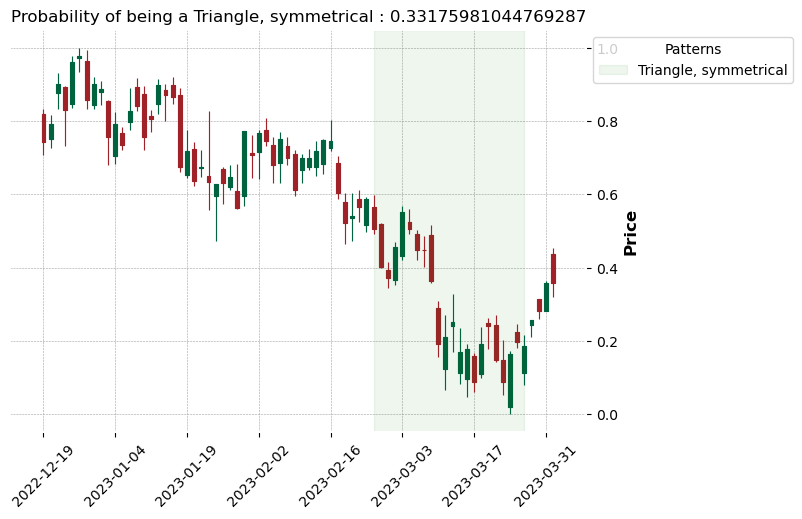

Predicted Pattern: Triangle, symmetrical with probability: 0.32604554295539856 in num 60 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-28 00:00:00 Pattern End :  2023-03-28 00:00:00


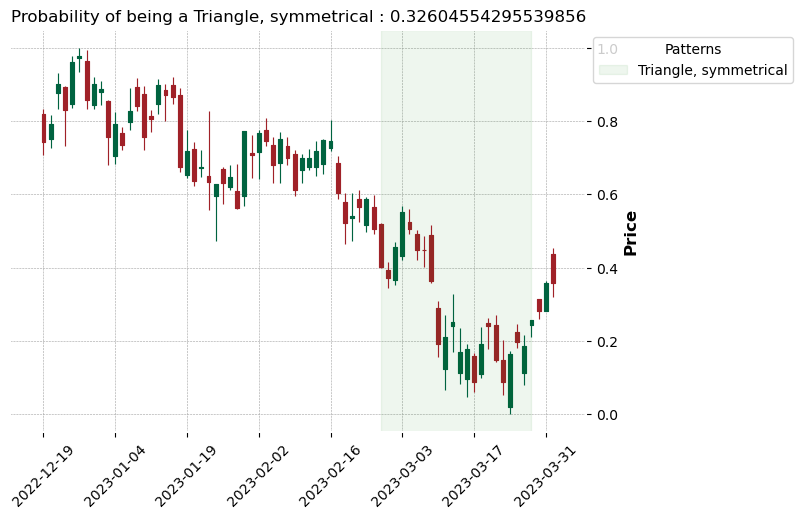

Predicted Pattern: Triangle, symmetrical with probability: 0.29416653513908386 in num 61 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-03-01 00:00:00 Pattern End :  2023-03-29 00:00:00


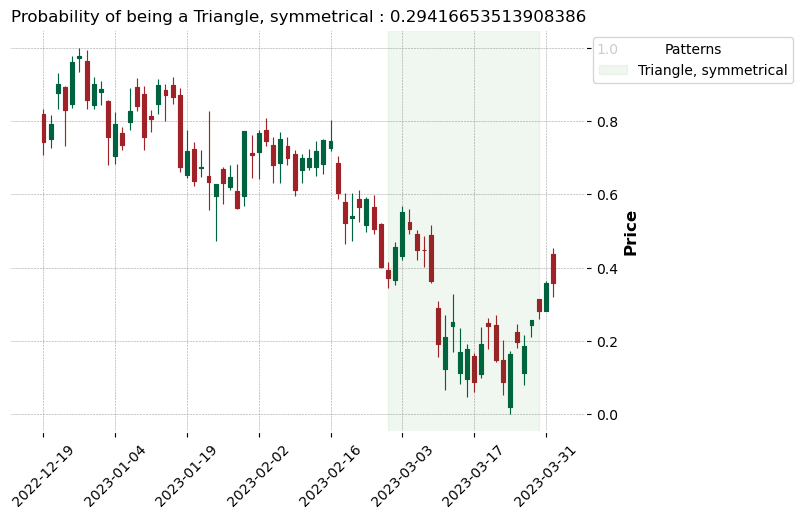

Predicted Pattern: Head-and-shoulders bottom with probability: 0.26955509185791016 in num 62 window
Pattern Name :  Head-and-shoulders bottom Pattern Start :  2023-03-02 00:00:00 Pattern End :  2023-03-30 00:00:00


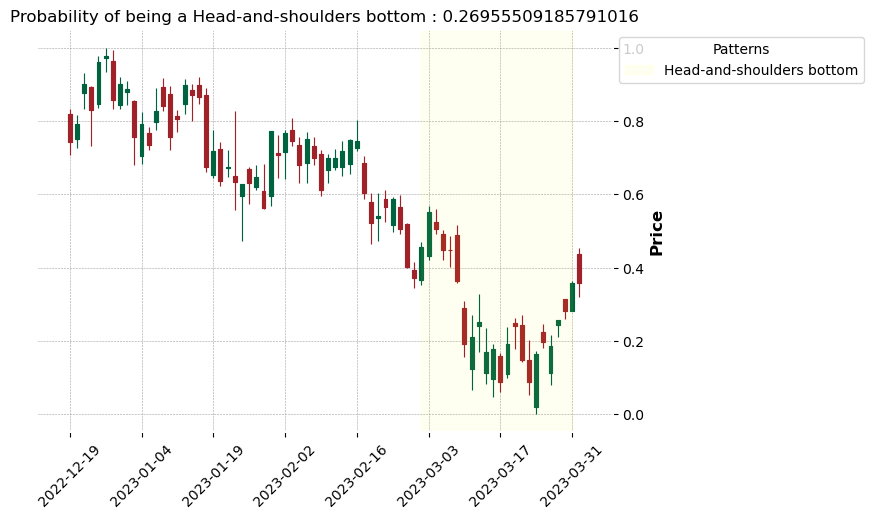

Predicted Pattern: Head-and-shoulders bottom with probability: 0.26774585247039795 in num 63 window
Pattern Name :  Head-and-shoulders bottom Pattern Start :  2023-03-03 00:00:00 Pattern End :  2023-03-31 00:00:00


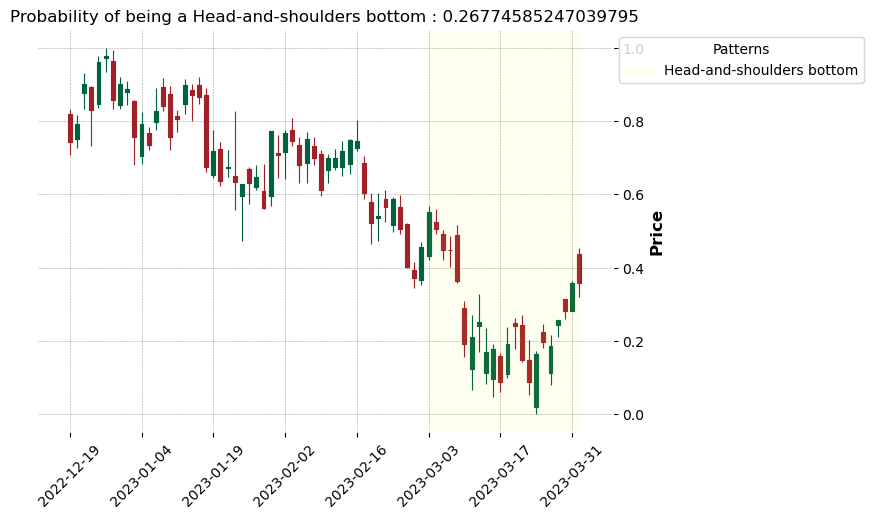

Predicted Pattern: Triangle, symmetrical with probability: 0.223497673869133 in num 64 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-03-06 00:00:00 Pattern End :  2023-04-03 00:00:00


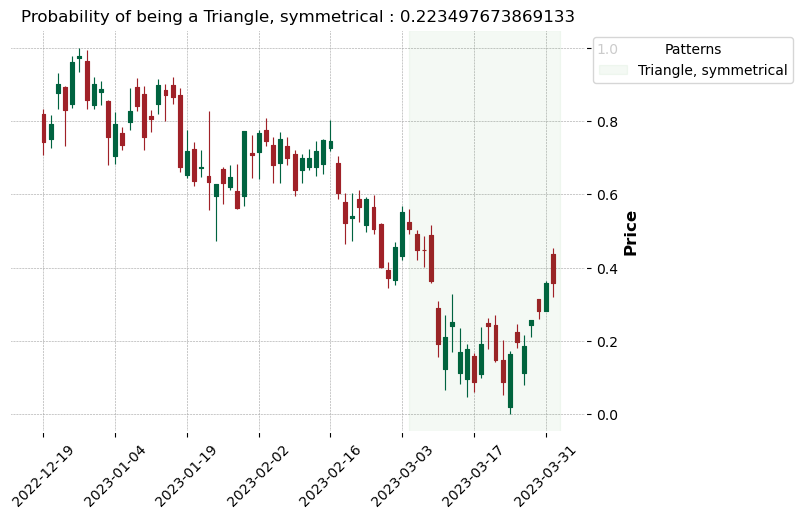

Predicted Pattern: Double Bottom, Eve and Adam with probability: 0.3138926923274994 in num 65 window
Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-07 00:00:00 Pattern End :  2023-04-03 00:00:00


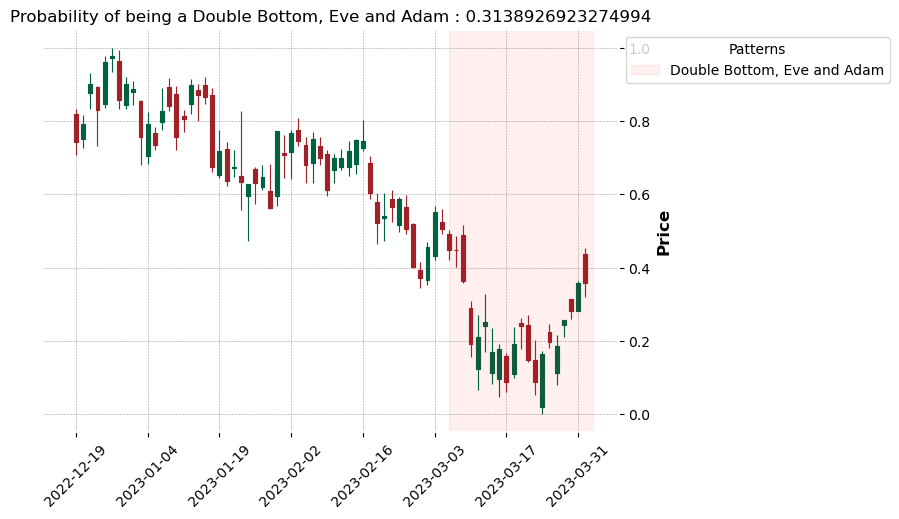

Predicted Pattern: Triangle, symmetrical with probability: 0.23138733208179474 in num 66 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-03-08 00:00:00 Pattern End :  2023-04-03 00:00:00


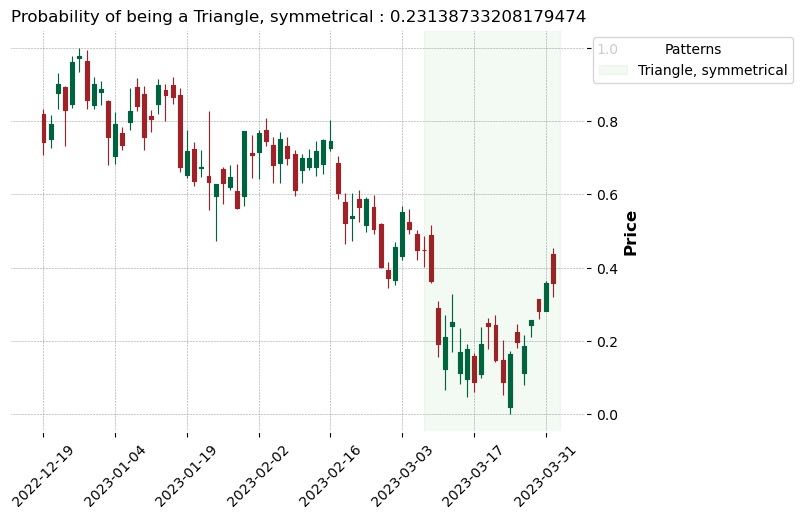

Predicted Pattern: Double Bottom, Eve and Adam with probability: 0.2838016748428345 in num 67 window
Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-09 00:00:00 Pattern End :  2023-04-03 00:00:00


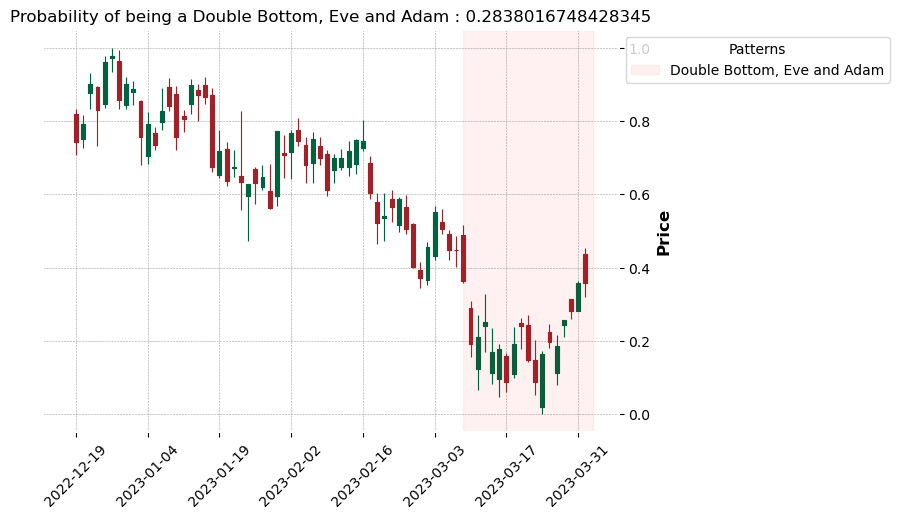

Predicted Pattern: Double Bottom, Eve and Adam with probability: 0.3222065269947052 in num 68 window
Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-10 00:00:00 Pattern End :  2023-04-03 00:00:00


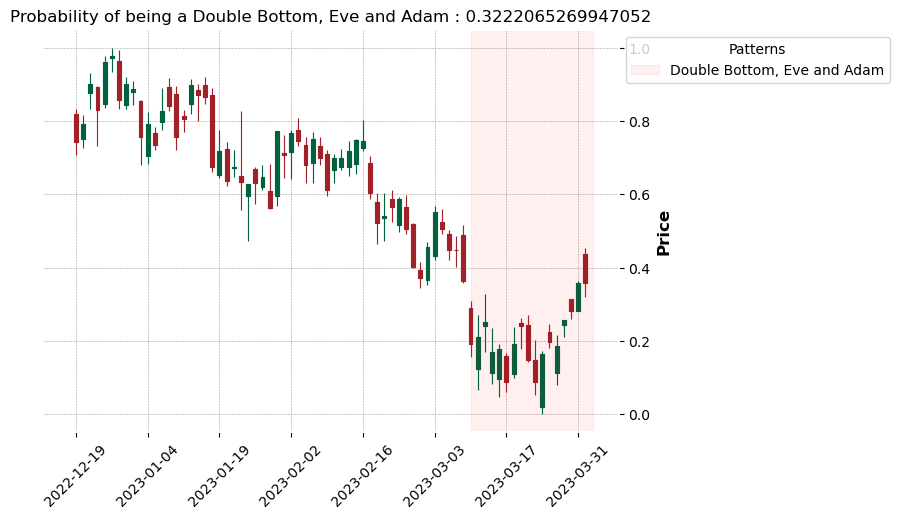

Predicted Pattern: Double Bottom, Eve and Adam with probability: 0.24399790167808533 in num 69 window
Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-13 00:00:00 Pattern End :  2023-04-03 00:00:00


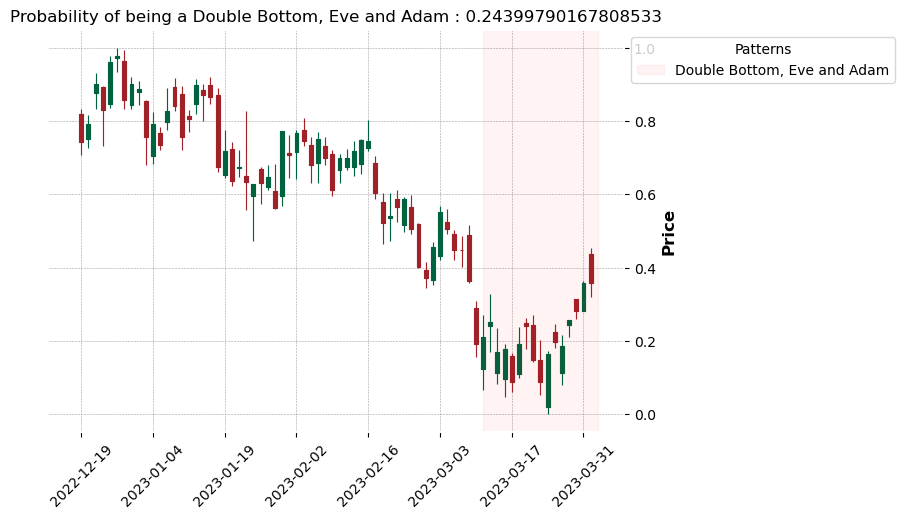

Predicted Pattern: Double Bottom, Eve and Adam with probability: 0.3139182925224304 in num 70 window
Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-14 00:00:00 Pattern End :  2023-04-03 00:00:00


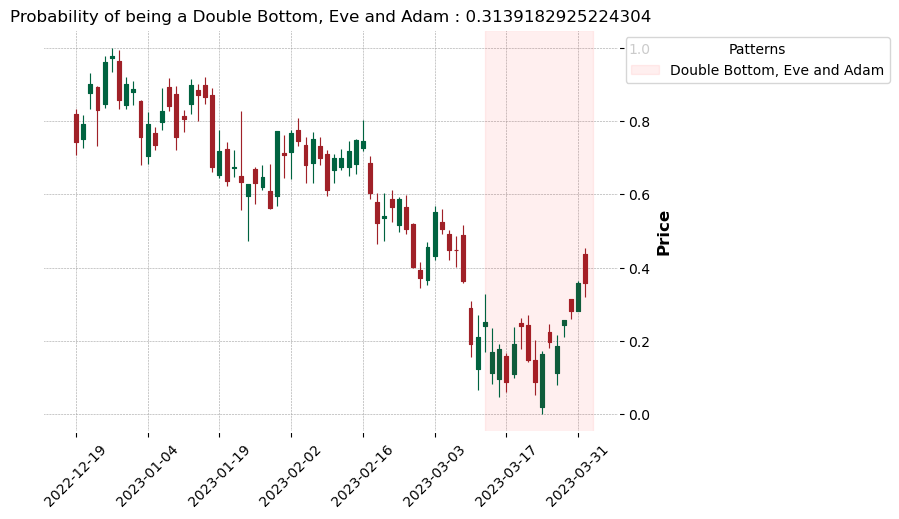

Predicted Pattern: Double Bottom, Eve and Adam with probability: 0.39483603835105896 in num 71 window
Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-15 00:00:00 Pattern End :  2023-04-03 00:00:00


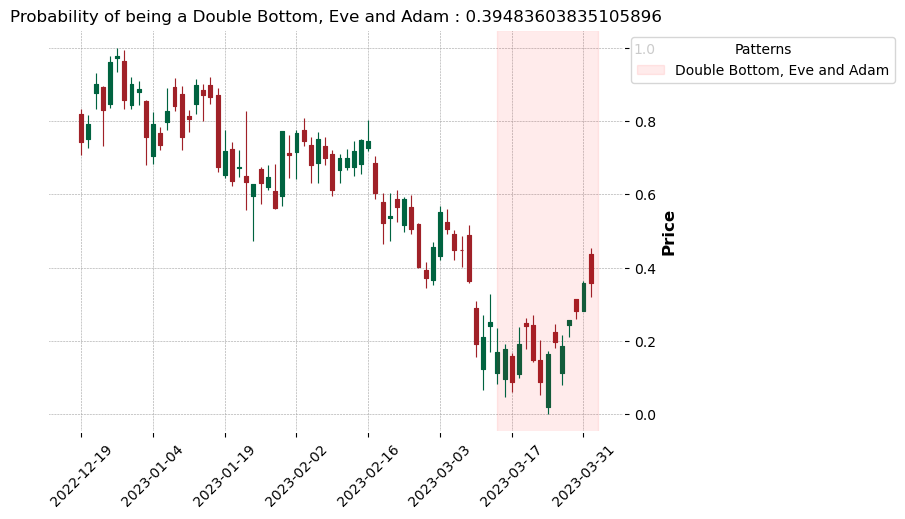

Triangle, symmetrical  :
    Clustered Windows :


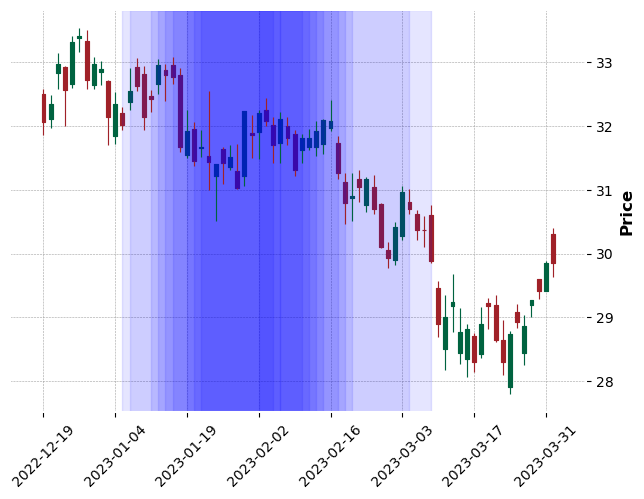

    Finalized Section :


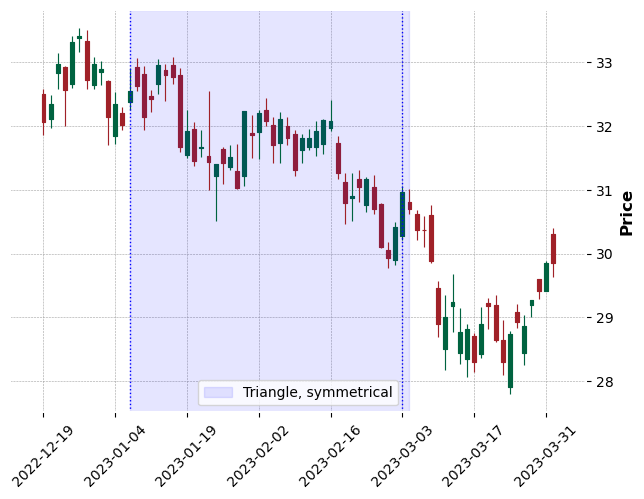

In [40]:
import random
win_res_grouped_results = window_results_all_df.groupby('Seg_ID')
# for seg_id, win_res_group in win_res_grouped_results:
grouped = test_pattern_segment_wise.groupby('Seg_ID')
# Select a group

# seg_id = random.choice(window_results_all_df['Seg_ID'].unique())
seg_id = seg_ids[0]
win_res_group = win_res_grouped_results.get_group(seg_id)

group = grouped.get_group(seg_id)
    
ohlc_data_segment = get_ohlc_data_segment(test_pattern_segment_wise, seg_id, path,group)

plot_sliding_steps(win_res_group ,ohlc_data_segment,0 ,seg_id,save = True) 
if ohlc_data_segment is None:
    print("OHLC Data segment is empty")
    # continue
predicted_patterns = prepare_dataset_for_cluster(ohlc_data_segment, win_res_group)
if predicted_patterns is None:
    print("predicted_patterns is empty")
    # continue
cluster_labled_windows_df , interseced_clusters_df = cluster_windows(predicted_patterns, probability_threshold, window_size)
if cluster_labled_windows_df is None  or interseced_clusters_df is None:
    print("cluster_labled_windows_df is empty")
    # continue
located_patterns_and_other_info = functional_pattern_filter_and_point_recognition(interseced_clusters_df)
if located_patterns_and_other_info is None:
    print("located_patterns_and_other_info is empty")
    # continue
plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, seg_id)
# located_patterns_and_other_info_updated_list.append(located_patterns_and_other_info)



Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2022-12-29 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2022-12-30 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-03 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-04 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-05 00:00:00
Pattern Name :  Double Bottom, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-06 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-09 00:00:00
Pattern Name :  Double Bottom, Adam and Adam Pattern Start :  2022-12-19 00:00:00 Pattern End :  2023-01-10 00:00:00
Pattern Name :  Triangle, symmetrical Pattern Start :  2022-12-19 00:00:00 Pattern En

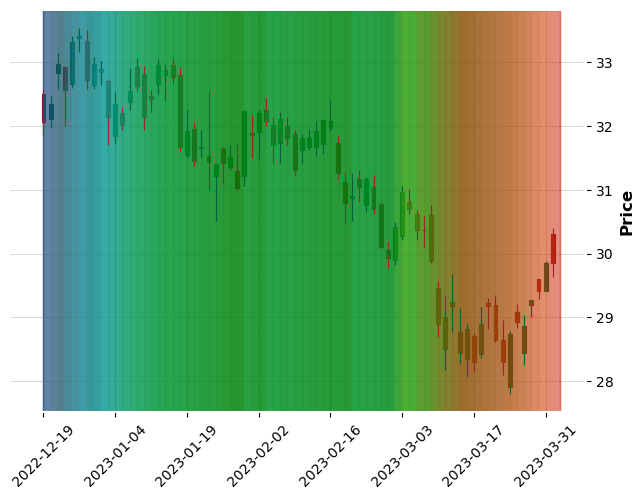

In [41]:
import random
win_res_grouped_results = window_results_all_df.groupby('Seg_ID')
# seg_id = random.choice(window_results_all_df['Seg_ID'].unique())
seg_id = seg_ids[0]
win_res_group = win_res_grouped_results.get_group(seg_id)
plot_patterns_for_segment(seg_id, win_res_group ,color_pattern_wise=True,legend=False , seg_alpha=0.08)

Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-31 00:00:00 Pattern End :  2023-03-01 00:00:00


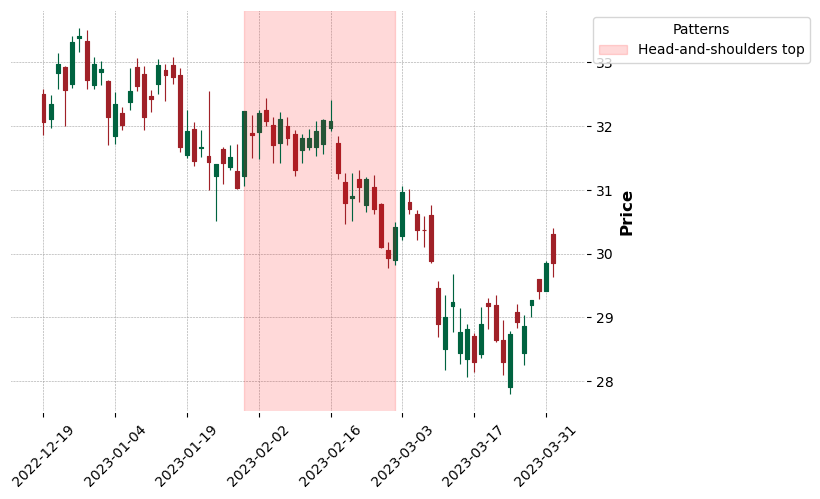

In [42]:
head_and_sholder_clustered_win = cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == 'Head-and-shoulders top']
plot_patterns_for_segment(seg_id, head_and_sholder_clustered_win ,same_color=True , seg_alpha=0.15)

Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-31 00:00:00 Pattern End :  2023-03-01 00:00:00


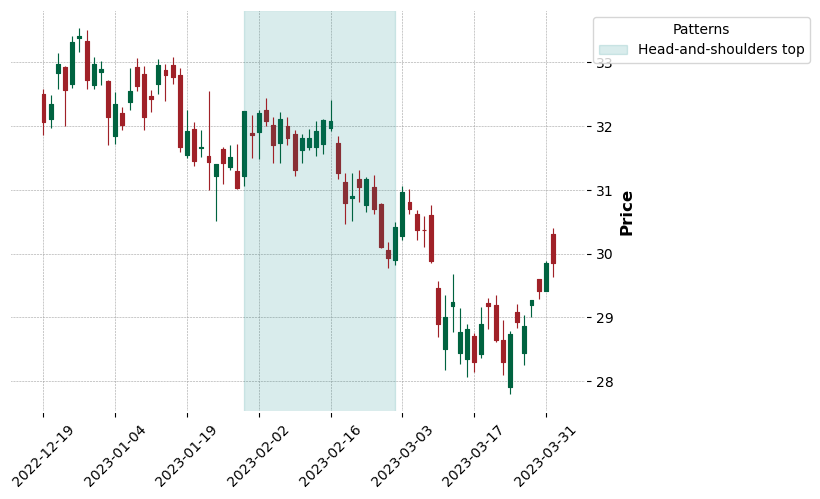

In [43]:
head_and_sholder_clustered_win = cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == 'Head-and-shoulders top']
plot_patterns_for_segment(seg_id, head_and_sholder_clustered_win ,color_cluster_wise=True , seg_alpha=0.15)

In [44]:
# save located_patterns_and_other_info_updated_df to a csv file
located_patterns_and_other_info_updated_df.to_csv('Datasets/located_patterns_and_other_info_updated_df.csv', index=False)

# Evaluating the results


In [45]:
located_patterns_and_other_info_updated_df

Seg_ID Symbol                Chart Pattern  Cluster      Start        End  \
0        0     AA  Double Bottom, Eve and Adam        0 2024-02-14 2024-03-15   
1        0     AA         Flag, high and tight        0 2024-03-05 2024-04-04   
2        0     AA         Flag, high and tight        1 2024-04-24 2024-05-28   
3        0     AA        Triangle, symmetrical        0 2024-03-27 2024-05-15   
0        1     AA  Double Bottom, Eve and Adam        0 2020-10-29 2020-11-16   
..     ...    ...                          ...      ...        ...        ...   
1      407   ^DJU       Head-and-shoulders top        0 2022-08-24 2022-10-03   
0      408  ^IXIC         Flag, high and tight        0 2022-03-02 2022-04-05   
1      408  ^IXIC       Head-and-shoulders top        0 2022-03-15 2022-04-13   
2      408  ^IXIC        Triangle, symmetrical        0 2022-02-04 2022-03-14   
3      408  ^IXIC        Triangle, symmetrical        1 2022-03-29 2022-05-04   

    Seg_Start    Seg_End DB_Valley_1 DB_Valley_2  ...   Calc_End Error  \
0  2024-02-05 2024-05-28  2024-02-20  2024-02-26  ... 2024-02-26   NaN   
1  2024-02-05 2024-05-28         NaT         NaT  ... 2024-04-04   NaN   
2  2024-02-05 2024-05-28         NaT         NaT  ... 2024-05-28   NaN   
3  2024-02-05 2024-05-28         NaT         NaT  ... 2024-05-15   NaN   
0  2020-10-29 2021-03-21         NaT         NaT  ... 2020-11-16  True   
..        ...        ...         ...         ...  ...        ...   ...   
1  2022-07-19 2022-11-21         NaT         NaT  ... 2022-09-19   NaN   
0  2022-02-02 2022-05-25         NaT         NaT  ... 2022-04-05   NaN   
1  2022-02-02 2022-05-25         NaT         NaT  ... 2022-04-13  True   
2  2022-02-02 2022-05-25         NaT         NaT  ... 2022-03-14   NaN   
3  2022-02-02 2022-05-25         NaT         NaT  ... 2022-05-04   NaN   

   HS_Left_Shoulder    HS_Head HS_Right_Shoulder HS_Neckline_1 HS_Neckline_2  \
0               NaT        NaT               NaT           NaT           NaT   
1               NaT        NaT               NaT           NaT           NaT   
2               NaT        NaT               NaT           NaT           NaT   
3               NaT        NaT               NaT           NaT           NaT   
0               NaT        NaT               NaT           NaT           NaT   
..              ...        ...               ...           ...           ...   
1        2022-08-26 2022-09-12        2022-09-19    2022-09-01    2022-09-13   
0               NaT        NaT               NaT           NaT           NaT   
1               NaT        NaT               NaT           NaT           NaT   
2               NaT        NaT               NaT           NaT           NaT   
3               NaT        NaT               NaT           NaT           NaT   

   DT_Peak_1 DT_Peak_2 DT_Valley  
0        NaT       NaT       NaT  
1        NaT       NaT       NaT  
2        NaT       NaT       NaT  
3        NaT       NaT       NaT  
0        NaT       NaT       NaT  
..       ...       ...       ...  
1        NaT       NaT       NaT  
0        NaT       NaT       NaT  
1        NaT       NaT       NaT  
2        NaT       NaT       NaT  
3        NaT       NaT       NaT  

[1301 rows x 24 columns]

In [46]:
test_patterns

Symbol                 Chart Pattern  BullishBearish       Start  \
0      NUS   Double Bottom, Eve and Adam               0  2023-01-19   
1      CLS  Double Bottom, Adam and Adam               0  2024-03-11   
2     ADTN         Triangle, symmetrical               0  2023-06-16   
3     ADTN     Head-and-shoulders bottom               1  2020-09-09   
4      NSP  Double Bottom, Adam and Adam               0  2023-05-16   
..     ...                           ...             ...         ...   
590   RGLD     Double Top, Adam and Adam               0  2024-10-21   
591    MRK   Double Bottom, Eve and Adam               0  2024-08-07   
592    IRM  Double Bottom, Adam and Adam               0  2025-01-28   
593    CBT     Double Top, Adam and Adam               0  2024-11-25   
594     BG  Double Bottom, Adam and Adam               1  2022-07-06   

            End                  Industry  Pattern_Length  
0    2023-01-31      Toiletries/Cosmetics              12  
1    2024-03-19               Electronics               8  
2    2023-07-10        Telecom. Equipment              24  
3    2020-10-02        Telecom. Equipment              23  
4    2023-05-31           Human Resources              15  
..          ...                       ...             ...  
590  2024-10-29  Metals and Mining (Div.)               8  
591  2024-08-14                      Drug               7  
592  2025-02-03       Industrial Services               6  
593  2024-12-04    Chemical (Diversified)               9  
594  2022-07-14           Food Processing               8  

[595 rows x 7 columns]

In [47]:
def intersection_over_union(start1, end1, start2, end2):
    """
    Compute Intersection over Union (IoU) between two date ranges.
    """
    latest_start = max(start1, start2)
    earliest_end = min(end1, end2)
    overlap = max(0, (earliest_end - latest_start).days + 1)
    union = (end1 - start1).days + (end2 - start2).days + 2 - overlap
    return overlap / union if union > 0 else 0  # Avoid division by zero

def mean_abselute_error(start1, end1, start2, end2):
    """
    Compute Mean Absolute Error (MAE) between two date ranges.
    """
    return (abs(start1 - start2).days + abs(end1 - end2).days) / 2

In [48]:
from tqdm import tqdm
import pandas as pd



# Dictionary to store the count of properly located patterns
number_of_properly_located_patterns = {}
iou_for_each_properly_detected_pattern = {}
mae_for_each_properly_detected_pattern = {}

# Convert date columns to datetime (once, outside the loop for efficiency)
located_patterns_and_other_info_updated_df['Calc_Start'] = pd.to_datetime(located_patterns_and_other_info_updated_df['Calc_Start'])
located_patterns_and_other_info_updated_df['Calc_End'] = pd.to_datetime(located_patterns_and_other_info_updated_df['Calc_End'])

# Iterate over test patterns with progress bar
for index, row in tqdm(test_patterns.iterrows(), total=len(test_patterns), desc="Processing Patterns"):
    symbol = row['Symbol']
    chart_pattern = row['Chart Pattern']
    start_date = pd.to_datetime(row['Start']).tz_localize(None)
    end_date = pd.to_datetime(row['End']).tz_localize(None)
    
    # Filter for matching symbol and chart pattern
    located_patterns_for_this = located_patterns_and_other_info_updated_df[
        (located_patterns_and_other_info_updated_df['Symbol'] == symbol) &
        (located_patterns_and_other_info_updated_df['Chart Pattern'] == chart_pattern)
    ].copy()  # Use `.copy()` to avoid SettingWithCopyWarning
    
    if located_patterns_for_this.empty:
        continue  # Skip if no matching rows
    
    # Compute IoU for each row using .loc to avoid warnings
    located_patterns_for_this.loc[:, 'IoU'] = located_patterns_for_this.apply(
        lambda x: intersection_over_union(start_date, end_date, x['Calc_Start'], x['Calc_End']),
        axis=1
    )
    
    # Compute MAE for each row using .loc to avoid warnings
    located_patterns_for_this.loc[:, 'MAE'] = located_patterns_for_this.apply(
        lambda x: mean_abselute_error(start_date, end_date, x['Calc_Start'], x['Calc_End']),
        axis=1
    )

    
    # Filter based on IoU threshold (≥ 0.8)
    located_patterns_for_this_proper = located_patterns_for_this[located_patterns_for_this['IoU'] >= 0.25]
    
    if not located_patterns_for_this_proper.empty:
        number_of_properly_located_patterns[chart_pattern] = number_of_properly_located_patterns.get(chart_pattern, 0) + 1
        iou_for_each_properly_detected_pattern[chart_pattern] = iou_for_each_properly_detected_pattern.get(chart_pattern, 0) + max(located_patterns_for_this_proper['IoU'])
        mae_for_each_properly_detected_pattern[chart_pattern] = mae_for_each_properly_detected_pattern.get(chart_pattern, 0) + min(located_patterns_for_this_proper['MAE'])

number_of_properly_located_patterns


Processing Patterns: 100%|██████████| 595/595 [00:01<00:00, 315.16it/s]


{'Triangle, symmetrical': 42,
 'Head-and-shoulders top': 30,
 'Flag, high and tight': 17,
 'Double Bottom, Eve and Adam': 5,
 'Head-and-shoulders bottom': 15,
 'Double Top, Adam and Adam': 5}

## Recall


In [49]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
total_number_of_test_patterns = len(test_patterns)

recall = total_number_of_properly_located_patterns / total_number_of_test_patterns

print (f"Total number of properly located patterns {total_number_of_properly_located_patterns} out of {total_number_of_test_patterns} test patterns")
print (f"Recall: {recall}")

Total number of properly located patterns 114 out of 595 test patterns
Recall: 0.1915966386554622


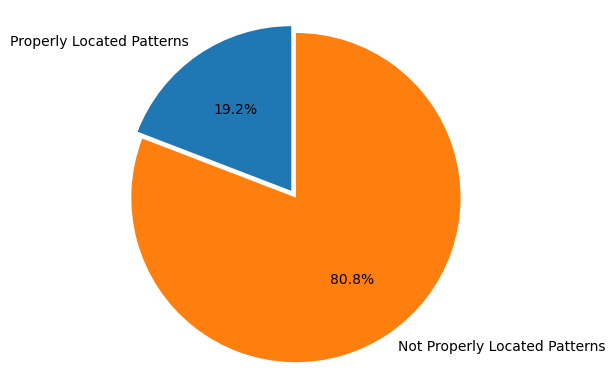

In [50]:
# Draw a pie chart of total_number_of_test_patterns vs total_number_of_properly_located_patterns
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Properly Located Patterns', 'Not Properly Located Patterns'
sizes = [recall, 1-recall]
explode = (0.05, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.show()

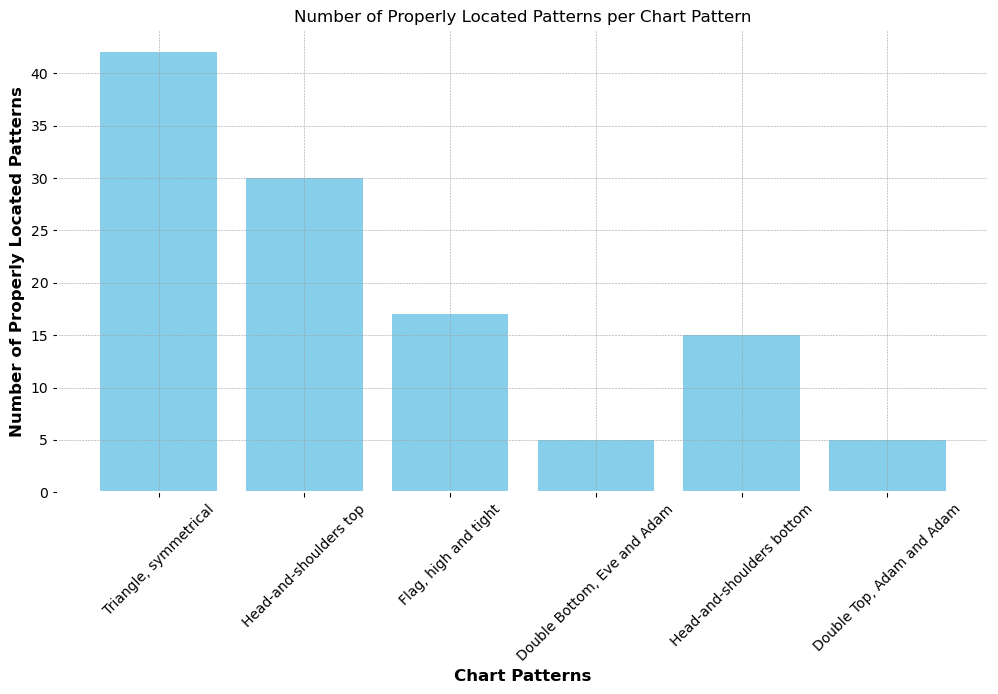

In [51]:
# visualize the recall
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(12, 6))

plt.bar(number_of_properly_located_patterns.keys(), number_of_properly_located_patterns.values(), color='skyblue')
plt.xlabel('Chart Patterns')
plt.ylabel('Number of Properly Located Patterns')
plt.title('Number of Properly Located Patterns per Chart Pattern')
plt.xticks(rotation=45)
plt.show()

### Per Pattern Recall


In [52]:
# calculate the per pattern recall
per_pattern_recall = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_recall[pattern] = count / test_patterns[test_patterns['Chart Pattern'] == pattern].shape[0]
    
for pattern, recall in per_pattern_recall.items():
    print(f"Recall for {pattern}: {recall}")

Recall for Triangle, symmetrical: 0.39622641509433965
Recall for Head-and-shoulders top: 0.4166666666666667
Recall for Flag, high and tight: 0.3953488372093023
Recall for Double Bottom, Eve and Adam: 0.08196721311475409
Recall for Head-and-shoulders bottom: 0.22058823529411764
Recall for Double Top, Adam and Adam: 0.05263157894736842


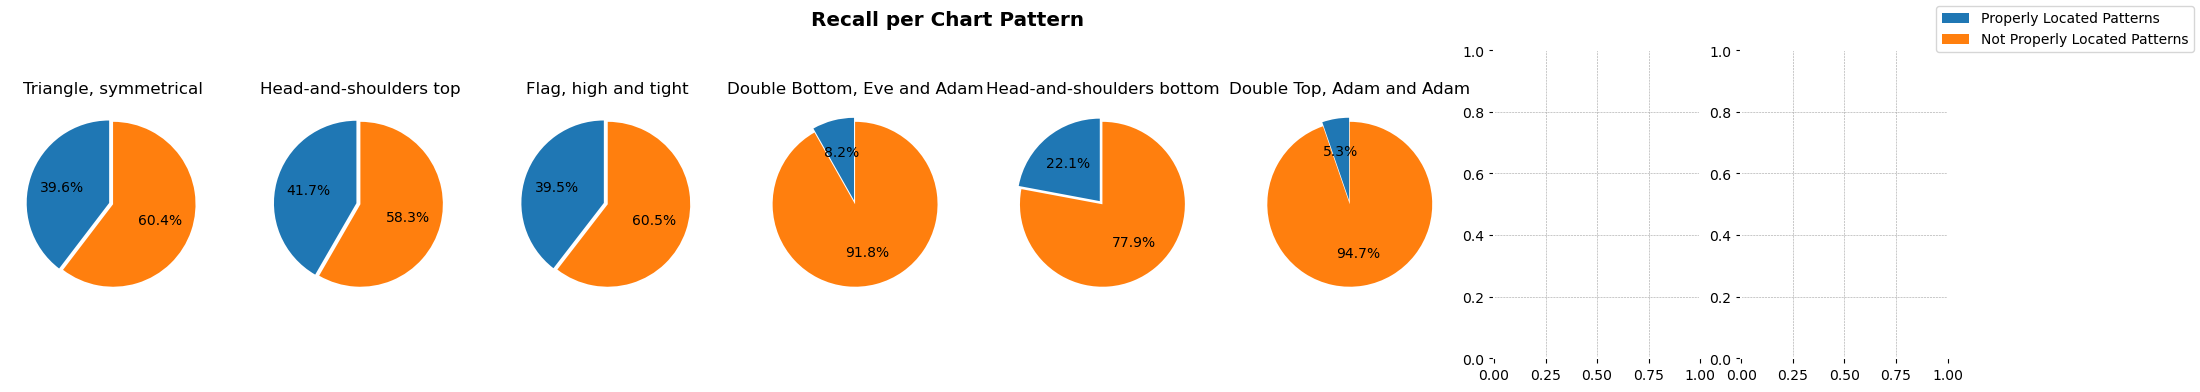

In [53]:
import matplotlib.pyplot as plt

# Define labels and explode
labels = ['Properly Located Patterns', 'Not Properly Located Patterns']
explode = (0.05, 0)  # Explode the first slice

# Create subplots
fig, axs = plt.subplots(1, 8, figsize=(25, 4))
fig.suptitle('Recall per Chart Pattern')

# Plot each pie chart
for i, (pattern, recall) in enumerate(per_pattern_recall.items()):
    ax = axs[i % 8]  # Fix index to avoid out-of-bounds errors
    wedges, texts, autotexts = ax.pie(
        [recall, 1 - recall],
        explode=explode,
        labels=[None, None],  # Remove labels from pie chart
        autopct='%1.1f%%',
        startangle=90
    )
    ax.set_title(pattern)

# Add a single legend for all pie charts
fig.legend(wedges, labels, loc="upper right")

plt.show()


## Precision


In [54]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
total_number_of_all_located_patterns = len(located_patterns_and_other_info_updated_df)

precision = total_number_of_properly_located_patterns / total_number_of_all_located_patterns

print (f"Total number of properly located patterns {total_number_of_properly_located_patterns} out of {total_number_of_all_located_patterns} located patterns")
print (f"Precision: {precision}")

Total number of properly located patterns 114 out of 1301 located patterns
Precision: 0.08762490392006149


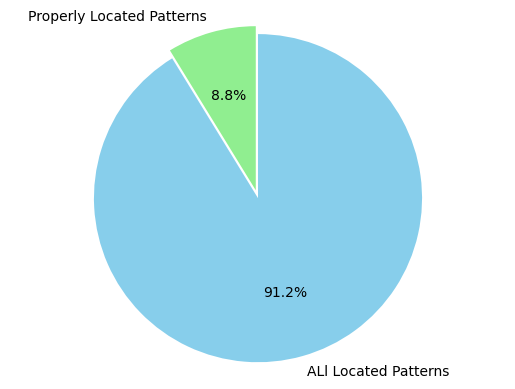

In [55]:
# Draw a pie chart of total_number_of_test_patterns vs total_number_of_properly_located_patterns
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Properly Located Patterns', 'ALl Located Patterns'
sizes = [precision, 1-precision]
explode = (0.05, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90,colors=['lightgreen', 'skyblue'])
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.show()

### Per pattern Precision


In [56]:
# calculate the per pattern precision
per_pattern_precision = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_precision[pattern] = count / located_patterns_and_other_info_updated_df[located_patterns_and_other_info_updated_df['Chart Pattern'] == pattern].shape[0]

for pattern, precision in per_pattern_precision.items():
    print(f"Precision for {pattern}: {precision}")

Precision for Triangle, symmetrical: 0.13249211356466878
Precision for Head-and-shoulders top: 0.0967741935483871
Precision for Flag, high and tight: 0.060498220640569395
Precision for Double Bottom, Eve and Adam: 0.044642857142857144
Precision for Head-and-shoulders bottom: 0.07142857142857142
Precision for Double Top, Adam and Adam: 0.09803921568627451


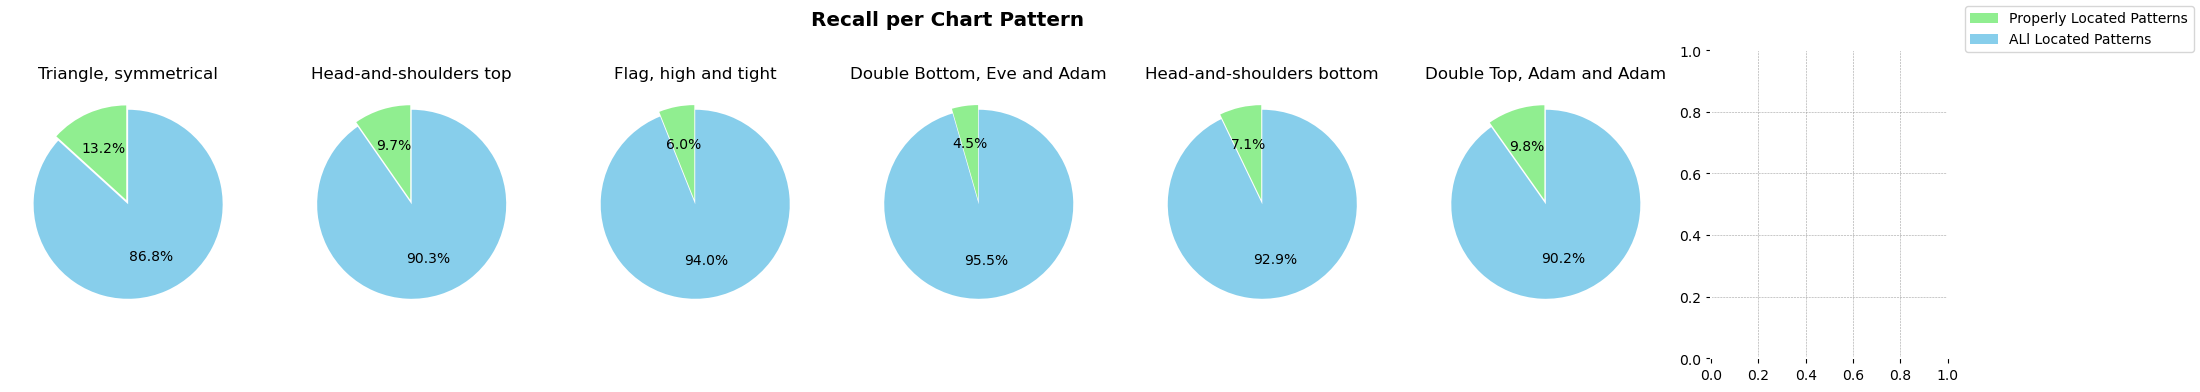

In [57]:
import matplotlib.pyplot as plt

# Define labels and explode
labels = ['Properly Located Patterns', 'ALl Located Patterns']
explode = (0.05, 0)  # Explode the first slice

# Create subplots
fig, axs = plt.subplots(1, 7, figsize=(25, 4))
fig.suptitle('Recall per Chart Pattern')

# Plot each pie chart
for i, (pattern, precision) in enumerate(per_pattern_precision.items()):
    ax = axs[i % 7]  # Fix index to avoid out-of-bounds errors
    wedges, texts, autotexts = ax.pie(
        [precision, 1 - precision],
        explode=explode,
        labels=[None, None],  # Remove labels from pie chart
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightgreen', 'skyblue']
    )
    ax.set_title(pattern)

# Add a single legend for all pie charts
fig.legend(wedges, labels, loc="upper right")

plt.show()


## F1 Score


In [58]:
if precision + recall == 0:
    F1_score = 0
else:
    F1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {F1_score}")

F1 Score: 0.06849315068493152


### Per pattern F1 score


In [59]:
# calculate the per pattern F1 score
per_pattern_F1_score = {}
for pattern, recall in per_pattern_recall.items():
    per_pattern_F1_score[pattern] = 2 * (per_pattern_precision[pattern] * recall) / (per_pattern_precision[pattern] + recall) + 1e-9
    
for pattern, F1_score in per_pattern_F1_score.items():
    print(f"F1 Score for {pattern}: {F1_score}")

F1 Score for Triangle, symmetrical: 0.19858156128368798
F1 Score for Head-and-shoulders top: 0.15706806382722513
F1 Score for Flag, high and tight: 0.10493827260493828
F1 Score for Double Bottom, Eve and Adam: 0.057803469208092484
F1 Score for Head-and-shoulders bottom: 0.10791367006474821
F1 Score for Double Top, Adam and Adam: 0.06849315168493152


## Mean Absolute Error (MAE) of correct patterns


In [60]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
mae = sum(mae_for_each_properly_detected_pattern.values()) / (total_number_of_properly_located_patterns + 1e-9)

print (f"Mean Absolute Error: {mae}")

Mean Absolute Error: 10.061403508683672


### Per pattern MAE


In [61]:
# calculate the per pattern MAE
per_pattern_mae = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_mae[pattern] = mae_for_each_properly_detected_pattern[pattern] / count
    
for pattern, pp_mae in per_pattern_mae.items():
    print(f"Mean Absolute Error for {pattern}: {pp_mae}")

Mean Absolute Error for Triangle, symmetrical: 14.619047619047619
Mean Absolute Error for Head-and-shoulders top: 6.366666666666666
Mean Absolute Error for Flag, high and tight: 13.676470588235293
Mean Absolute Error for Double Bottom, Eve and Adam: 3.0
Mean Absolute Error for Head-and-shoulders bottom: 5.866666666666666
Mean Absolute Error for Double Top, Adam and Adam: 1.3


## Mean Intersection Over Union of correct patterns


In [62]:
miou = sum(iou_for_each_properly_detected_pattern.values()) / (total_number_of_properly_located_patterns + 1e-9)

print (f"Mean Intersection over Union: {miou}")

Mean Intersection over Union: 0.6535942210109803


### Per pattern IOU


In [63]:
# calculate the per pattern IoU
per_pattern_iou = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_iou[pattern] = iou_for_each_properly_detected_pattern[pattern] / count

for pattern, pp_iou in per_pattern_iou.items():
    print(f"Mean Intersection over Union for {pattern}: {pp_iou}")

Mean Intersection over Union for Triangle, symmetrical: 0.5497631020317167
Mean Intersection over Union for Head-and-shoulders top: 0.7178583868898242
Mean Intersection over Union for Flag, high and tight: 0.6271832772518943
Mean Intersection over Union for Double Bottom, Eve and Adam: 0.7576576576576576
Mean Intersection over Union for Head-and-shoulders bottom: 0.7420956307981265
Mean Intersection over Union for Double Top, Adam and Adam: 0.8604201680672269


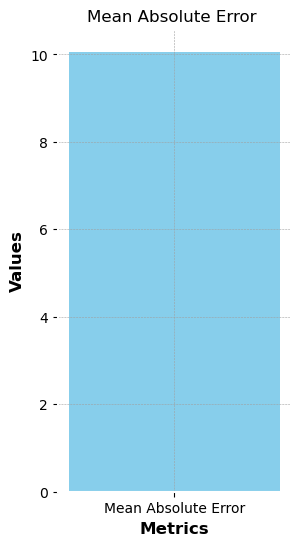

In [64]:
# draw a grapg to show the mae and miou 
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(3, 6))


plt.bar("Mean Absolute Error", mae, color='skyblue')


plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Mean Absolute Error ')
# plt.xticks(rotation=45)
plt.show()



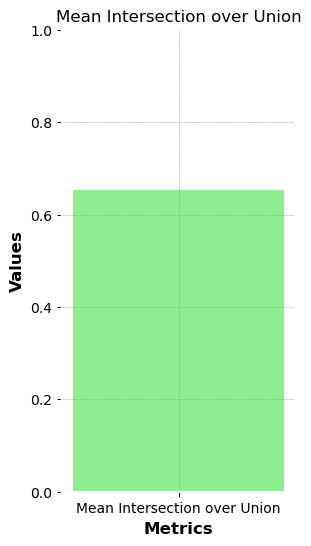

In [65]:


# draw a grapg to show the mae and miou 
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(3, 6))

plt.bar("Mean Intersection over Union", miou, color='lightgreen')

plt.ylim(0, 1) 
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Mean Intersection over Union')
# plt.xticks(rotation=45)
plt.show()


Mean Intersection over Union: 65.36%


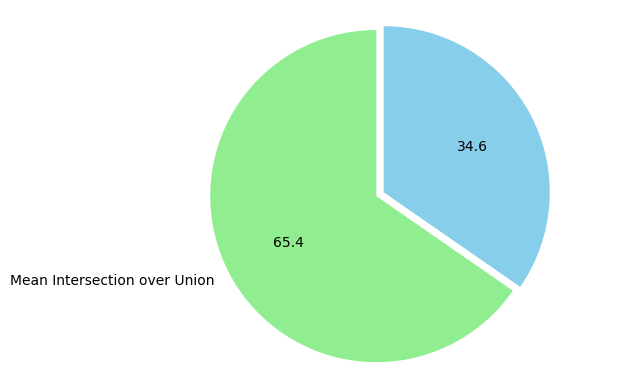

In [66]:
# show the miou as a percentage
miou_percentage = miou * 100
print(f"Mean Intersection over Union: {miou_percentage:.2f}%")

# Draw a pie chart of total_number_of_test_patterns vs total_number_of_properly_located_patterns
import matplotlib
import matplotlib
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Mean Intersection over Union', ''
sizes = [miou, 1-miou]
explode = (0.05, 0)  # only "explode" the 1st slice


fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f', startangle=90,colors=['lightgreen', 'skyblue'])
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.show()

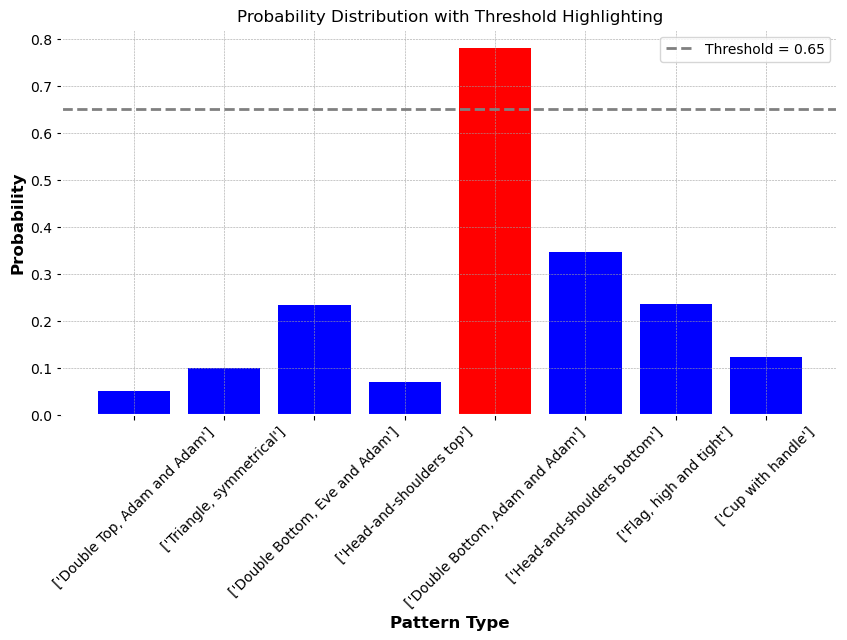

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Your probability values
probabilities = [0.05, 0.1, 0.234, 0.07, 0.78, 0.345, 0.2345, 0.123]  
threshold = 0.65

# Define x-axis labels (replace with actual pattern names if available)
pattern_labels = [f"{[pattern_encoding_reversed[i]]}" for i in range(len(probabilities))]  

# Create indices for the x-axis
indices = np.arange(len(probabilities))

# Highlight values above threshold
colors = ["red" if p >= threshold else "blue" for p in probabilities]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(indices, probabilities, color=colors)
plt.axhline(y=threshold, color="gray", linestyle="--", label=f"Threshold = {threshold}")

# Labels
plt.xticks(indices, pattern_labels, rotation=45)  # Corrected x labels
plt.xlabel("Pattern Type")
plt.ylabel("Probability")
plt.title("Probability Distribution with Threshold Highlighting")
plt.legend()
plt.show()
